In [1]:
import time
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import pickle
import seaborn as sns

import os
import sys
import annoy
from annoy import AnnoyIndex
import random



from IPython.display import display_markdown

from collections import Counter

from sklearn import preprocessing
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import classification_report
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from scipy.spatial import cKDTree
from sklearn.decomposition import PCA
from sklearn.decomposition import SparsePCA
from sklearn.ensemble import RandomForestClassifier


import antares_client

import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt

# set random seed for consistent results
import random
random.seed(0)

plt.style.use('fig_publication.mplstyle')
%config InlineBackend.figure_format = 'retina'  #for MacOS, make plots crisp

In [2]:
# From 106 available features from Kostya's lc_feature_extractor, use the 82 from SNAD Miner paper 
# R and g bands
feature_names_r_g = ['feature_amplitude_magn_r', 
                         'feature_anderson_darling_normal_magn_r',
                         'feature_beyond_1_std_magn_r', 
                         'feature_beyond_2_std_magn_r',
                         'feature_cusum_magn_r', 
                         #'feature_eta_e_magn_r',
                         'feature_inter_percentile_range_2_magn_r',
                         'feature_inter_percentile_range_10_magn_r',
                         'feature_inter_percentile_range_25_magn_r', 
                         'feature_kurtosis_magn_r',
                         'feature_linear_fit_slope_magn_r',
                         'feature_linear_fit_slope_sigma_magn_r',
                         #'feature_linear_fit_reduced_chi2_magn_r', 
                         #'feature_linear_trend_magn_r', # cadence removal
                         #'feature_linear_trend_sigma_magn_r',  # cadence removal
                         'feature_magnitude_percentage_ratio_40_5_magn_r',
                         'feature_magnitude_percentage_ratio_20_5_magn_r',
                         #'feature_maximum_slope_magn_r',
                         'feature_mean_magn_r',
                         'feature_median_absolute_deviation_magn_r',
                         'feature_percent_amplitude_magn_r',
                         'feature_median_buffer_range_percentage_10_magn_r',
                         'feature_median_buffer_range_percentage_20_magn_r',
                         'feature_percent_difference_magnitude_percentile_5_magn_r',
                         'feature_percent_difference_magnitude_percentile_10_magn_r',
                         #'feature_period_0_magn_r',  # should be negated
                         #'feature_period_s_to_n_0_magn_r', # cadence removal
                         #'feature_period_1_magn_r', 
                         #'feature_period_s_to_n_1_magn_r', # cadence removal
                         #'feature_period_2_magn_r', 
                         #'feature_period_s_to_n_2_magn_r', # cadence removal
                         #'feature_period_3_magn_r', 
                         #'feature_period_s_to_n_3_magn_r', # cadence removal
                         #'feature_period_4_magn_r', 
                         #'feature_period_s_to_n_4_magn_r', # cadence removal
                         #'feature_periodogram_amplitude_magn_r',
                         #'feature_periodogram_beyond_2_std_magn_r',  # cadence removal
                         #'feature_periodogram_beyond_3_std_magn_r',  # cadence removal
                         #'feature_periodogram_standard_deviation_magn_r',   # cadence removal
                         #'feature_chi2_magn_r',
                         'feature_skew_magn_r', 
                         'feature_standard_deviation_magn_r',
                         'feature_stetson_k_magn_r',
                         'feature_weighted_mean_magn_r',
                         'feature_anderson_darling_normal_flux_r', 
                         'feature_cusum_flux_r',
                         #'feature_eta_e_flux_r', 
                         'feature_excess_variance_flux_r',
                         'feature_kurtosis_flux_r', 
                         'feature_mean_variance_flux_r',
                         #'feature_chi2_flux_r', 
                         'feature_skew_flux_r',
                         'feature_stetson_k_flux_r',

                         'feature_amplitude_magn_g', 
                         'feature_anderson_darling_normal_magn_g',
                         'feature_beyond_1_std_magn_g', 
                         'feature_beyond_2_std_magn_g',
                         'feature_cusum_magn_g', 
                         #'feature_eta_e_magn_g',
                         'feature_inter_percentile_range_2_magn_g',
                         'feature_inter_percentile_range_10_magn_g',
                         'feature_inter_percentile_range_25_magn_g', 
                         'feature_kurtosis_magn_g',
                         'feature_linear_fit_slope_magn_g',
                         'feature_linear_fit_slope_sigma_magn_g',
                         #'feature_linear_fit_reduced_chi2_magn_g', 
                         #'feature_linear_trend_magn_g', # cadence removal
                         #'feature_linear_trend_sigma_magn_g',  # cadence removal
                         'feature_magnitude_percentage_ratio_40_5_magn_g',
                         'feature_magnitude_percentage_ratio_20_5_magn_g',
                         #'feature_maximum_slope_magn_g', 
                         'feature_mean_magn_g',
                         'feature_median_absolute_deviation_magn_g',
                         'feature_median_buffer_range_percentage_10_magn_g',
                         'feature_median_buffer_range_percentage_20_magn_g',
                         'feature_percent_amplitude_magn_g',
                         'feature_percent_difference_magnitude_percentile_5_magn_g',
                         'feature_percent_difference_magnitude_percentile_10_magn_g',
                         #'feature_period_0_magn_g',  # should be negated
                         #'feature_period_s_to_n_0_magn_g', # cadence removal
                         #'feature_period_1_magn_g', 
                         #'feature_period_s_to_n_1_magn_g', # cadence removal
                         #'feature_period_2_magn_g', 
                         #'feature_period_s_to_n_2_magn_g', # cadence removal
                         #'feature_period_3_magn_g', 
                         #'feature_period_s_to_n_3_magn_g', # cadence removal
                         #'feature_period_4_magn_g', 
                         #'feature_period_s_to_n_4_magn_g', # cadence removal
                         #'feature_periodogram_amplitude_magn_g',
                         #'feature_periodogram_beyond_2_std_magn_g',  # cadence removal
                         #'feature_periodogram_beyond_3_std_magn_g', # cadence removal
                         #'feature_periodogram_standard_deviation_magn_g',  # cadence removal
                         #'feature_chi2_magn_g',
                         'feature_skew_magn_g', 
                         'feature_standard_deviation_magn_g',
                         'feature_stetson_k_magn_g', 
                         'feature_weighted_mean_magn_g',
                         'feature_anderson_darling_normal_flux_g', 
                         'feature_cusum_flux_g',
                         #'feature_eta_e_flux_g', 
                         'feature_excess_variance_flux_g',
                         'feature_kurtosis_flux_g', 
                         'feature_mean_variance_flux_g',
                         #'feature_chi2_flux_g', 
                         'feature_skew_flux_g',
                         'feature_stetson_k_flux_g'] 
    
ztf_id_and_features_r_g = ['Unnamed: 0'] + ['locus_id', 'ra', 'dec',\
                            'tags', 'catalogs', 'ztf_object_id', 'ztf_ssnamenr', 'num_alerts',\
                            'num_mag_values', 'oldest_alert_id', 'oldest_alert_magnitude',\
                            'oldest_alert_observation_time', 'newest_alert_id',\
                            'newest_alert_magnitude', 'newest_alert_observation_time',\
                            'brightest_alert_id', 'brightest_alert_magnitude', \
                            'brightest_alert_observation_time'] + feature_names_r_g +\
                        ['horizons_targetname', 'anomaly', 'anom_score', 'anomaly_score',\
                         'anomaly_mask', 'anomaly_type', 'is_corrected', 'vpdf_extreme_version',\
                         'vpdf_extreme_faint', 'vpdf_extreme_bright', 'locus_gal_l', 'locus_gal_b']


feature_names_hostgal = [
#  'Unnamed: 0',
#  'level_0',
#  'index',
#  'objName',
#  'objAltName1',
#  'objAltName2',
#  'objAltName3',
#  'objID',
#  'uniquePspsOBid',
#  'ippObjID',
#  'surveyID',
#  'htmID',
#  'zoneID',
#  'tessID',
#  'projectionID',
#  'skyCellID',
#  'randomID',
#  'batchID',
#  'dvoRegionID',
#  'processingVersion',
#  'objInfoFlag',
#  'qualityFlag',
#  'raStack',
#  'decStack',
#  'raStackErr',
#  'decStackErr',
#  'raMean',
#  'decMean',
#  'raMeanErr',
#  'decMeanErr',
#  'epochMean',
#  'posMeanChisq',
#  'cx',
#  'cy',
#  'cz',
#  'lambda',
#  'beta',
#  'l',
#  'b',
#  'nStackObjectRows',
#  'nStackDetections',
#  'nDetections',
#  'ng',
#  'nr',
#  'ni',
#  'nz',
#  'ny',
#  'uniquePspsSTid',
#  'primaryDetection',
#  'bestDetection',
#  'gippDetectID',
#  'gstackDetectID',
#  'gstackImageID',
#  'gra',
#  'gdec',
#  'graErr',
#  'gdecErr',
#  'gEpoch',
#  'gPSFMag',
#  'gPSFMagErr',
#  'gApMag',
#  'gApMagErr',
#  'gKronMag',
#  'gKronMagErr',
#  'ginfoFlag',
#  'ginfoFlag2',
#  'ginfoFlag3',
#  'gnFrames',
#  'gxPos',
#  'gyPos',
#  'gxPosErr',
#  'gyPosErr',
#  'gpsfMajorFWHM',
#  'gpsfMinorFWHM',
#  'gpsfTheta',
#  'gpsfCore',
#  'gpsfLikelihood',
#  'gpsfQf',
#  'gpsfQfPerfect',
#  'gpsfChiSq',
 'gmomentXX',
 'gmomentXY',
 'gmomentYY',
 'gmomentR1',
 'gmomentRH',
 'gPSFFlux',
#  'gPSFFluxErr',
 'gApFlux',
#  'gApFluxErr',
#  'gApFillFac',
#  'gApRadius',
 'gKronFlux',
#  'gKronFluxErr',
 'gKronRad',
#  'gexpTime',
 'gExtNSigma',
#  'gsky',
#  'gskyErr',
#  'gzp',
#  'gPlateScale',
#  'rippDetectID',
#  'rstackDetectID',
#  'rstackImageID',
#  'rra',
#  'rdec',
#  'rraErr',
#  'rdecErr',
#  'rEpoch',
# 'rPSFMag',
#  'rPSFMagErr',
# 'rApMag',
#  'rApMagErr',
# 'rKronMag',
#  'rKronMagErr',
#  'rinfoFlag',
#  'rinfoFlag2',
#  'rinfoFlag3',
#  'rnFrames',
#  'rxPos',
#  'ryPos',
#  'rxPosErr',
#  'ryPosErr',
#  'rpsfMajorFWHM',
#  'rpsfMinorFWHM',
#  'rpsfTheta',
#  'rpsfCore',
#  'rpsfLikelihood',
#  'rpsfQf',
#  'rpsfQfPerfect',
#  'rpsfChiSq',
 'rmomentXX',
 'rmomentXY',
 'rmomentYY',
 'rmomentR1',
 'rmomentRH',
'rPSFFlux',
#  'rPSFFluxErr',
'rApFlux',
#  'rApFluxErr',
#  'rApFillFac',
# 'rApRadius',
'rKronFlux',
#  'rKronFluxErr',
'rKronRad',
#  'rexpTime',
 'rExtNSigma',
#  'rsky',
#  'rskyErr',
#  'rzp',
#  'rPlateScale',
#  'iippDetectID',
#  'istackDetectID',
#  'istackImageID',
#  'ira',
#  'idec',
#  'iraErr',
#  'idecErr',
#  'iEpoch',
#  'iPSFMag',
#  'iPSFMagErr',
#  'iApMag',
#  'iApMagErr',
#  'iKronMag',
#  'iKronMagErr',
#  'iinfoFlag',
#  'iinfoFlag2',
#  'iinfoFlag3',
#  'inFrames',
#  'ixPos',
#  'iyPos',
#  'ixPosErr',
#  'iyPosErr',
#  'ipsfMajorFWHM',
#  'ipsfMinorFWHM',
#  'ipsfTheta',
#  'ipsfCore',
#  'ipsfLikelihood',
#  'ipsfQf',
#  'ipsfQfPerfect',
#  'ipsfChiSq',
  'imomentXX',
 'imomentXY',
 'imomentYY',
 'imomentR1',
 'imomentRH',
 'iPSFFlux',
#  'iPSFFluxErr',
 'iApFlux',
#  'iApFluxErr',
#  'iApFillFac',
#  'iApRadius',
 'iKronFlux',
#  'iKronFluxErr',
 'iKronRad',
#  'iexpTime',
  'iExtNSigma',
#  'isky',
#  'iskyErr',
#  'izp',
#  'iPlateScale',
#  'zippDetectID',
#  'zstackDetectID',
#  'zstackImageID',
#  'zra',
#  'zdec',
#  'zraErr',
#  'zdecErr',
#  'zEpoch',
#  'zPSFMag',
#  'zPSFMagErr',
#  'zApMag',
#  'zApMagErr',
#  'zKronMag',
#  'zKronMagErr',
#  'zinfoFlag',
#  'zinfoFlag2',
#  'zinfoFlag3',
#  'znFrames',
#  'zxPos',
#  'zyPos',
#  'zxPosErr',
#  'zyPosErr',
#  'zpsfMajorFWHM',
#  'zpsfMinorFWHM',
#  'zpsfTheta',
#  'zpsfCore',
#  'zpsfLikelihood',
#  'zpsfQf',
#  'zpsfQfPerfect',
#  'zpsfChiSq',
  'zmomentXX',
 'zmomentXY',
 'zmomentYY',
 'zmomentR1',
 'zmomentRH',
 'zPSFFlux',
# #  'zPSFFluxErr',
 'zApFlux',
# #  'zApFluxErr',
# #  'zApFillFac',
# #  'zApRadius',
 'zKronFlux',
# #  'zKronFluxErr',
 'zKronRad',
# #  'zexpTime',
  'zExtNSigma',
#  'zsky',
#  'zskyErr',
#  'zzp',
#  'zPlateScale',
#  'yippDetectID',
#  'ystackDetectID',
#  'ystackImageID',
#  'yra',
#  'ydec',
#  'yraErr',
#  'ydecErr',
#  'yEpoch',
#  'yPSFMag',
#  'yPSFMagErr',
#  'yApMag',
#  'yApMagErr',
#  'yKronMag',
#  'yKronMagErr',
#  'yinfoFlag',
#  'yinfoFlag2',
#  'yinfoFlag3',
#  'ynFrames',
#  'yxPos',
#  'yyPos',
#  'yxPosErr',
#  'yyPosErr',
#  'ypsfMajorFWHM',
#  'ypsfMinorFWHM',
#  'ypsfTheta',
#  'ypsfCore',
#  'ypsfLikelihood',
#  'ypsfQf',
#  'ypsfQfPerfect',
#  'ypsfChiSq',
  'ymomentXX',
  'ymomentXY',
  'ymomentYY',
  'ymomentR1',
  'ymomentRH',
  'yPSFFlux',
# #   'yPSFFluxErr',
  'yApFlux',
# #   'yApFluxErr',
# #   'yApFillFac',
# #  'yApRadius',
 'yKronFlux',
# #  'yKronFluxErr',
 'yKronRad',
# #  'yexpTime',
  'yExtNSigma',
#  'ysky',
#  'yskyErr',
#  'yzp',
#  'yPlateScale',
#  'distance',
#  'SkyMapper_StarClass',
#  'gelong',
#  'g_a',
#  'g_b',
#  'g_pa',
#  'relong',
#  'r_a',
#  'r_b',
#  'r_pa',
#  'ielong',
#  'i_a',
#  'i_b',
#  'i_pa',
#  'zelong',
#  'z_a',
#  'z_b',
#  'z_pa',
   'i-z', # try throwing in
#    'g-r',
#    'r-i',
#    'g-i',
#    'z-y',
#   'g-rErr',
#   'r-iErr',
#   'i-zErr',
#   'z-yErr',
 'gApMag_gKronMag',
 'rApMag_rKronMag',
 'iApMag_iKronMag',
 'zApMag_zKronMag',
 'yApMag_yKronMag',
 '7DCD', 
#  'NED_name',
#  'NED_type',
#  'NED_vel',
#  'NED_redshift',
#  'NED_mag',
#  'class',
   'dist/DLR',
#   'dist',
#  'TransientClass',
#  'TransientRA',
#  'TransientDEC'
   ]

feature_names_tns = ['has_tns', 'tns_cls', 'spec_z', 'report_group']

lc_and_host_features = feature_names_r_g+feature_names_hostgal
lc_and_host_and_tns_features = lc_and_host_features + feature_names_tns

In [3]:
#fakes_suffix = 'SMOTE_train_test_80-20_min14_kneighbors8'
fakes_suffix = 'SMOTE_train_test_70-30_min14_kneighbors8'
#suffix=f"noTNScut_pca60_noCadence_NOtransf_HasHostGalOnly_SS_AlerceCls_NOfw_{smote_suffix}"
#dataset_bank_tns_df_resampled_train = pd.read_csv(f'../loci_dbs/alerce_cut/dataset_bank_tns_df_resampled_train_{smote_suffix}.csv.gz', compression='gzip', index_col=0)
#dataset_bank_tns_df_resampled_test = pd.read_csv(f'../loci_dbs/alerce_cut/dataset_bank_tns_df_resampled_test_{smote_suffix}.csv.gz', compression='gzip', index_col=0)

#num=3039 #5000
#n_classes=11 #12
#n_epochs=4000 #500
#fakes_suffix = f'PZFLOW_train_test_70-30_min14_classes{n_classes}_epochs{n_epochs}'
#fakes_suffix = f'PZFLOW_train_test_80-20_min14_classes{n_classes}_epochs{n_epochs}_n{num}'
#fakes_suffix = f'PZFLOW_train_test_80-20_min14_classes{n_classes}_epochs{n_epochs}_n{num}_RollingSplineCoupling_B=5'
#fakes_suffix = f'PZFLOW_train_test_80-20_min14_classes{n_classes}_epochs{n_epochs}_n{num}_RollingSplineCoupling_B=5_chunks20'

suffix=f"noTNScut_pca60_noCadence_NOtransf_HasHostGalOnly_SS_AlerceCls_NOfw_{fakes_suffix}"

dataset_bank_tns_df_resampled_train = pd.read_csv(f'../loci_dbs/alerce_cut/dataset_bank_tns_df_resampled_train_{fakes_suffix}.csv.gz', compression='gzip', index_col=0)
dataset_bank_tns_df_resampled_test = pd.read_csv(f'../loci_dbs/alerce_cut/dataset_bank_tns_df_resampled_test_{fakes_suffix}.csv.gz', compression='gzip', index_col=0)

In [4]:
# Try RFC without None
dataset_bank_tns_df_resampled_train = dataset_bank_tns_df_resampled_train[dataset_bank_tns_df_resampled_train['tns_cls'] != 'None']
dataset_bank_tns_df_resampled_train


feature_amplitude_magn_r  \
ztf_object_id                             
ZTF21aarhzdh                   0.908470   
ZTF21aatvcdl                   1.001925   
ZTF20ackzfvn                   0.842765   
ZTF21abngbrl                   0.734040   
ZTF21aaaroyw                   0.411922   
...                                 ...   
ZTFabc91973                    0.648056   
ZTFabc46594                    0.486110   
ZTFabc20988                    0.447717   
ZTFabc25754                    0.351957   
ZTFabc81371                    0.445597   

               feature_anderson_darling_normal_magn_r  \
ztf_object_id                                           
ZTF21aarhzdh                                 0.317764   
ZTF21aatvcdl                                 0.535585   
ZTF20ackzfvn                                 0.292838   
ZTF21abngbrl                                 0.614425   
ZTF21aaaroyw                                 0.292416   
...                                               ...   
ZTFabc91973                                  0.438369   
ZTFabc46594                                  0.605627   
ZTFabc20988                                  0.433476   
ZTFabc25754                                  0.541262   
ZTFabc81371                                  0.432874   

               feature_beyond_1_std_magn_r  feature_beyond_2_std_magn_r  \
ztf_object_id                                                             
ZTF21aarhzdh                      0.263158                     0.000000   
ZTF21aatvcdl                      0.384615                     0.076923   
ZTF20ackzfvn                      0.285714                     0.000000   
ZTF21abngbrl                      0.125000                     0.000000   
ZTF21aaaroyw                      0.222222                     0.000000   
...                                    ...                          ...   
ZTFabc91973                       0.306405                     0.000000   
ZTFabc46594                       0.258561                     0.017279   
ZTFabc20988                       0.428571                     0.000000   
ZTFabc25754                       0.343006                     0.012478   
ZTFabc81371                       0.428571                     0.000000   

               feature_cusum_magn_r  feature_inter_percentile_range_2_magn_r  \
ztf_object_id                                                                  
ZTF21aarhzdh               0.397708                                 1.816940   
ZTF21aatvcdl               0.355134                                 2.003849   
ZTF20ackzfvn               0.347289                                 1.685530   
ZTF21abngbrl               0.424395                                 1.468081   
ZTF21aaaroyw               0.347490                                 0.823845   
...                             ...                                      ...   
ZTFabc91973                0.350863                                 1.296113   
ZTFabc46594                0.317578                                 0.937265   
ZTFabc20988                0.403265                                 0.895435   
ZTFabc25754                0.327531                                 0.678671   
ZTFabc81371                0.403129                                 0.891194   

               feature_inter_percentile_range_10_magn_r  \
ztf_object_id                                             
ZTF21aarhzdh                                   1.555440   
ZTF21aatvcdl                                   1.392731   
ZTF20ackzfvn                                   1.470047   
ZTF21abngbrl                                   1.324121   
ZTF21aaaroyw                                   0.629479   
...                                                 ...   
ZTFabc91973                                    1.132292   
ZTFabc46594                                    0.604629   
ZTFabc20988                                    0.820801   
ZTFabc25754                                    

In [5]:
dataset_bank_tns_df_resampled_test = dataset_bank_tns_df_resampled_test[dataset_bank_tns_df_resampled_test['tns_cls'] != 'None']
dataset_bank_tns_df_resampled_test

feature_amplitude_magn_r  \
ztf_object_id                             
ZTF21aazebgh                   0.401764   
ZTF21acgxypn                   0.541942   
ZTF19aapqqrb                   0.143625   
ZTF21aasbxng                   0.943869   
ZTF21aaglgcb                   0.775517   
...                                 ...   
ZTF21acdalyp                   1.061692   
ZTF21abdcauj                   0.633349   
ZTF21aaetnfe                   1.442822   
ZTF21acgzwsc                   0.698412   
ZTF21aatklhw                   0.772630   

               feature_anderson_darling_normal_magn_r  \
ztf_object_id                                           
ZTF21aazebgh                                 0.347613   
ZTF21acgxypn                                 0.743175   
ZTF19aapqqrb                                 0.195803   
ZTF21aasbxng                                 0.500271   
ZTF21aaglgcb                                 0.484212   
...                                               ...   
ZTF21acdalyp                                 0.242709   
ZTF21abdcauj                                 0.322944   
ZTF21aaetnfe                                 1.007647   
ZTF21acgzwsc                                 0.256419   
ZTF21aatklhw                                 0.303856   

               feature_beyond_1_std_magn_r  feature_beyond_2_std_magn_r  \
ztf_object_id                                                             
ZTF21aazebgh                      0.454545                     0.000000   
ZTF21acgxypn                      0.200000                     0.000000   
ZTF19aapqqrb                      0.428571                     0.000000   
ZTF21aasbxng                      0.266667                     0.066667   
ZTF21aaglgcb                      0.363636                     0.090909   
...                                    ...                          ...   
ZTF21acdalyp                      0.357143                     0.071429   
ZTF21abdcauj                      0.400000                     0.000000   
ZTF21aaetnfe                      0.380952                     0.000000   
ZTF21acgzwsc                      0.333333                     0.000000   
ZTF21aatklhw                      0.384615                     0.000000   

               feature_cusum_magn_r  feature_inter_percentile_range_2_magn_r  \
ztf_object_id                                                                  
ZTF21aazebgh               0.412583                                 0.803528   
ZTF21acgxypn               0.395337                                 1.083883   
ZTF19aapqqrb               0.380133                                 0.287251   
ZTF21aasbxng               0.355580                                 1.887737   
ZTF21aaglgcb               0.388404                                 1.551035   
...                             ...                                      ...   
ZTF21acdalyp               0.375832                                 2.123384   
ZTF21abdcauj               0.419177                                 1.266699   
ZTF21aaetnfe               0.455937                                 2.885643   
ZTF21acgzwsc               0.373687                                 1.396824   
ZTF21aatklhw               0.387778                                 1.545259   

               feature_inter_percentile_range_10_magn_r  \
ztf_object_id                                             
ZTF21aazebgh                                   0.769645   
ZTF21acgxypn                                   0.948133   
ZTF19aapqqrb                                   0.271332   
ZTF21aasbxng                                   1.566141   
ZTF21aaglgcb                                   1.241484   
...                                                 ...   
ZTF21acdalyp                                   1.597695   
ZTF21abdcauj                                   0.828672   
ZTF21aaetnfe                                   2.600447   
ZTF21acgzwsc                                   

In [6]:
np.unique(np.array(dataset_bank_tns_df_resampled_train['tns_cls']))

array(['SLSN-II', 'SN II', 'SN IIP', 'SN IIb', 'SN IIn', 'SN Ia',
       'SN Ia-91T-like', 'SN Ib', 'SN Ic', 'SN Ic-BL', 'TDE'],
      dtype=object)

In [7]:
x_train = dataset_bank_tns_df_resampled_train.iloc[:, 0:120]
x_test = dataset_bank_tns_df_resampled_test.iloc[:, 0:120]

x_train_all = dataset_bank_tns_df_resampled_train
x_test_all = dataset_bank_tns_df_resampled_test

In [8]:
x_train_mean = np.mean(x_train, axis=0)
x_train_std = np.std(x_train, axis=0)
x_train_normalized = (x_train - x_train_mean) / x_train_std

In [9]:
x_test_mean = np.mean(x_test, axis=0)
x_test_std = np.std(x_test, axis=0)
x_test_normalized = (x_test - x_train_mean) / x_train_std # scale test by train

%%time

# Grid search
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier

rfc = RandomForestClassifier(n_estimators=100)

param_grid = {'max_depth': [30, 60, 90],
              'class_weight': [{"None": 1, "SLSN-II": w, "SN II": w, 'SN IIP': w, 'SN IIb': w, 'SN IIn': w, 'SN Ia': 1,
       'SN Ia-91T-like': w, 'SN Ib': w, 'SN Ic': w, 'SN Ic-BL': w, 'TDE': w} for w in range(1, 3)], 
             'max_features': [30, 60, 90],
             }
grid_search = GridSearchCV(rfc, param_grid=param_grid, cv=5, verbose=True, n_jobs=-1)
grid_search.fit(dataset_bank_tns_df_resampled_train.iloc[:, 0:120], np.array(dataset_bank_tns_df_resampled_train['tns_cls']))
best_params = grid_search.best_params_
print(best_params)

In [10]:
n_estimators=300 #3500
max_depth=35 #35
random_state=10
max_features=35 # {“sqrt”, “log2”, None}, int or float, default=”sqrt” - sqrt(120) ~ 10
class_weight={"None": 1, "SLSN-II": 1, "SN II": 1, 'SN IIP': 1, 'SN IIb': 1, 'SN IIn': 1, 'SN Ia': 1,
       'SN Ia-91T-like': 1, 'SN Ib': 1, 'SN Ic': 1, 'SN Ic-BL': 1, 'TDE': 1} #"balanced"

In [11]:
%%time
# Train Random Forest Classifier
clf = RandomForestClassifier(n_estimators=n_estimators, 
                             max_depth=max_depth, 
                             random_state=random_state, 
                             max_features=max_features,
                             class_weight=class_weight,
                             verbose=1, 
                             n_jobs=-1)
#clf.fit(dataset_bank_tns_df_resampled_train.iloc[:, 0:120], np.array(dataset_bank_tns_df_resampled_train['tns_cls']))
#clf.fit(x_train_normalized, np.array(x_train_all['tns_cls']))
clf.fit(x_train, np.array(x_train_all['tns_cls']))

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    7.0s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:   35.4s


CPU times: user 7min 1s, sys: 1.25 s, total: 7min 2s
Wall time: 57.7 s


[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:   57.6s finished


RandomForestClassifier(class_weight={'None': 1, 'SLSN-II': 1, 'SN II': 1,
                                     'SN IIP': 1, 'SN IIb': 1, 'SN IIn': 1,
                                     'SN Ia': 1, 'SN Ia-91T-like': 1,
                                     'SN Ib': 1, 'SN Ic': 1, 'SN Ic-BL': 1,
                                     'TDE': 1},
                       max_depth=35, max_features=35, n_estimators=300,
                       n_jobs=-1, random_state=10, verbose=1)

In [12]:
pkl_path = f"../pickles/{fakes_suffix}/"
if not os.path.exists(pkl_path):
    os.makedirs(pkl_path)
#pickle.dump(clf, open(f'../pickles/{fakes_suffix}/SMOTE_RFC_model_grid_search_n_estimators={n_estimators}_max_depth={max_depth}_random_state={random_state}_max_features={max_features}_class_weight=1-1_noNoneCls.pkl', 'wb'))


### Load pickle

In [13]:
#with open(f'../pickles/{fakes_suffix}/SMOTE_RFC_model_grid_search_n_estimators={n_estimators}_max_depth={max_depth}_random_state={random_state}_max_features={max_features}_class_weight=1-1_noNoneCls.pkl', 'rb') as f:
#    clf = pickle.load(f)

In [14]:
# Predict Excluded Object
predicted_probability = 100 * clf.predict_proba(x_test)

[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done 300 out of 300 | elapsed:    0.1s finished


In [15]:
clf.classes_

array(['SLSN-II', 'SN II', 'SN IIP', 'SN IIb', 'SN IIn', 'SN Ia',
       'SN Ia-91T-like', 'SN Ib', 'SN Ic', 'SN Ic-BL', 'TDE'],
      dtype=object)

In [16]:
# Predicted Probability to be ['None', 'SLSN-II', 'SN II', 'SN IIP', 'SN IIb', 'SN IIn', 'SN Ia',
#                              'SN Ia-91T-like', 'SN Ib', 'SN Ic', 'SN Ic-BL', 'TDE']
predicted_probability

array([[ 0.        ,  4.        ,  0.33333333, ...,  0.        ,
         1.        ,  4.33333333],
       [ 0.        , 39.66838267,  3.66666667, ..., 14.33118833,
         0.33333333,  0.33333333],
       [ 3.33333333, 38.66666667,  3.33333333, ...,  0.66666667,
         1.        , 14.        ],
       ...,
       [ 0.        ,  7.        ,  0.        , ...,  1.33333333,
         0.        ,  0.33333333],
       [ 0.        , 19.33333333,  1.33333333, ...,  5.33333333,
         1.66666667,  0.        ],
       [ 0.33333333,  6.66666667,  0.        , ...,  1.33333333,
         1.66666667,  3.33333333]])

In [17]:
#clf.classes_[1:]
clf.classes_

array(['SLSN-II', 'SN II', 'SN IIP', 'SN IIb', 'SN IIn', 'SN Ia',
       'SN Ia-91T-like', 'SN Ib', 'SN Ic', 'SN Ic-BL', 'TDE'],
      dtype=object)

In [18]:
predicted_probability.shape

(455, 11)

In [19]:
# Create a dataframe from the arrays
df = pd.DataFrame(predicted_probability, columns=clf.classes_)
df = df.set_index(x_test_all.index)

# Add a new column "RFC_best_cls" to the existing dataframe that contains the class label with the highest probability per row
# clf.classes_[1:] and row.values[1:] ignores the None class
#df['RFC_best_cls'] = df.apply(lambda row: clf.classes_[1:][np.argmax(row.values[1:])], axis=1)
# USE clf.classes_ and row.values if you don't train on the None class
df['RFC_best_cls'] = df.apply(lambda row: clf.classes_[np.argmax(row.values)], axis=1)
df

SLSN-II      SN II    SN IIP     SN IIb    SN IIn      SN Ia  \
ztf_object_id                                                                  
ZTF21aazebgh   0.000000   4.000000  0.333333   1.000000  1.666667  83.000000   
ZTF21acgxypn   0.000000  39.668383  3.666667   8.000429  3.333333  15.333333   
ZTF19aapqqrb   3.333333  38.666667  3.333333   1.333333  2.333333  24.333333   
ZTF21aasbxng   0.000000  23.666667  0.000000   1.333333  3.666667  53.666667   
ZTF21aaglgcb   6.000000  13.666667  0.000000   0.333333  5.000000  43.000000   
...                 ...        ...       ...        ...       ...        ...   
ZTF21acdalyp   0.000000  14.333333  0.333333  12.333333  3.000000  56.000000   
ZTF21abdcauj   0.000000   2.000000  0.000000   0.000000  0.000000  71.333333   
ZTF21aaetnfe   0.000000   7.000000  0.000000   4.000000  0.666667  86.333333   
ZTF21acgzwsc   0.000000  19.333333  1.333333  15.000000  0.666667  43.000000   
ZTF21aatklhw   0.333333   6.666667  0.000000   1.333333  0.000000  78.666667   

               SN Ia-91T-like      SN Ib      SN Ic  SN Ic-BL        TDE  \
ztf_object_id                                                              
ZTF21aazebgh         1.333333   3.333333   0.000000  1.000000   4.333333   
ZTF21acgxypn         0.333333  14.666667  14.331188  0.333333   0.333333   
ZTF19aapqqrb         9.333333   1.666667   0.666667  1.000000  14.000000   
ZTF21aasbxng         6.000000   2.666667   3.333333  4.333333   1.333333   
ZTF21aaglgcb        19.000000   2.666667   0.000000  0.666667   9.666667   
...                       ...        ...        ...       ...        ...   
ZTF21acdalyp         6.666667   1.000000   3.666667  1.666667   1.000000   
ZTF21abdcauj         8.000000   0.666667   0.000000  6.000000  12.000000   
ZTF21aaetnfe         0.000000   0.333333   1.333333  0.000000   0.333333   
ZTF21acgzwsc         2.000000  11.666667   5.333333  1.666667   0.000000   
ZTF21aatklhw         4.333333   2.333333   1.333333  1.666667   3.333333   

              RFC_best_cls  
ztf_object_id               
ZTF21aazebgh         SN Ia  
ZTF21acgxypn         SN II  
ZTF19aapqqrb         SN II  
ZTF21aasbxng         SN Ia  
ZTF21aaglgcb         SN Ia  
...                    ...  
ZTF21acdalyp         SN Ia  
ZTF21abdcauj         SN Ia  
ZTF21aaetnfe         SN Ia  
ZTF21acgzwsc         SN Ia  
ZTF21aatklhw         SN Ia  

[455 rows x 12 columns]

In [20]:
df2 = pd.concat([x_test_all, df], axis=1)
df2

feature_amplitude_magn_r  \
ztf_object_id                             
ZTF21aazebgh                   0.401764   
ZTF21acgxypn                   0.541942   
ZTF19aapqqrb                   0.143625   
ZTF21aasbxng                   0.943869   
ZTF21aaglgcb                   0.775517   
...                                 ...   
ZTF21acdalyp                   1.061692   
ZTF21abdcauj                   0.633349   
ZTF21aaetnfe                   1.442822   
ZTF21acgzwsc                   0.698412   
ZTF21aatklhw                   0.772630   

               feature_anderson_darling_normal_magn_r  \
ztf_object_id                                           
ZTF21aazebgh                                 0.347613   
ZTF21acgxypn                                 0.743175   
ZTF19aapqqrb                                 0.195803   
ZTF21aasbxng                                 0.500271   
ZTF21aaglgcb                                 0.484212   
...                                               ...   
ZTF21acdalyp                                 0.242709   
ZTF21abdcauj                                 0.322944   
ZTF21aaetnfe                                 1.007647   
ZTF21acgzwsc                                 0.256419   
ZTF21aatklhw                                 0.303856   

               feature_beyond_1_std_magn_r  feature_beyond_2_std_magn_r  \
ztf_object_id                                                             
ZTF21aazebgh                      0.454545                     0.000000   
ZTF21acgxypn                      0.200000                     0.000000   
ZTF19aapqqrb                      0.428571                     0.000000   
ZTF21aasbxng                      0.266667                     0.066667   
ZTF21aaglgcb                      0.363636                     0.090909   
...                                    ...                          ...   
ZTF21acdalyp                      0.357143                     0.071429   
ZTF21abdcauj                      0.400000                     0.000000   
ZTF21aaetnfe                      0.380952                     0.000000   
ZTF21acgzwsc                      0.333333                     0.000000   
ZTF21aatklhw                      0.384615                     0.000000   

               feature_cusum_magn_r  feature_inter_percentile_range_2_magn_r  \
ztf_object_id                                                                  
ZTF21aazebgh               0.412583                                 0.803528   
ZTF21acgxypn               0.395337                                 1.083883   
ZTF19aapqqrb               0.380133                                 0.287251   
ZTF21aasbxng               0.355580                                 1.887737   
ZTF21aaglgcb               0.388404                                 1.551035   
...                             ...                                      ...   
ZTF21acdalyp               0.375832                                 2.123384   
ZTF21abdcauj               0.419177                                 1.266699   
ZTF21aaetnfe               0.455937                                 2.885643   
ZTF21acgzwsc               0.373687                                 1.396824   
ZTF21aatklhw               0.387778                                 1.545259   

               feature_inter_percentile_range_10_magn_r  \
ztf_object_id                                             
ZTF21aazebgh                                   0.769645   
ZTF21acgxypn                                   0.948133   
ZTF19aapqqrb                                   0.271332   
ZTF21aasbxng                                   1.566141   
ZTF21aaglgcb                                   1.241484   
...                                                 ...   
ZTF21acdalyp                                   1.597695   
ZTF21abdcauj                                   0.828672   
ZTF21aaetnfe                                   2.600447   
ZTF21acgzwsc                                   

In [21]:
def plot_conf_matrix(y_test, y_pred, labels, title, kind, figsize=(20, 14)):
    if kind == 'completeness':
        counts = confusion_matrix(y_test, y_pred, labels=labels, normalize=None)
        recall = confusion_matrix(y_test, y_pred, labels=labels, normalize='true')
        annotations = np.vectorize(lambda c, r: f'{r:.2g}\n({c})')(counts, recall)
        heatmap = pd.DataFrame(recall, index=labels, columns=labels)
    
    if kind == 'purity':
        counts = confusion_matrix(y_test, y_pred, labels=labels, normalize=None)
        recall = confusion_matrix(y_test, y_pred, labels=labels, normalize='pred')
        annotations = np.vectorize(lambda c, r: f'{r:.2g}\n({c})')(counts, recall)
        heatmap = pd.DataFrame(recall, index=labels, columns=labels)
    
    plt.figure(figsize=figsize)
    sns.heatmap(heatmap, annot=annotations, fmt='s', cmap='Blues', vmin=0, vmax=1, annot_kws={"fontsize":18})
    plt.title(title, fontsize=24)
    plt.ylabel('True class', fontsize=24)
    plt.xlabel('Predicted class', fontsize=24)
    #plt.show()

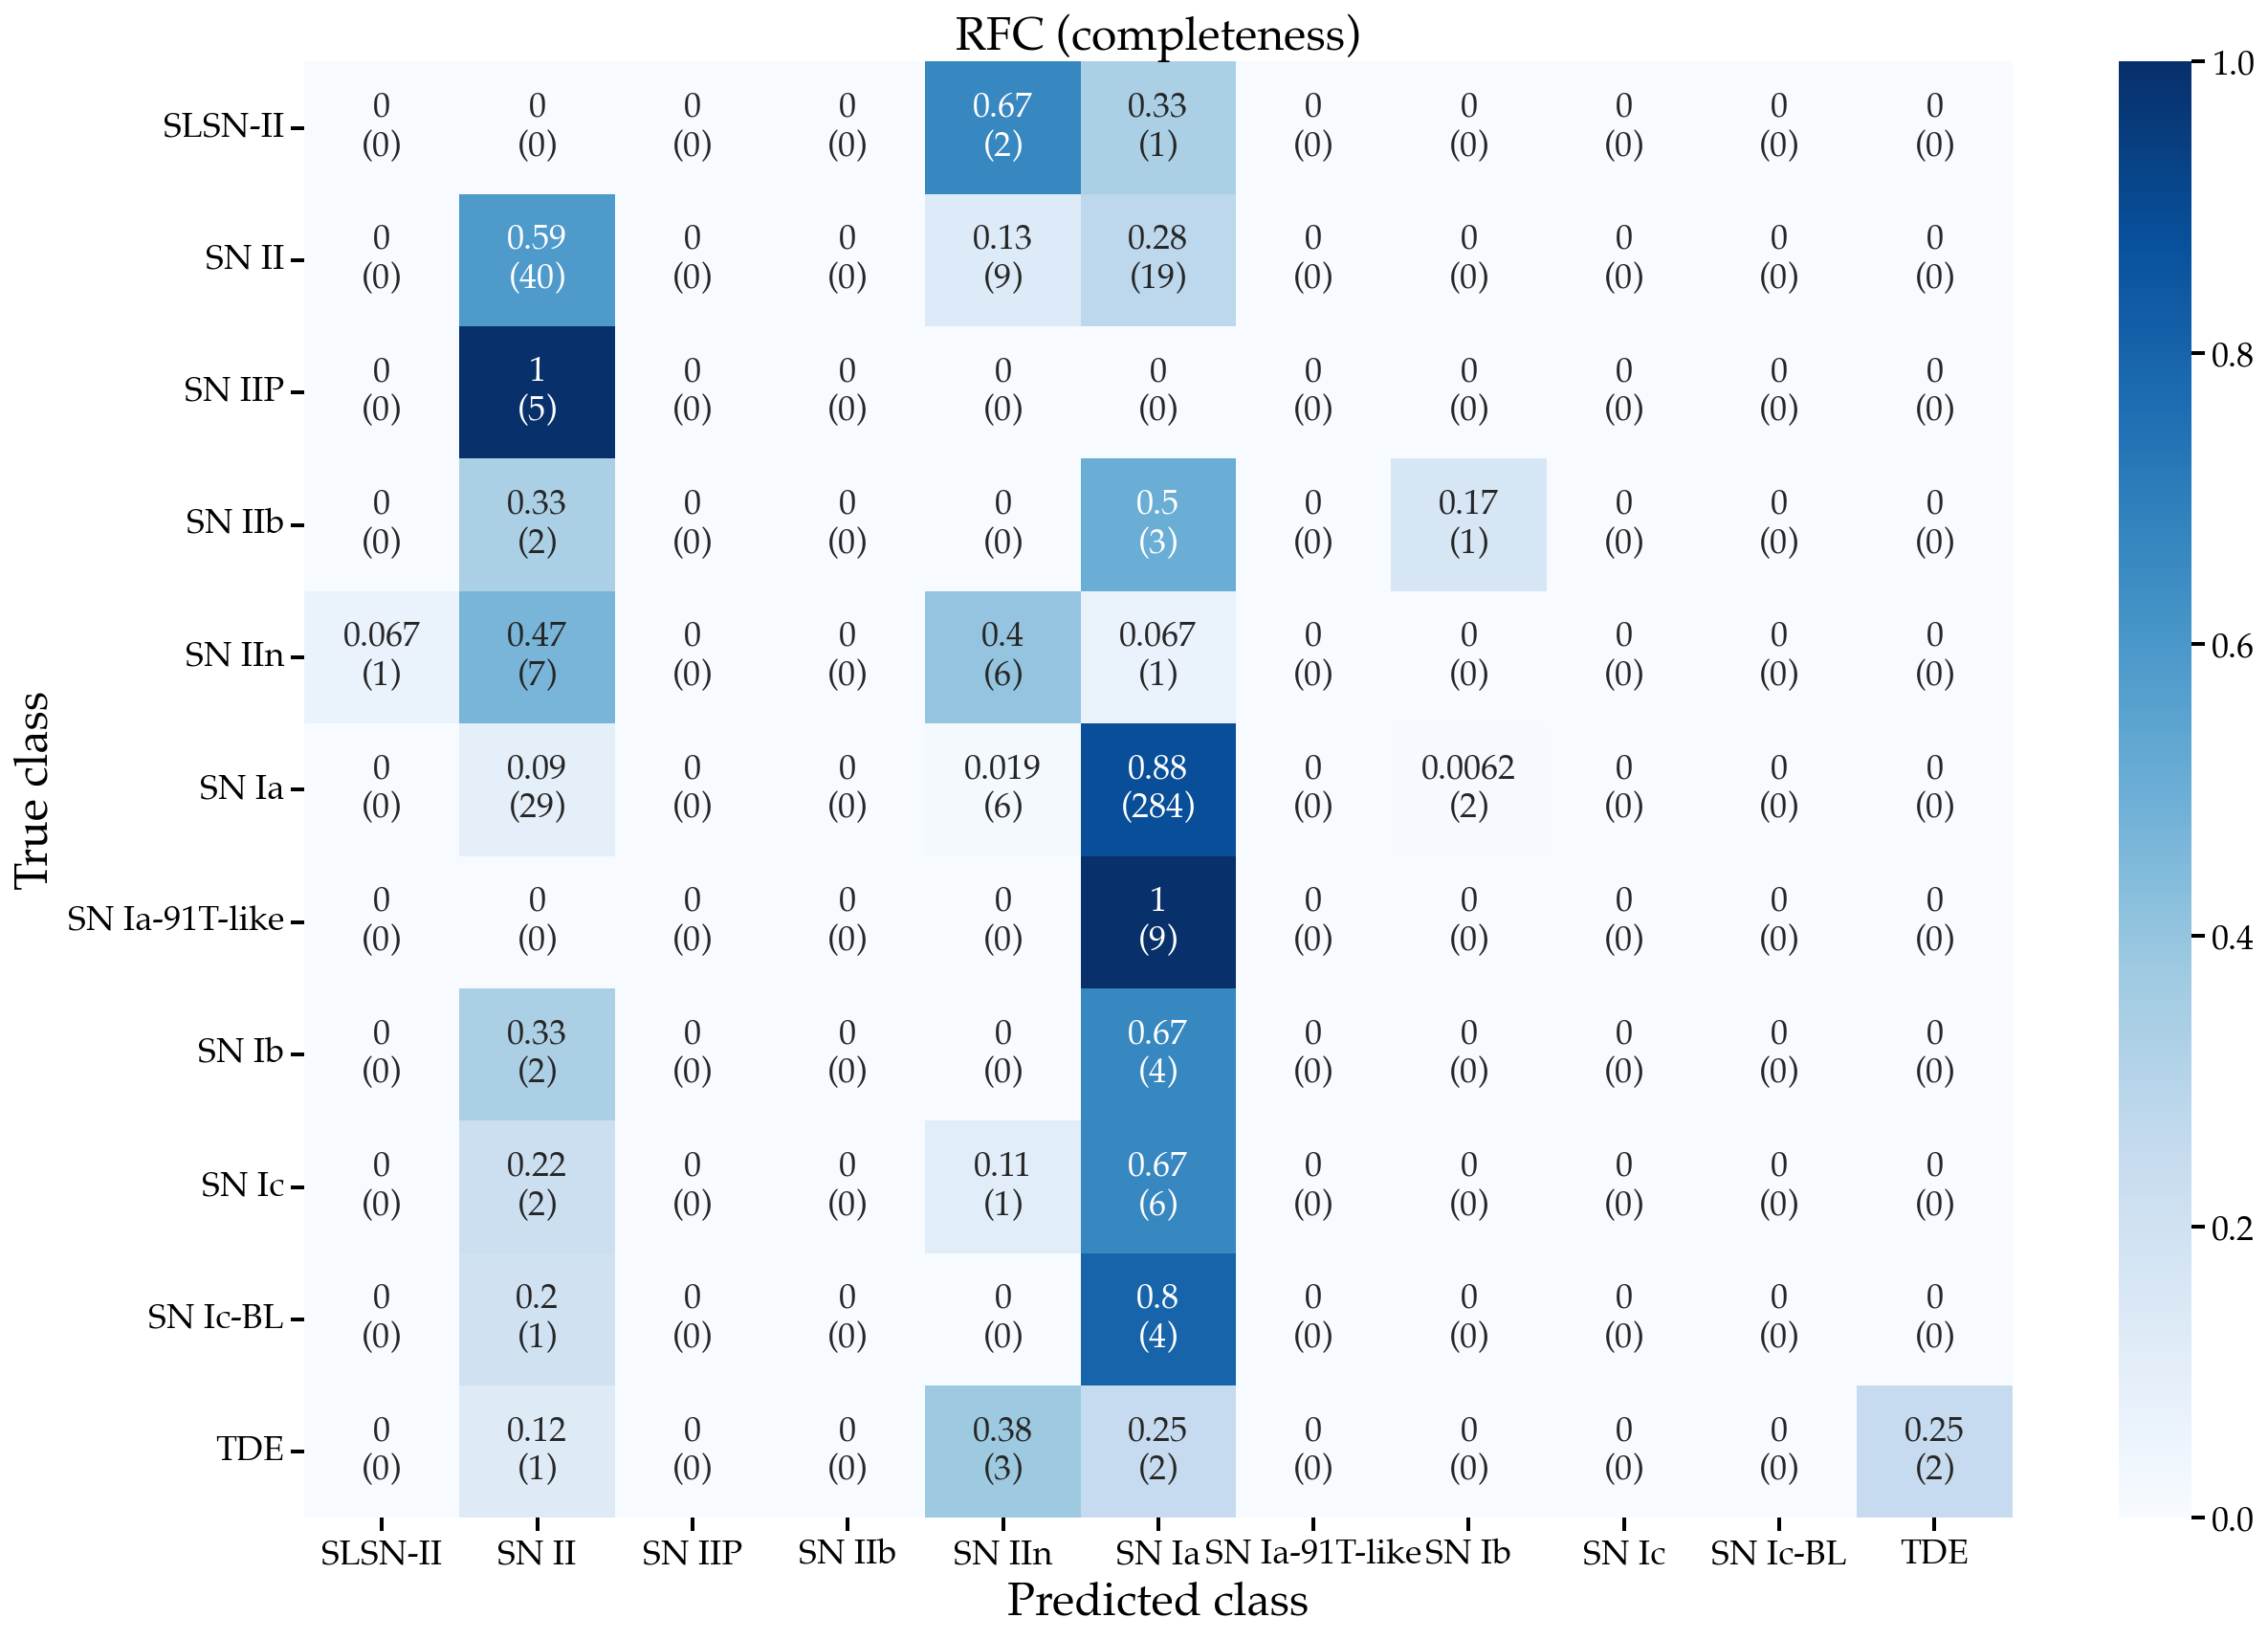

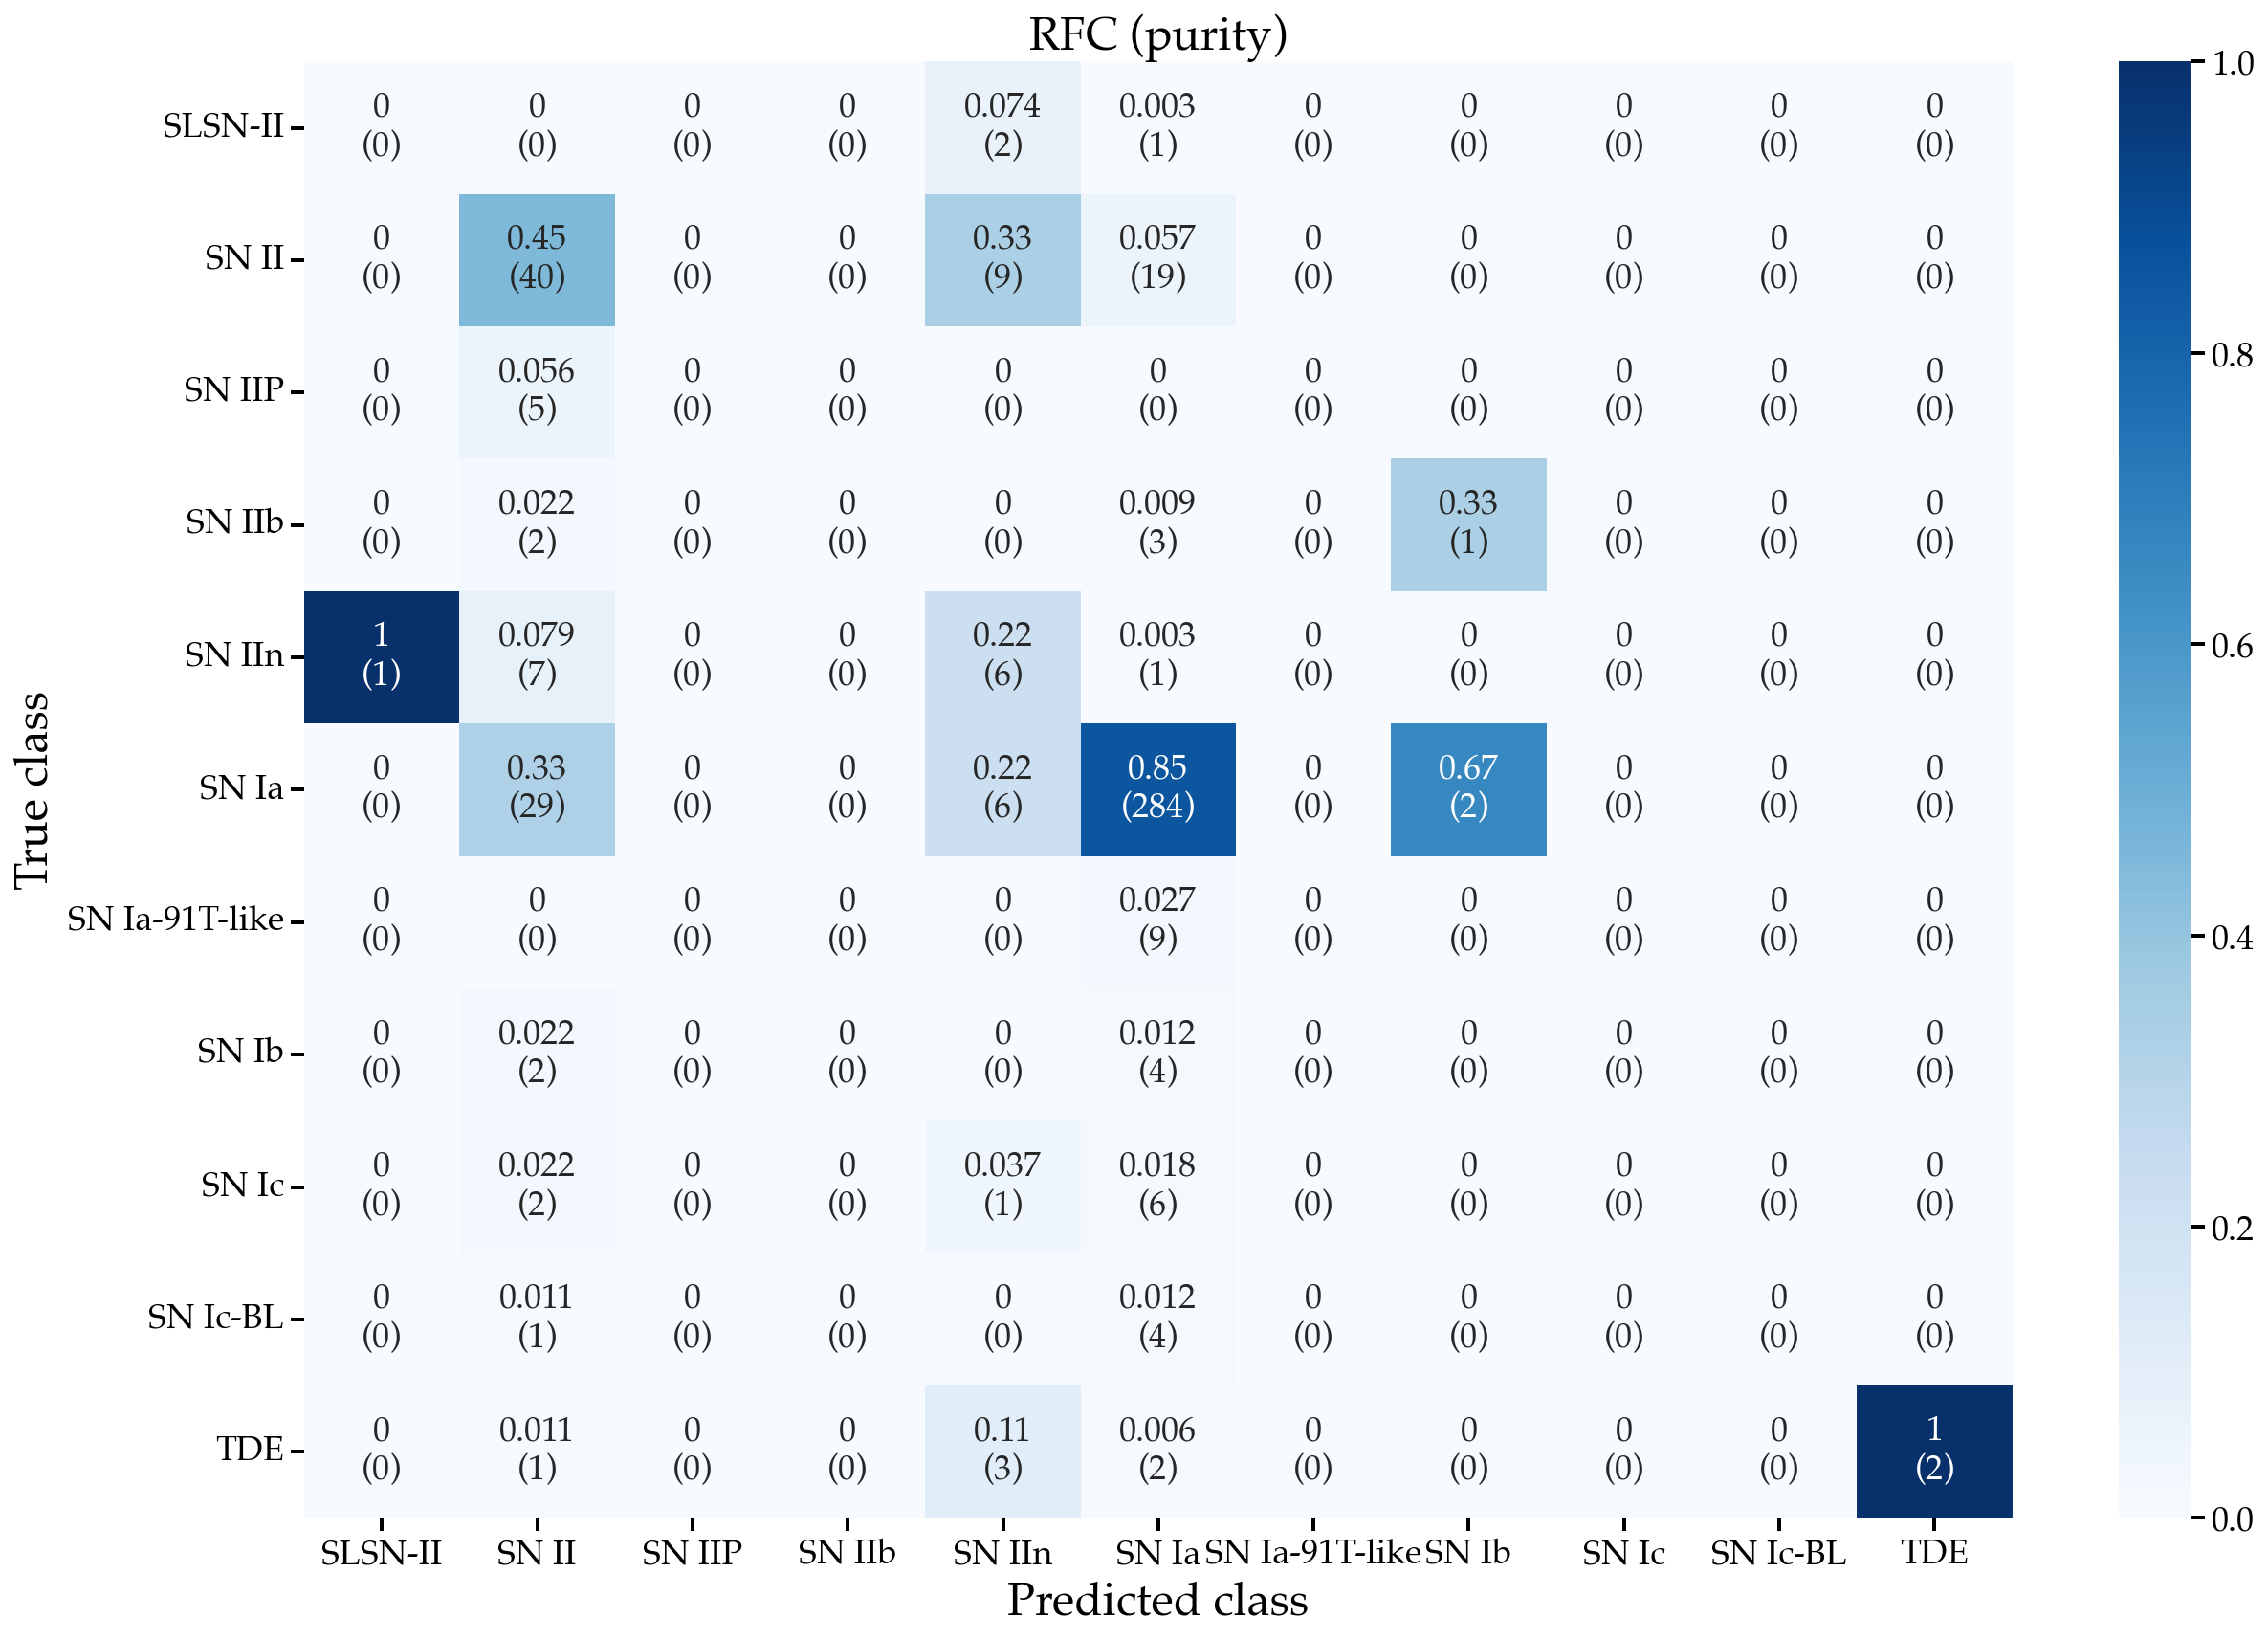

In [22]:
# Confusion matrices
title='RFC'
df = df2
true_labels = np.array(df['tns_cls'])
predicted_labels = np.array(df['RFC_best_cls'])#np.array(df['most_common_cls_ann=1-100']) # np.array(df['ann=1_tns_cls'])
# define the class labels
class_names = np.unique(true_labels)
nclasses = len(class_names)

#folder_path = f"../figures/confusion_matrix/{suffix}/grid_search_n_estimators={n_estimators}_max_depth={max_depth}_random_state={random_state}_max_features={max_features}_class_weight=1-1_noNoneCls/"
#if not os.path.exists(folder_path):
#    os.makedirs(folder_path)

KINDS = ['completeness', 'purity']
for KIND in KINDS:
    # Sims test set
    plot_conf_matrix(true_labels, predicted_labels, labels=class_names, 
             title=f'{title} ({KIND})', kind=KIND)
    #plt.savefig(f'{folder_path}/confmatrix_nclasses={nclasses}_noNone_{title}_{KIND}.jpg', dpi=300, bbox_inches='tight')
    plt.show()
    plt.close()

In [23]:
sim_class_di = {'CV': 'CV', 
      'SLSN-I': 'SLSN', 
      'SLSN-II': 'SLSN', 
      'SN II': 'SN II', 
      'SN IIP': 'SN II', 
      'SN IIb': 'SN II', 
      'SN IIn': 'SN II',
      'SN Ia': 'SN Ia', 
      'SN Ia-91T-like': 'SN Ia', 
      'SN Ia-pec': 'SN Ia', 
      'SN Ia-CSM': 'SN Ia',
      'SN Ia-91bg-like': 'SN Ia',
      'SN Ib': 'SN Ibc', 
      'SN Ib/c': 'SN Ibc',
      'SN Ibn': 'SN Ibc', 
      'SN Ic': 'SN Ibc',
      'SN Ic-BL': 'SN Ibc', 
      'TDE': 'TDE',
      'None': 'None',
      'SN': 'SN',
      'SN I': 'SN I',
      'Other': 'Other',
      'AGN': 'AGN'}

ann0_ann1_df_noNone_sim_class = df2.copy()
ann0_ann1_df_noNone_sim_class['tns_cls'] = ann0_ann1_df_noNone_sim_class['tns_cls'].map(sim_class_di)
ann0_ann1_df_noNone_sim_class['RFC_best_cls'] = ann0_ann1_df_noNone_sim_class['RFC_best_cls'].map(sim_class_di)
#ann0_ann1_df_noNone_sim_class['most_common_cls_ann=1-100'] = ann0_ann1_df_noNone_sim_class['most_common_cls_ann=1-100'].map(sim_class_di)

In [24]:
ann0_ann1_df_noNone_sim_class

feature_amplitude_magn_r  \
ztf_object_id                             
ZTF21aazebgh                   0.401764   
ZTF21acgxypn                   0.541942   
ZTF19aapqqrb                   0.143625   
ZTF21aasbxng                   0.943869   
ZTF21aaglgcb                   0.775517   
...                                 ...   
ZTF21acdalyp                   1.061692   
ZTF21abdcauj                   0.633349   
ZTF21aaetnfe                   1.442822   
ZTF21acgzwsc                   0.698412   
ZTF21aatklhw                   0.772630   

               feature_anderson_darling_normal_magn_r  \
ztf_object_id                                           
ZTF21aazebgh                                 0.347613   
ZTF21acgxypn                                 0.743175   
ZTF19aapqqrb                                 0.195803   
ZTF21aasbxng                                 0.500271   
ZTF21aaglgcb                                 0.484212   
...                                               ...   
ZTF21acdalyp                                 0.242709   
ZTF21abdcauj                                 0.322944   
ZTF21aaetnfe                                 1.007647   
ZTF21acgzwsc                                 0.256419   
ZTF21aatklhw                                 0.303856   

               feature_beyond_1_std_magn_r  feature_beyond_2_std_magn_r  \
ztf_object_id                                                             
ZTF21aazebgh                      0.454545                     0.000000   
ZTF21acgxypn                      0.200000                     0.000000   
ZTF19aapqqrb                      0.428571                     0.000000   
ZTF21aasbxng                      0.266667                     0.066667   
ZTF21aaglgcb                      0.363636                     0.090909   
...                                    ...                          ...   
ZTF21acdalyp                      0.357143                     0.071429   
ZTF21abdcauj                      0.400000                     0.000000   
ZTF21aaetnfe                      0.380952                     0.000000   
ZTF21acgzwsc                      0.333333                     0.000000   
ZTF21aatklhw                      0.384615                     0.000000   

               feature_cusum_magn_r  feature_inter_percentile_range_2_magn_r  \
ztf_object_id                                                                  
ZTF21aazebgh               0.412583                                 0.803528   
ZTF21acgxypn               0.395337                                 1.083883   
ZTF19aapqqrb               0.380133                                 0.287251   
ZTF21aasbxng               0.355580                                 1.887737   
ZTF21aaglgcb               0.388404                                 1.551035   
...                             ...                                      ...   
ZTF21acdalyp               0.375832                                 2.123384   
ZTF21abdcauj               0.419177                                 1.266699   
ZTF21aaetnfe               0.455937                                 2.885643   
ZTF21acgzwsc               0.373687                                 1.396824   
ZTF21aatklhw               0.387778                                 1.545259   

               feature_inter_percentile_range_10_magn_r  \
ztf_object_id                                             
ZTF21aazebgh                                   0.769645   
ZTF21acgxypn                                   0.948133   
ZTF19aapqqrb                                   0.271332   
ZTF21aasbxng                                   1.566141   
ZTF21aaglgcb                                   1.241484   
...                                                 ...   
ZTF21acdalyp                                   1.597695   
ZTF21abdcauj                                   0.828672   
ZTF21aaetnfe                                   2.600447   
ZTF21acgzwsc                                   

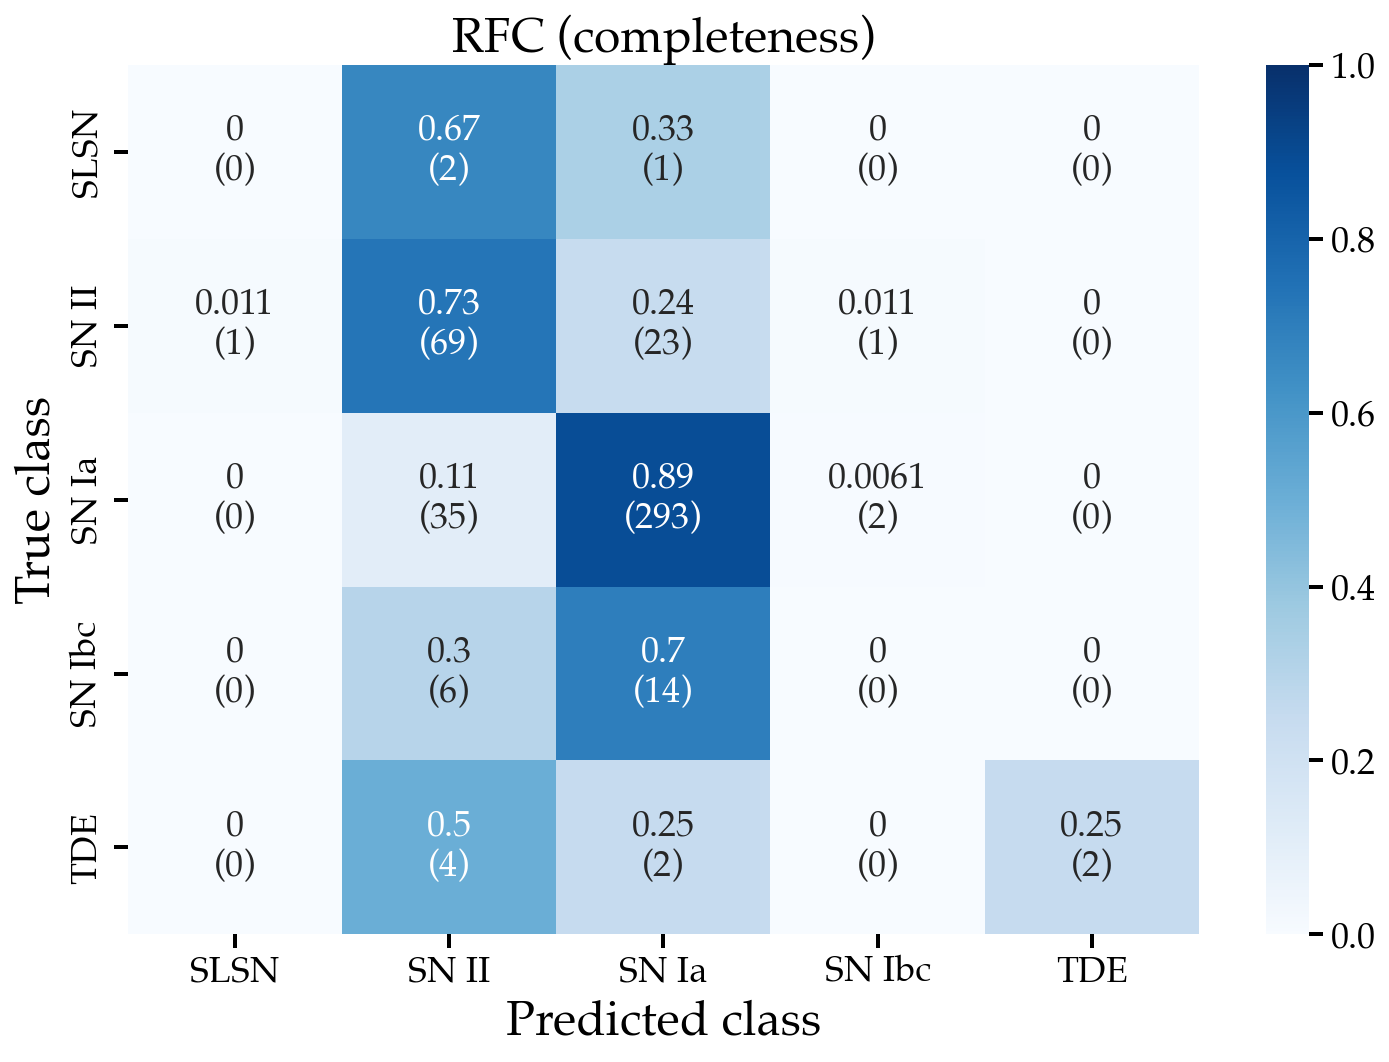

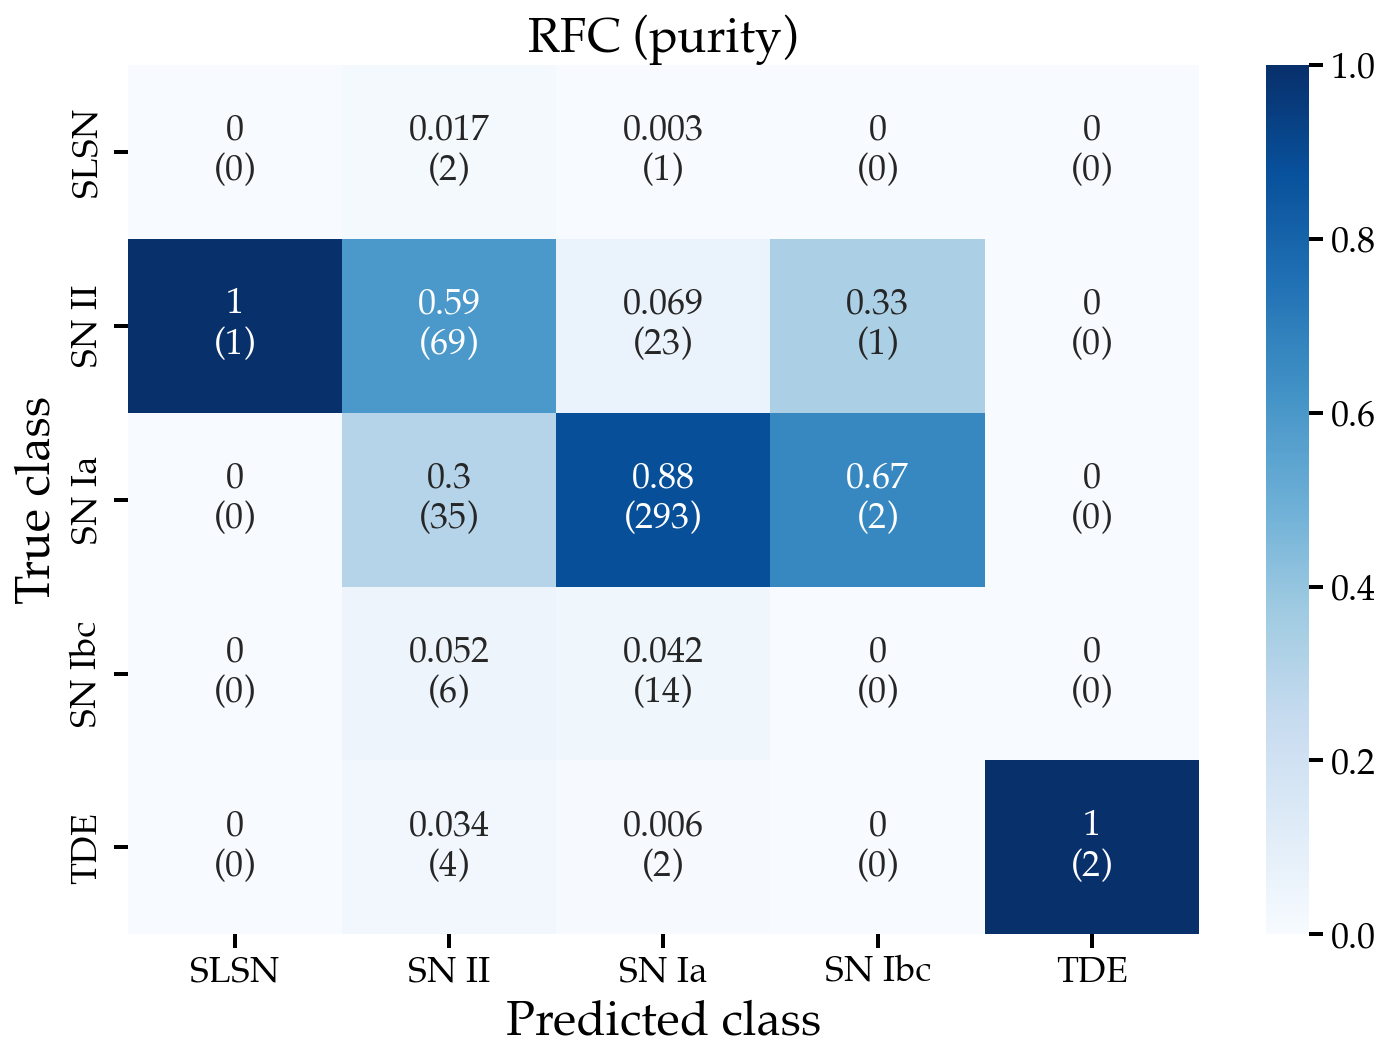

In [25]:
# Confusion matrices
df = ann0_ann1_df_noNone_sim_class
true_labels = np.array(df['tns_cls'])
predicted_labels = np.array(df['RFC_best_cls'])#np.array(df['most_common_cls_ann=1-100']) # np.array(df['ann=1_tns_cls'])
# define the class labels
class_names = np.unique(true_labels)
nclasses = len(class_names)

KINDS = ['completeness', 'purity']
for KIND in KINDS:
    # Sims test set
    plot_conf_matrix(true_labels, predicted_labels, labels=class_names, 
             title=f'{title} ({KIND})', kind=KIND, figsize=(12, 8))
    #plt.savefig(f'{folder_path}/confmatrix_nclasses={nclasses}_noNone_similar_class_{title}_{KIND}.jpg', dpi=300, bbox_inches='tight')
    plt.show()
    plt.close()

In [26]:
### CC vs Ia vs Exotic (TDE, SLSN)

bin_class_di = {'CV': 'CV', 
      'SLSN-I': 'Exotic', 
      'SLSN-II': 'Exotic', 
      'SN II': 'SN CC', 
      'SN IIP': 'SN CC', 
      'SN IIb': 'SN CC', 
      'SN IIn': 'SN CC',
      'SN Ia': 'SN Ia', 
      'SN Ia-91T-like': 'SN Ia', 
      'SN Ia-pec': 'SN Ia', 
      'SN Ia-CSM': 'SN Ia',
      'SN Ia-91bg-like': 'SN Ia',
      'SN Ib': 'SN CC', 
      'SN Ib/c': 'SN CC',
      'SN Ibn': 'SN CC', 
      'SN Ic': 'SN CC',
      'SN Ic-BL': 'SN CC', 
      'TDE': 'Exotic',
      'None': 'None',
      'SN': 'Other',
      'SN I': 'Other',
      'Other': 'Other',
      'AGN': 'AGN'}

ann0_ann1_df_noNone_bin_class = df2.copy()
ann0_ann1_df_noNone_bin_class['tns_cls'] = ann0_ann1_df_noNone_bin_class['tns_cls'].map(bin_class_di)
ann0_ann1_df_noNone_bin_class['RFC_best_cls'] = ann0_ann1_df_noNone_bin_class['RFC_best_cls'].map(bin_class_di)
#ann0_ann1_df_noNone_bin_class['most_common_cls_ann=1-100'] = ann0_ann1_df_noNone_bin_class['most_common_cls_ann=1-100'].map(bin_class_di)

In [27]:
mask = (ann0_ann1_df_noNone_bin_class['tns_cls'] != 'AGN') & (ann0_ann1_df_noNone_bin_class['tns_cls'] != 'CV') & (ann0_ann1_df_noNone_bin_class['tns_cls'] != 'Other')
ann0_ann1_df_noNone_bin_class = ann0_ann1_df_noNone_bin_class[mask]
ann0_ann1_df_noNone_bin_class

feature_amplitude_magn_r  \
ztf_object_id                             
ZTF21aazebgh                   0.401764   
ZTF21acgxypn                   0.541942   
ZTF19aapqqrb                   0.143625   
ZTF21aasbxng                   0.943869   
ZTF21aaglgcb                   0.775517   
...                                 ...   
ZTF21acdalyp                   1.061692   
ZTF21abdcauj                   0.633349   
ZTF21aaetnfe                   1.442822   
ZTF21acgzwsc                   0.698412   
ZTF21aatklhw                   0.772630   

               feature_anderson_darling_normal_magn_r  \
ztf_object_id                                           
ZTF21aazebgh                                 0.347613   
ZTF21acgxypn                                 0.743175   
ZTF19aapqqrb                                 0.195803   
ZTF21aasbxng                                 0.500271   
ZTF21aaglgcb                                 0.484212   
...                                               ...   
ZTF21acdalyp                                 0.242709   
ZTF21abdcauj                                 0.322944   
ZTF21aaetnfe                                 1.007647   
ZTF21acgzwsc                                 0.256419   
ZTF21aatklhw                                 0.303856   

               feature_beyond_1_std_magn_r  feature_beyond_2_std_magn_r  \
ztf_object_id                                                             
ZTF21aazebgh                      0.454545                     0.000000   
ZTF21acgxypn                      0.200000                     0.000000   
ZTF19aapqqrb                      0.428571                     0.000000   
ZTF21aasbxng                      0.266667                     0.066667   
ZTF21aaglgcb                      0.363636                     0.090909   
...                                    ...                          ...   
ZTF21acdalyp                      0.357143                     0.071429   
ZTF21abdcauj                      0.400000                     0.000000   
ZTF21aaetnfe                      0.380952                     0.000000   
ZTF21acgzwsc                      0.333333                     0.000000   
ZTF21aatklhw                      0.384615                     0.000000   

               feature_cusum_magn_r  feature_inter_percentile_range_2_magn_r  \
ztf_object_id                                                                  
ZTF21aazebgh               0.412583                                 0.803528   
ZTF21acgxypn               0.395337                                 1.083883   
ZTF19aapqqrb               0.380133                                 0.287251   
ZTF21aasbxng               0.355580                                 1.887737   
ZTF21aaglgcb               0.388404                                 1.551035   
...                             ...                                      ...   
ZTF21acdalyp               0.375832                                 2.123384   
ZTF21abdcauj               0.419177                                 1.266699   
ZTF21aaetnfe               0.455937                                 2.885643   
ZTF21acgzwsc               0.373687                                 1.396824   
ZTF21aatklhw               0.387778                                 1.545259   

               feature_inter_percentile_range_10_magn_r  \
ztf_object_id                                             
ZTF21aazebgh                                   0.769645   
ZTF21acgxypn                                   0.948133   
ZTF19aapqqrb                                   0.271332   
ZTF21aasbxng                                   1.566141   
ZTF21aaglgcb                                   1.241484   
...                                                 ...   
ZTF21acdalyp                                   1.597695   
ZTF21abdcauj                                   0.828672   
ZTF21aaetnfe                                   2.600447   
ZTF21acgzwsc                                   

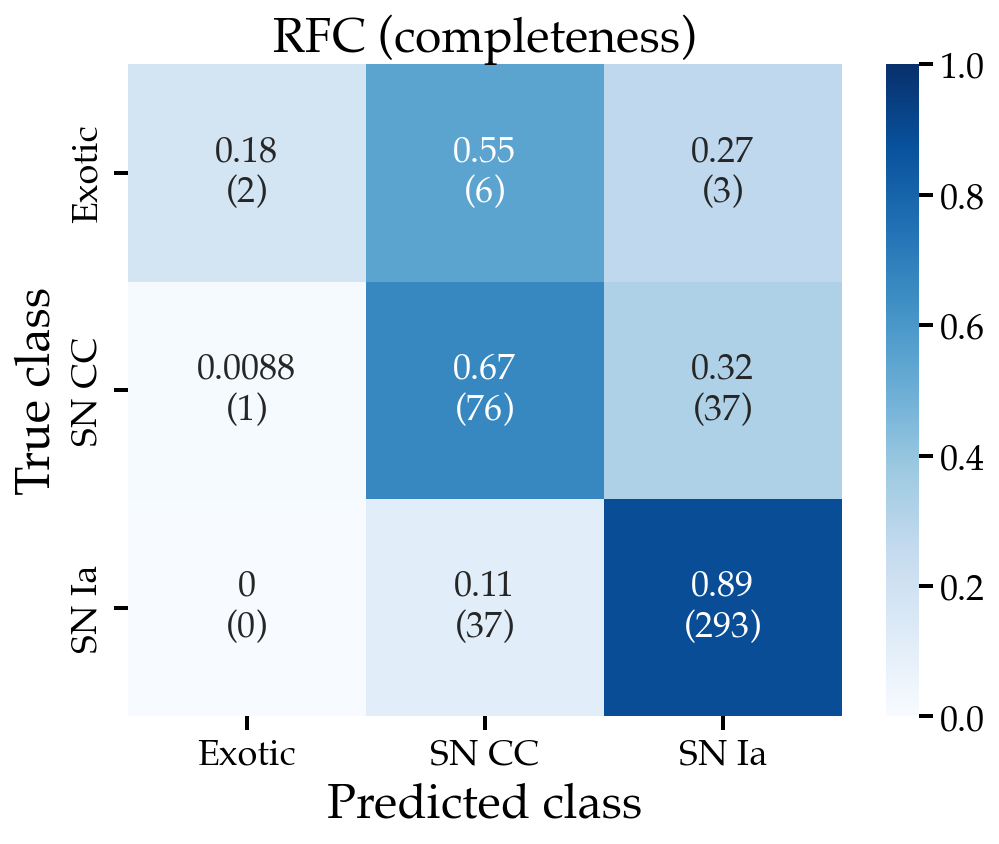

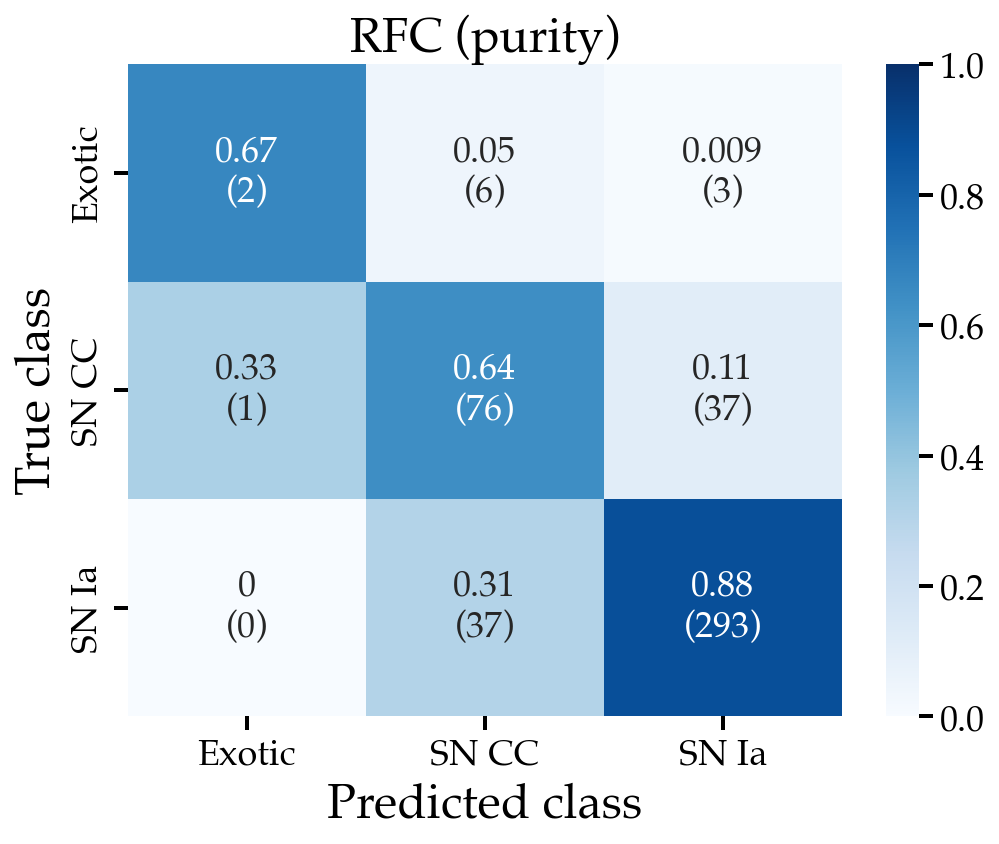

In [28]:
# Confusion matrices
df = ann0_ann1_df_noNone_bin_class
true_labels = np.array(df['tns_cls'])
predicted_labels = np.array(df['RFC_best_cls'])#np.array(df['most_common_cls_ann=1-100']) # np.array(df['ann=1_tns_cls'])
# define the class labels
class_names = np.unique(true_labels)
nclasses = len(class_names)

KINDS = ['completeness', 'purity']
for KIND in KINDS:
    # Sims test set
    plot_conf_matrix(true_labels, predicted_labels, labels=class_names, 
             title=f'{title} ({KIND})', kind=KIND, figsize=(8, 6))
    #plt.savefig(f'{folder_path}/confmatrix_nclasses={nclasses}_noNone_binary_class_{title}_{KIND}.jpg', dpi=300, bbox_inches='tight')
    plt.show()
    plt.close()

## Remember, the Ia here are Ia and rare Ia subtypes. Results w/o redshift too! And only 2 pbs

In [29]:
rare_v_not_class_di = {'CV': 'Not SN', 
      'SLSN-I': 'Rare', 
      'SLSN-II': 'Rare', 
      'SN II': 'NOT Rare', 
      'SN IIP': 'Rare', 
      'SN IIb': 'Rare', 
      'SN IIn': 'Rare',
      'SN Ia': 'NOT Rare', 
      'SN Ia-91T-like': 'NOT Rare', 
      'SN Ia-CSM': 'Rare',
      'SN Ia-91bg-like': 'NOT Rare',
      'SN Ia-pec': 'Rare', 
      'SN Ib': 'Rare', 
      'SN Ib/c': 'Rare',
      'SN Ibn': 'Rare',
      'SN Ic': 'Rare',
      'SN Ic-BL': 'Rare', 
      'TDE': 'Rare',
      'None': 'NOT Rare',
      'SN': 'Other',
      'SN I': 'Other',
      'Other': 'Other',
      'AGN': 'Not SN'}


ann0_ann1_df_noNone_rare_v_not_class = df2.copy()
ann0_ann1_df_noNone_rare_v_not_class['tns_cls'] = ann0_ann1_df_noNone_rare_v_not_class['tns_cls'].map(rare_v_not_class_di)
ann0_ann1_df_noNone_rare_v_not_class['RFC_best_cls'] = ann0_ann1_df_noNone_rare_v_not_class['RFC_best_cls'].map(rare_v_not_class_di)
#ann0_ann1_df_noNone_rare_v_not_class['most_common_cls_ann=1-100'] = ann0_ann1_df_noNone_rare_v_not_class['most_common_cls_ann=1-100'].map(rare_v_not_class_di)

In [30]:
mask = (ann0_ann1_df_noNone_rare_v_not_class['tns_cls'] != 'Not SN') & (ann0_ann1_df_noNone_rare_v_not_class['tns_cls'] != 'Other')
ann0_ann1_df_noNone_rare_v_not_class = ann0_ann1_df_noNone_rare_v_not_class[mask]
ann0_ann1_df_noNone_rare_v_not_class

feature_amplitude_magn_r  \
ztf_object_id                             
ZTF21aazebgh                   0.401764   
ZTF21acgxypn                   0.541942   
ZTF19aapqqrb                   0.143625   
ZTF21aasbxng                   0.943869   
ZTF21aaglgcb                   0.775517   
...                                 ...   
ZTF21acdalyp                   1.061692   
ZTF21abdcauj                   0.633349   
ZTF21aaetnfe                   1.442822   
ZTF21acgzwsc                   0.698412   
ZTF21aatklhw                   0.772630   

               feature_anderson_darling_normal_magn_r  \
ztf_object_id                                           
ZTF21aazebgh                                 0.347613   
ZTF21acgxypn                                 0.743175   
ZTF19aapqqrb                                 0.195803   
ZTF21aasbxng                                 0.500271   
ZTF21aaglgcb                                 0.484212   
...                                               ...   
ZTF21acdalyp                                 0.242709   
ZTF21abdcauj                                 0.322944   
ZTF21aaetnfe                                 1.007647   
ZTF21acgzwsc                                 0.256419   
ZTF21aatklhw                                 0.303856   

               feature_beyond_1_std_magn_r  feature_beyond_2_std_magn_r  \
ztf_object_id                                                             
ZTF21aazebgh                      0.454545                     0.000000   
ZTF21acgxypn                      0.200000                     0.000000   
ZTF19aapqqrb                      0.428571                     0.000000   
ZTF21aasbxng                      0.266667                     0.066667   
ZTF21aaglgcb                      0.363636                     0.090909   
...                                    ...                          ...   
ZTF21acdalyp                      0.357143                     0.071429   
ZTF21abdcauj                      0.400000                     0.000000   
ZTF21aaetnfe                      0.380952                     0.000000   
ZTF21acgzwsc                      0.333333                     0.000000   
ZTF21aatklhw                      0.384615                     0.000000   

               feature_cusum_magn_r  feature_inter_percentile_range_2_magn_r  \
ztf_object_id                                                                  
ZTF21aazebgh               0.412583                                 0.803528   
ZTF21acgxypn               0.395337                                 1.083883   
ZTF19aapqqrb               0.380133                                 0.287251   
ZTF21aasbxng               0.355580                                 1.887737   
ZTF21aaglgcb               0.388404                                 1.551035   
...                             ...                                      ...   
ZTF21acdalyp               0.375832                                 2.123384   
ZTF21abdcauj               0.419177                                 1.266699   
ZTF21aaetnfe               0.455937                                 2.885643   
ZTF21acgzwsc               0.373687                                 1.396824   
ZTF21aatklhw               0.387778                                 1.545259   

               feature_inter_percentile_range_10_magn_r  \
ztf_object_id                                             
ZTF21aazebgh                                   0.769645   
ZTF21acgxypn                                   0.948133   
ZTF19aapqqrb                                   0.271332   
ZTF21aasbxng                                   1.566141   
ZTF21aaglgcb                                   1.241484   
...                                                 ...   
ZTF21acdalyp                                   1.597695   
ZTF21abdcauj                                   0.828672   
ZTF21aaetnfe                                   2.600447   
ZTF21acgzwsc                                   

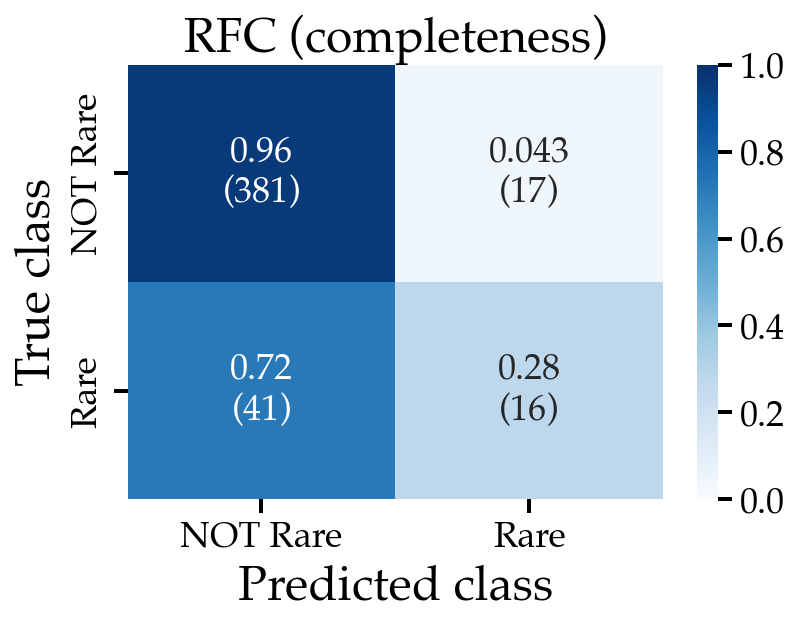

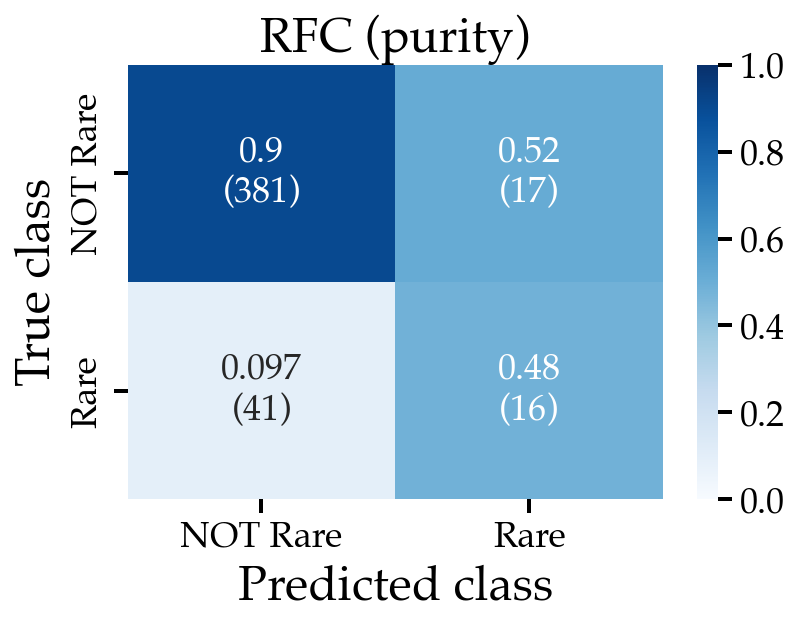

In [31]:
# Confusion matrices
df = ann0_ann1_df_noNone_rare_v_not_class
true_labels = np.array(df['tns_cls'])
predicted_labels = np.array(df['RFC_best_cls']) #np.array(df['most_common_cls_ann=1-100']) # np.array(df['ann=1_tns_cls'])
# define the class labels
class_names = np.unique(true_labels)
nclasses = len(class_names)

KINDS = ['completeness', 'purity']
for KIND in KINDS:
    # Sims test set
    plot_conf_matrix(true_labels, predicted_labels, labels=class_names, 
             title=f'{title} ({KIND})', kind=KIND, figsize=(6, 4))
    #plt.savefig(f'{folder_path}/confmatrix_nclasses={nclasses}_noNone_rare_v_not_class_{title}_{KIND}.jpg', dpi=300, bbox_inches='tight')
    plt.show()
    plt.close()

## Remember, the Ia here is Ia-norm ONLY. The rare Ia subtypes are in the "Rare" classification. Results w/o redshift too! And only 2 pbs

In [36]:
%%time 
# In summary, you train your Random Forest Classifier to classify your data, 
# and then use the Isolation Forest algorithm on the output probabilities of the Random Forest Classifier 
# to detect anomalies.

from sklearn.ensemble import IsolationForest

anomaly_scores = IsolationForest(n_estimators=500, 
                                random_state=10, 
                                contamination=0.25,
                                max_features=11, # 12 for with None cls
                                n_jobs=-1).fit(predicted_probability).decision_function(predicted_probability)

CPU times: user 982 ms, sys: 372 ms, total: 1.35 s
Wall time: 1.02 s


In [37]:
most_anomalous_indices = np.argsort(anomaly_scores)[:25]
most_anomalous_samples = df2.iloc[most_anomalous_indices]
most_anomalous_samples

feature_amplitude_magn_r  \
ztf_object_id                             
ZTF20aceokvr                   0.772009   
ZTF21abpyauz                   0.987303   
ZTF21acmnpqa                   0.670024   
ZTF21aautijg                   0.678457   
ZTF21abgkfzh                   0.441565   
ZTF21aapvvtb                   0.284339   
ZTF21aakigqr                   0.339321   
ZTF21aafmkjk                   0.671348   
ZTF20aatxryt                   1.710750   
ZTF20accrkpa                   0.704105   
ZTF21aaaalaf                   0.538359   
ZTF18acvgjqv                   1.061049   
ZTF21abplgag                   0.914167   
ZTF20achmmex                   0.469156   
ZTF21aadatfg                   1.009226   
ZTF21aahfjrr                   0.802070   
ZTF21aaabwfu                   0.726729   
ZTF20acwytxn                   1.056182   
ZTF21acgxypn                   0.541942   
ZTF20acnznms                   0.927183   
ZTF21abdahai                   0.597616   
ZTF21aaaadvr                   1.395056   
ZTF21abchjer                   0.913735   
ZTF21acjgmiy                   0.195485   
ZTF18acaqdaa                   0.964350   

               feature_anderson_darling_normal_magn_r  \
ztf_object_id                                           
ZTF20aceokvr                                 3.986711   
ZTF21abpyauz                                 1.645826   
ZTF21acmnpqa                                 0.165766   
ZTF21aautijg                                 2.020706   
ZTF21abgkfzh                                 0.789434   
ZTF21aapvvtb                                 0.247243   
ZTF21aakigqr                                 0.262226   
ZTF21aafmkjk                                 0.793086   
ZTF20aatxryt                                 0.856208   
ZTF20accrkpa                                 0.452696   
ZTF21aaaalaf                                 1.949543   
ZTF18acvgjqv                                 0.732289   
ZTF21abplgag                                 0.505741   
ZTF20achmmex                                 0.207091   
ZTF21aadatfg                                 0.273438   
ZTF21aahfjrr                                 1.489103   
ZTF21aaabwfu                                 0.344801   
ZTF20acwytxn                                 5.368489   
ZTF21acgxypn                                 0.743175   
ZTF20acnznms                                 0.978577   
ZTF21abdahai                                 0.894250   
ZTF21aaaadvr                                 3.868089   
ZTF21abchjer                                 0.840731   
ZTF21acjgmiy                                 0.345411   
ZTF18acaqdaa                                 0.948676   

               feature_beyond_1_std_magn_r  feature_beyond_2_std_magn_r  \
ztf_object_id                                                             
ZTF20aceokvr                      0.225000                     0.025000   
ZTF21abpyauz                      0.137931                     0.034483   
ZTF21acmnpqa                      0.400000                     0.000000   
ZTF21aautijg                      0.171429                     0.057143   
ZTF21abgkfzh                      0.294118                     0.088235   
ZTF21aapvvtb                      0.357143                     0.000000   
ZTF21aakigqr                      0.200000                     0.050000   
ZTF21aafmkjk                      0.234043                     0.042553   
ZTF20aatxryt                      0.305556                     0.055556   
ZTF20accrkpa                      0.388889                     0.000000   
ZTF21aaaalaf                      0.250000                     0.000000   
ZTF18acvgjqv                      0.375000                     0.031250   
ZTF21abplgag                      0.500000                     0.000000   
ZTF20achmmex                      0.346154                     0.038462   
ZTF21aadatfg                      0.307692                     0.000000   
ZTF21aahfjrr                      0.31

In [38]:
for obj, cls, rfc_cls in zip(most_anomalous_samples.index, most_anomalous_samples.tns_cls, most_anomalous_samples.RFC_best_cls):
    print(f"https://alerce.online/object/{obj}", cls, rfc_cls)

https://alerce.online/object/ZTF20aceokvr SN IIn SN IIP
https://alerce.online/object/ZTF21abpyauz SN II SN IIn
https://alerce.online/object/ZTF21acmnpqa SN Ia SN Ib
https://alerce.online/object/ZTF21aautijg SN IIn SLSN-II
https://alerce.online/object/ZTF21abgkfzh SN IIn SN IIn
https://alerce.online/object/ZTF21aapvvtb TDE TDE
https://alerce.online/object/ZTF21aakigqr SN II SN II
https://alerce.online/object/ZTF21aafmkjk SN IIn SN IIn
https://alerce.online/object/ZTF20aatxryt SN Ia SN IIn
https://alerce.online/object/ZTF20accrkpa SN II SN Ia
https://alerce.online/object/ZTF21aaaalaf SN Ia SN IIP
https://alerce.online/object/ZTF18acvgjqv SN IIn SLSN-II
https://alerce.online/object/ZTF21abplgag SN Ia SN Ic
https://alerce.online/object/ZTF20achmmex SN II SN II
https://alerce.online/object/ZTF21aadatfg SN Ic-BL SN Ia
https://alerce.online/object/ZTF21aahfjrr SN IIn SN IIn
https://alerce.online/object/ZTF21aaabwfu SN IIb SN Ib
https://alerce.online/object/ZTF20acwytxn TDE SN IIn
https://aler

In [39]:
# All long lived or big color difference

In [40]:
Counter(most_anomalous_samples['tns_cls'])

Counter({'SN IIn': 6,
         'SN II': 6,
         'SN Ia': 5,
         'TDE': 3,
         'SN Ic-BL': 3,
         'SN IIb': 1,
         'SLSN-II': 1})

In [41]:
Counter(most_anomalous_samples['RFC_best_cls'])

Counter({'SN IIP': 2,
         'SN IIn': 8,
         'SN Ib': 2,
         'SLSN-II': 2,
         'TDE': 1,
         'SN II': 6,
         'SN Ia': 3,
         'SN Ic': 1})

### Feature importance

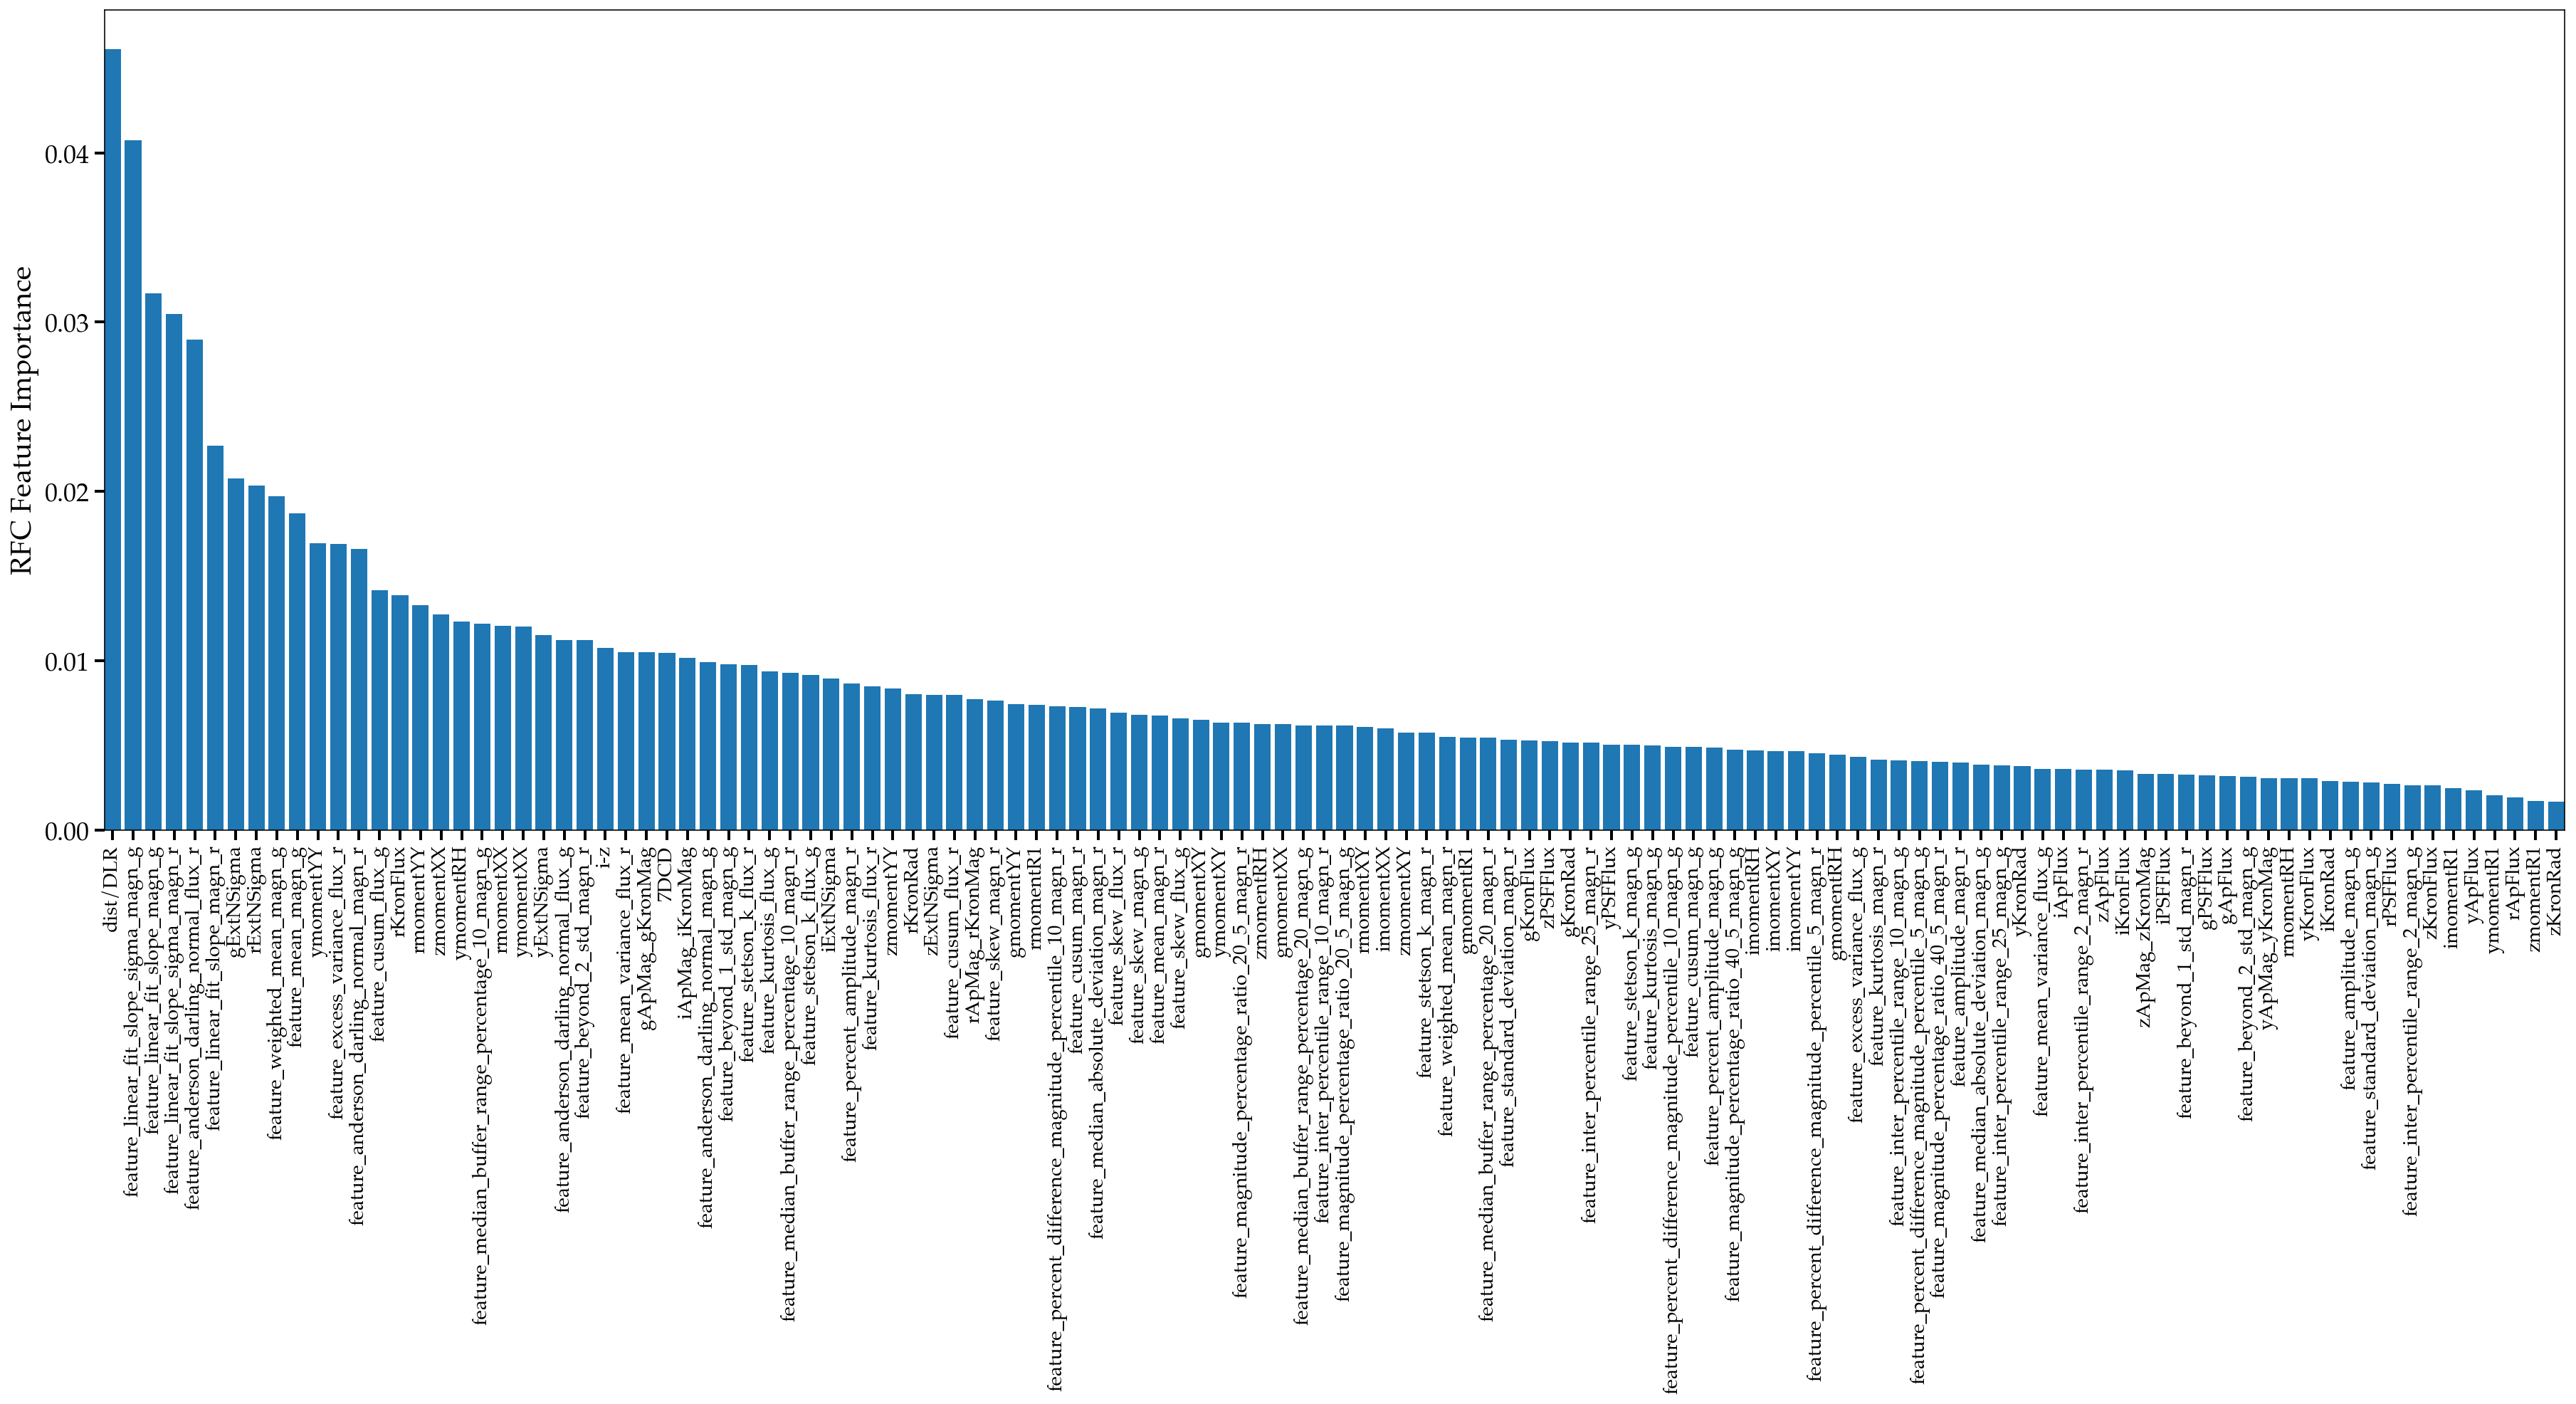

In [42]:
importances = clf.feature_importances_
indices = np.argsort(importances)[::-1]

X_train = dataset_bank_tns_df_resampled_train.iloc[:, 0:120]

fig, ax = plt.subplots(figsize=(24, 8))
ax.bar(range(X_train.shape[1]), importances[indices])
ax.set_xticks(range(X_train.shape[1]))
ax.set_xticklabels(X_train.columns[indices], rotation=90, fontsize=14)
plt.subplots_adjust(left=0.0, right=1, top=1.0, bottom=0)
ax.set_xlim(left=-0.40, right=119.4)
plt.ylabel('RFC Feature Importance')
plt.savefig(f'{folder_path}/RFC_feature_importance_horizontal.jpg', dpi=300, bbox_inches='tight')
plt.show()

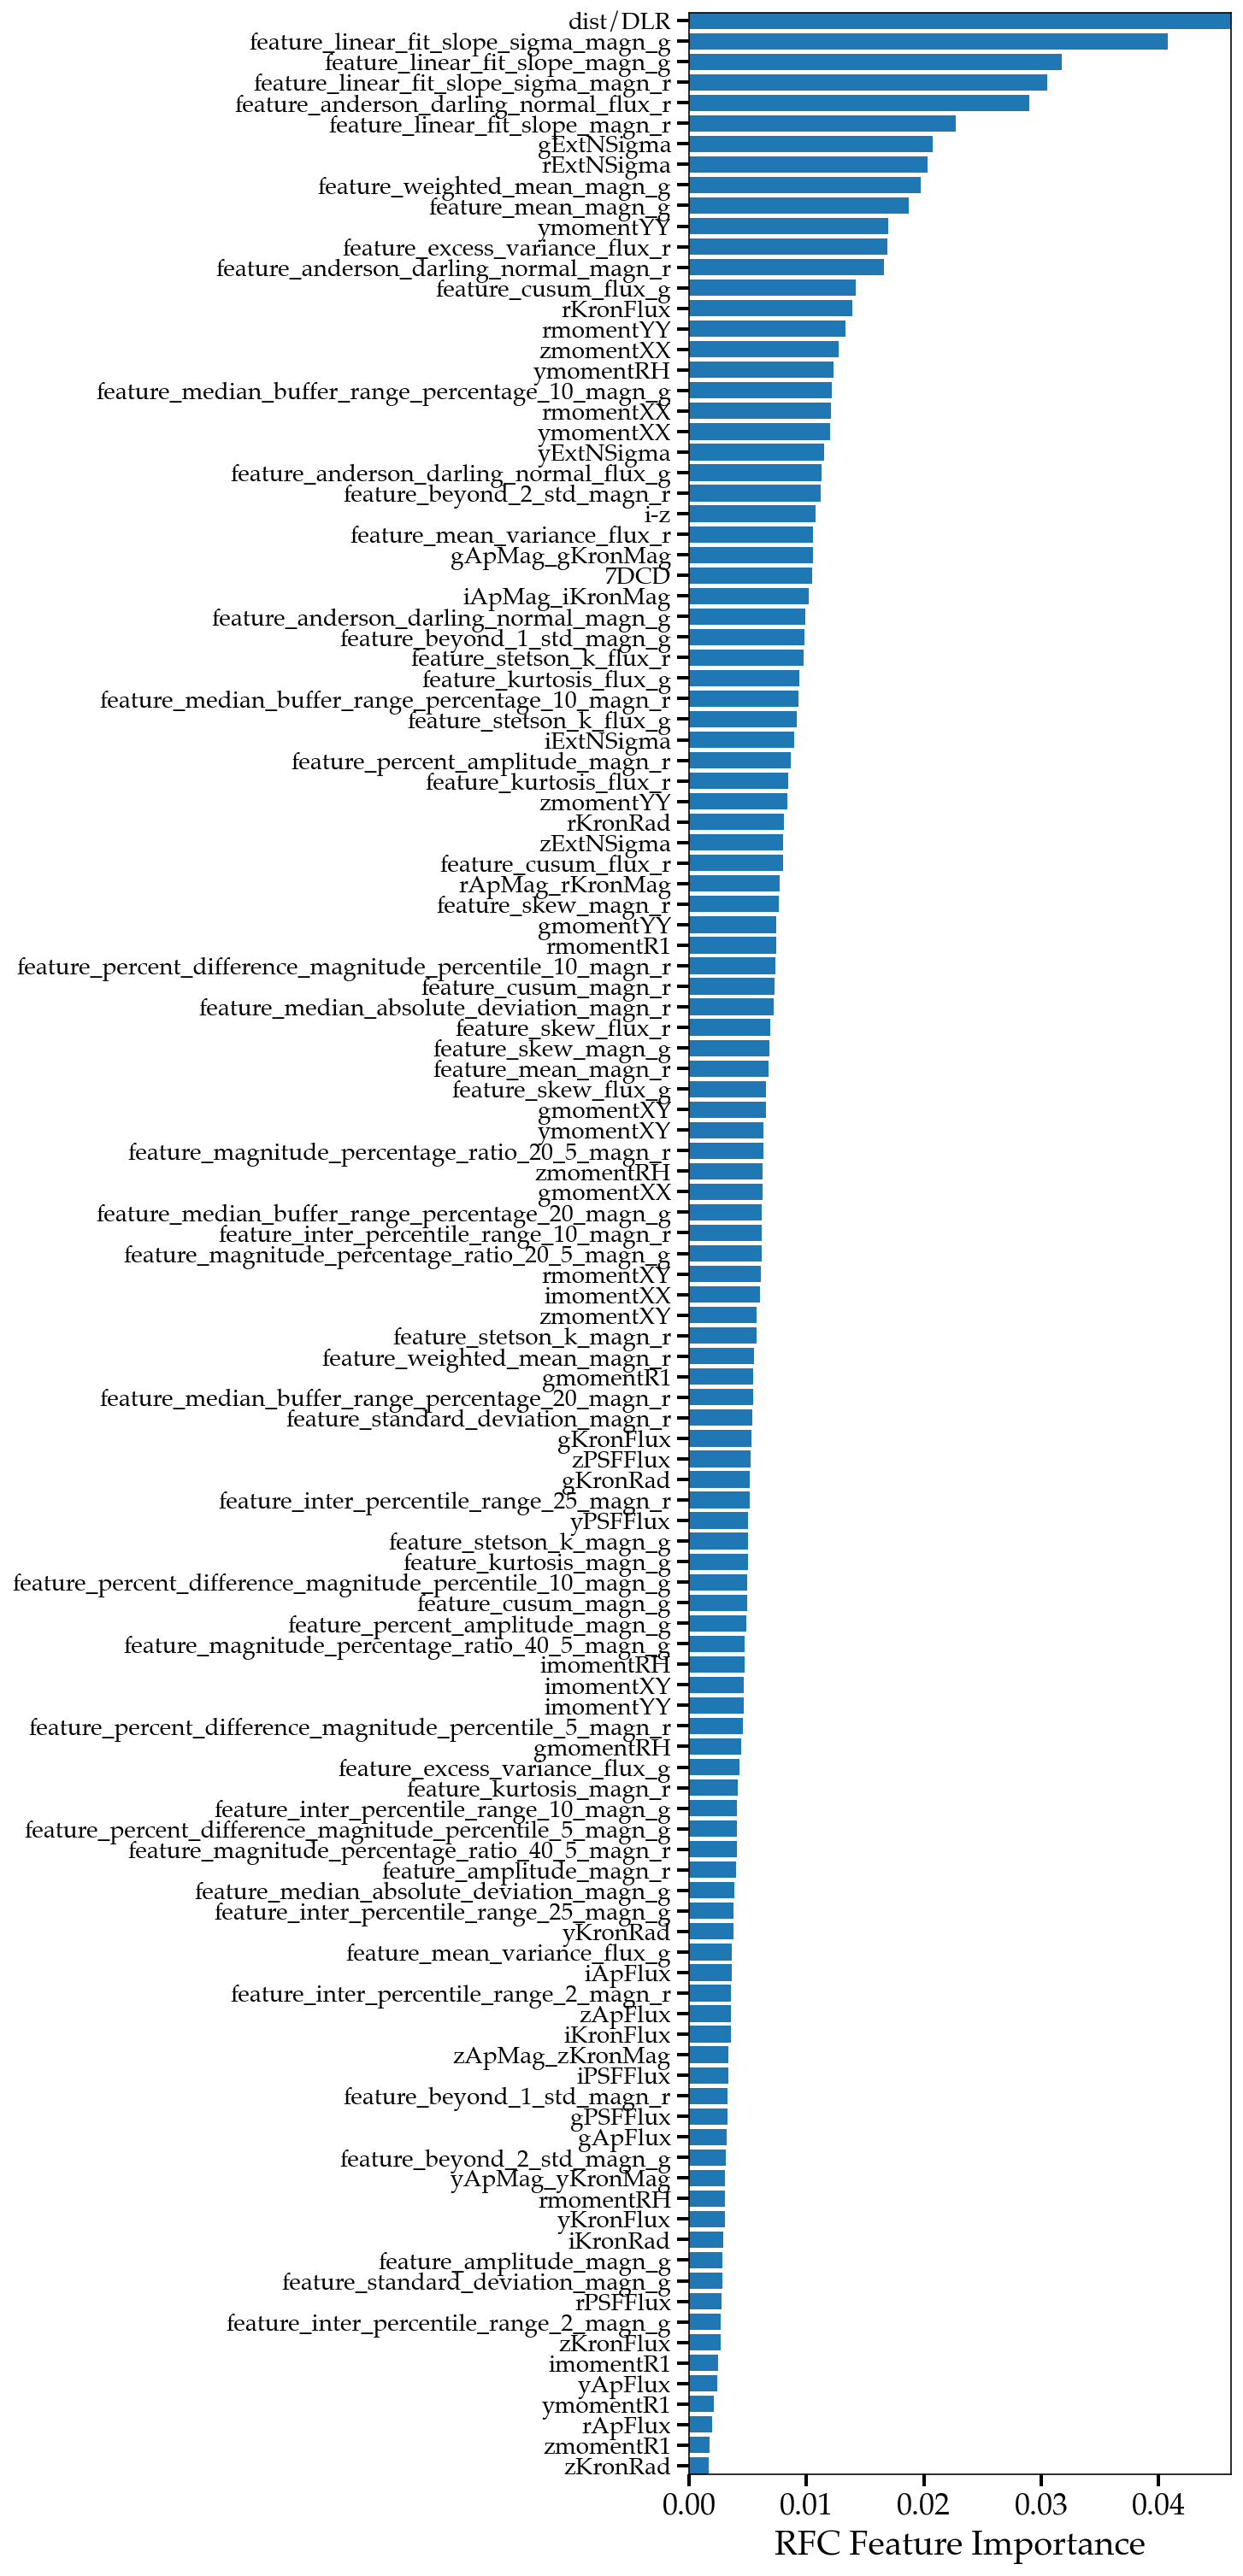

In [43]:
fig, ax = plt.subplots(figsize=(8, 20))
ax.barh(range(X_train.shape[1]), importances[indices][::-1])
ax.set_yticks(range(X_train.shape[1]))
ax.set_yticklabels(X_train.columns[indices][::-1], fontsize=14)
plt.subplots_adjust(left=0.4, right=0.95, top=1.0, bottom=0)
ax.set_ylim(top=119.4, bottom=-0.40)
ax.set_xlim(right=np.max(importances[indices][::-1]))
plt.xlabel('RFC Feature Importance')
plt.savefig(f'{folder_path}/RFC_feature_importance_vertical.jpg', dpi=300, bbox_inches='tight')
plt.show()

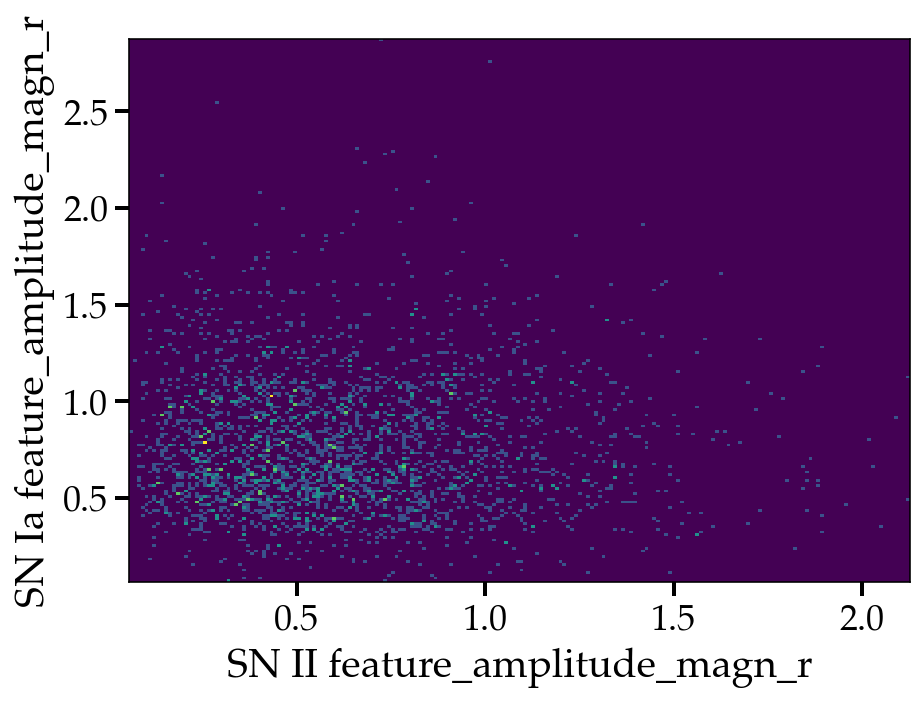

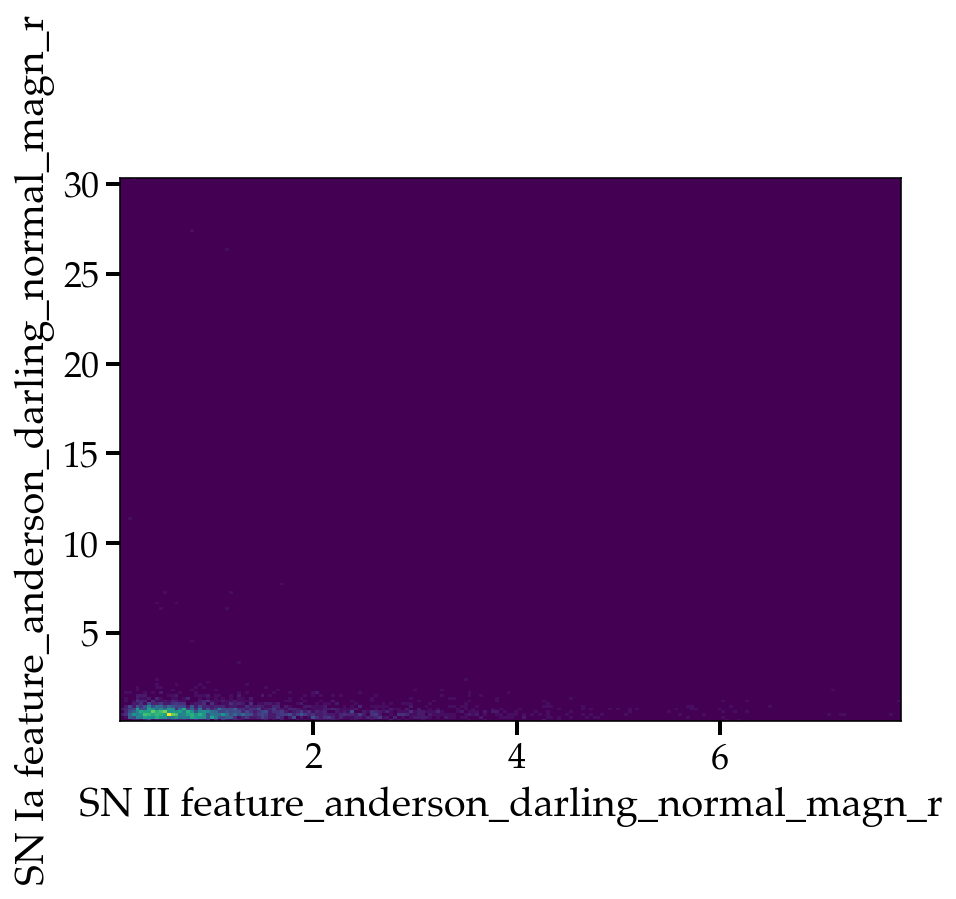

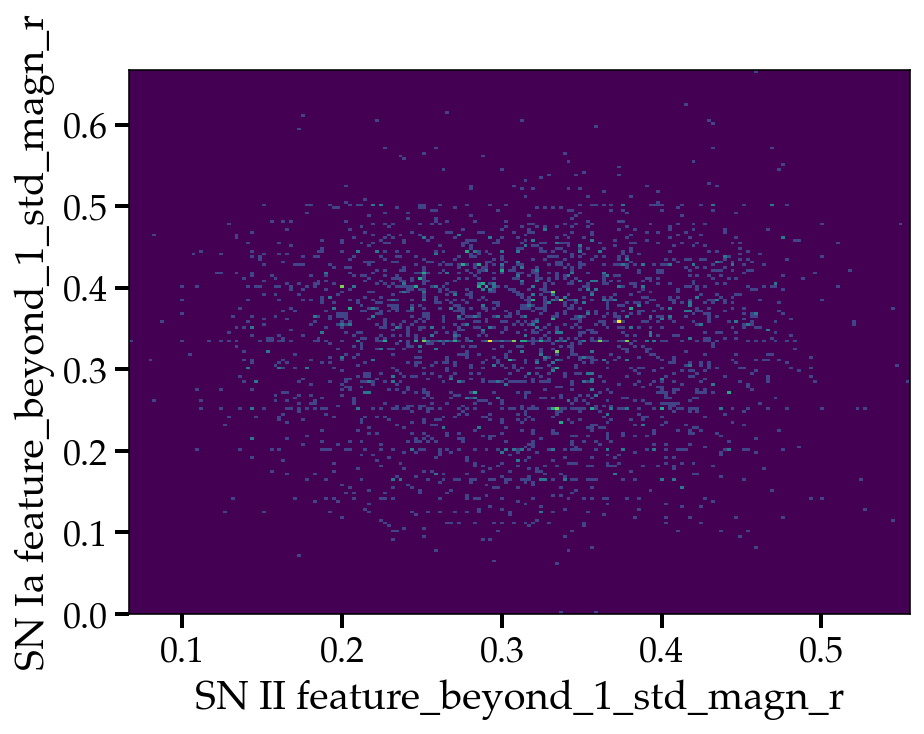

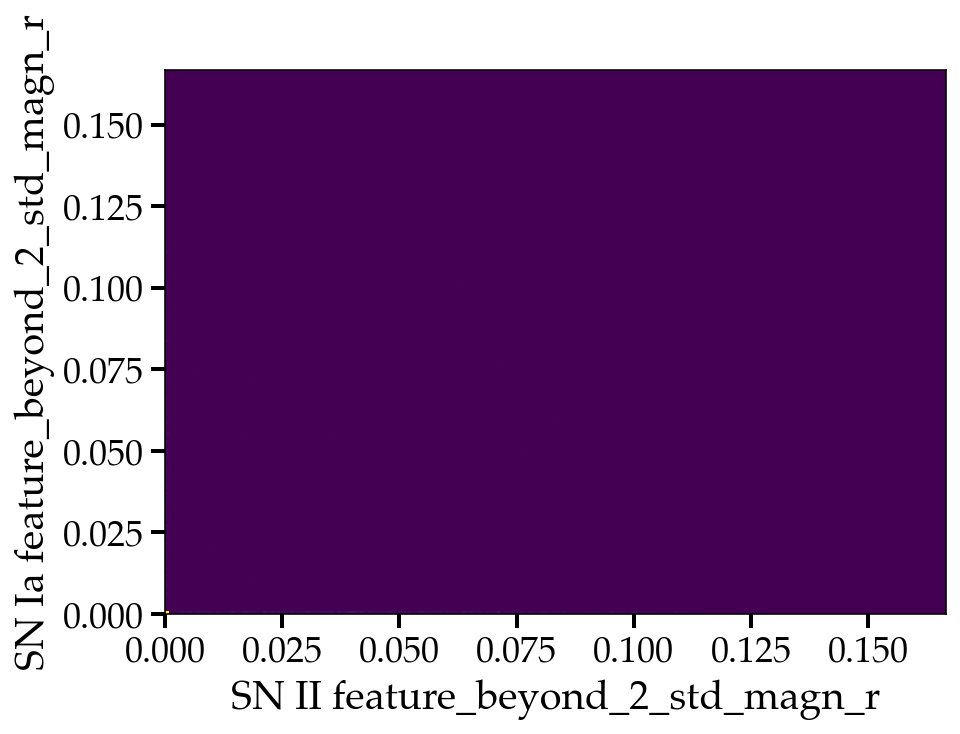

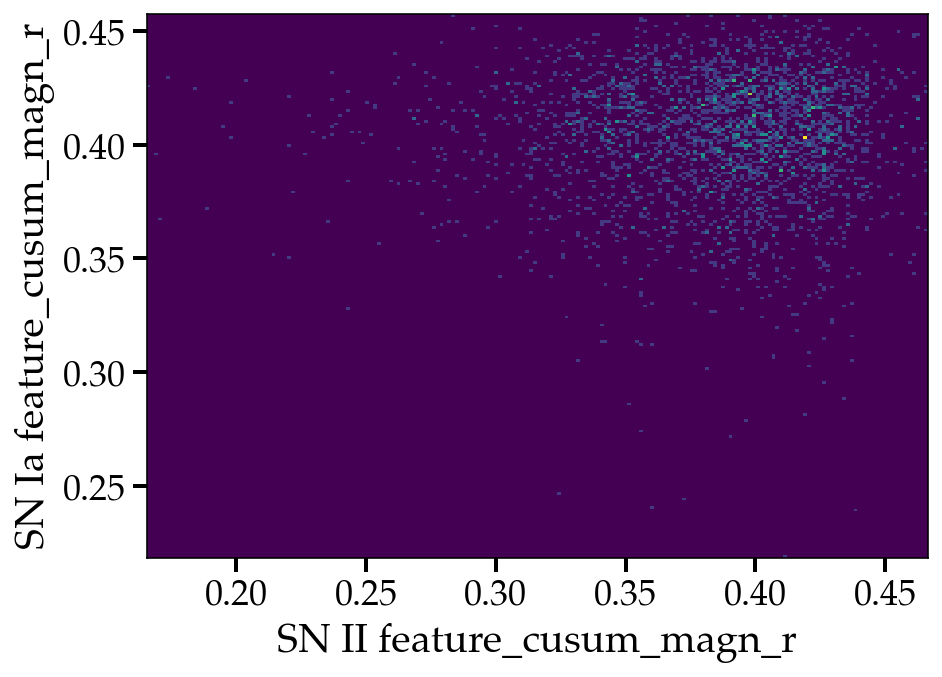

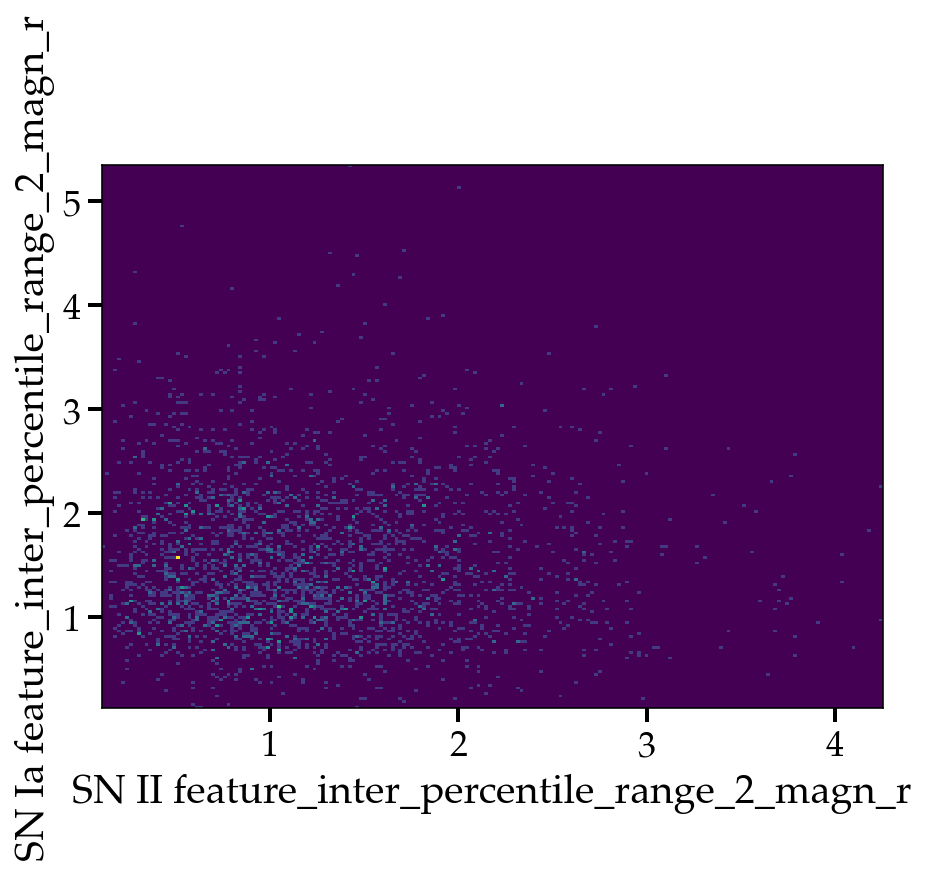

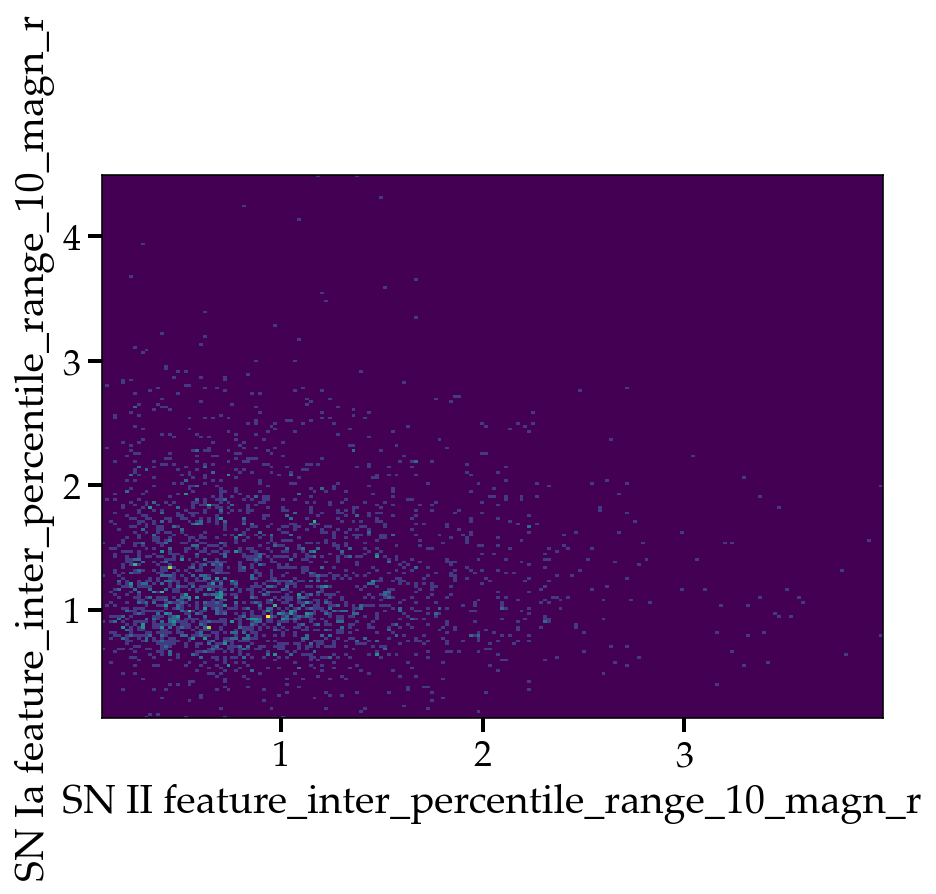

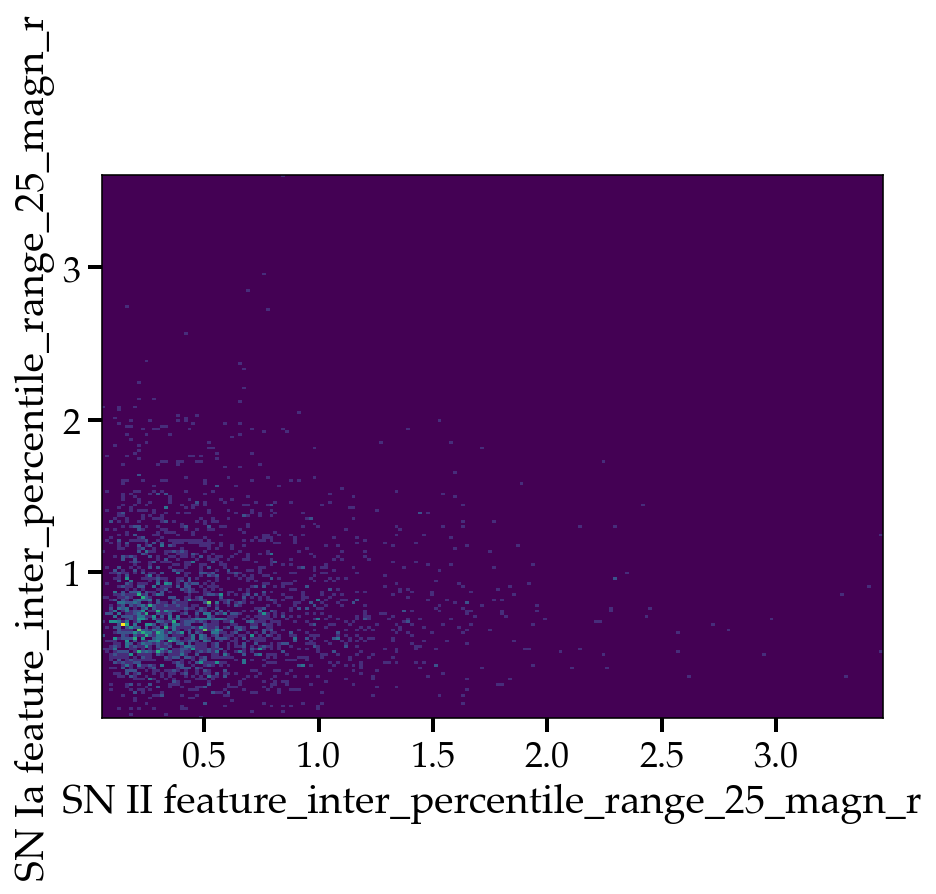

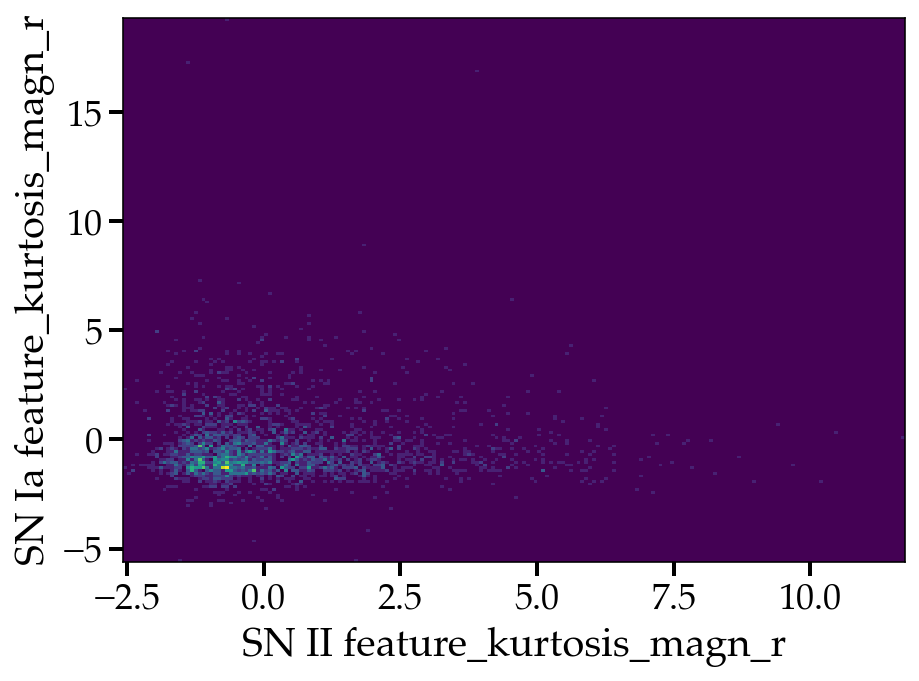

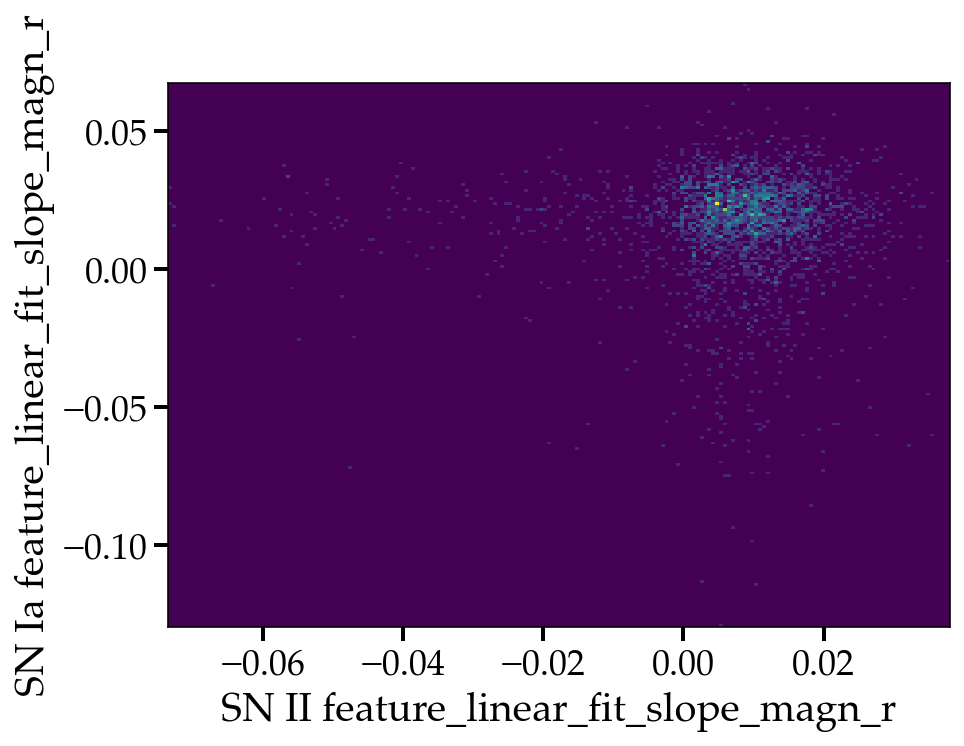

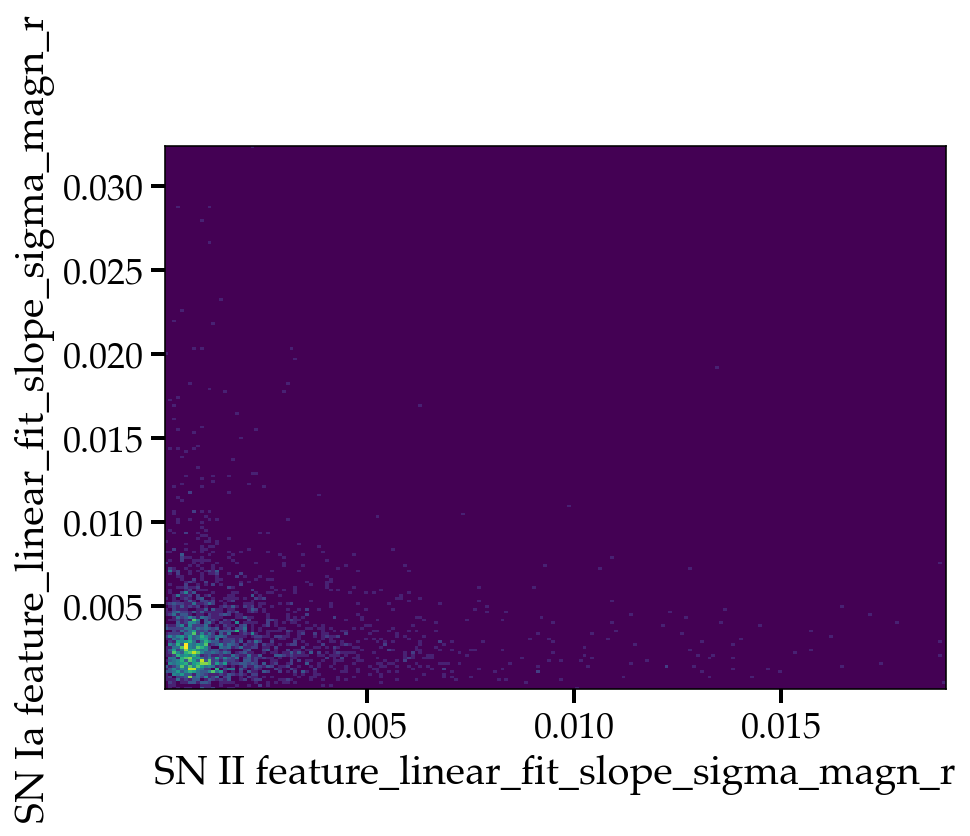

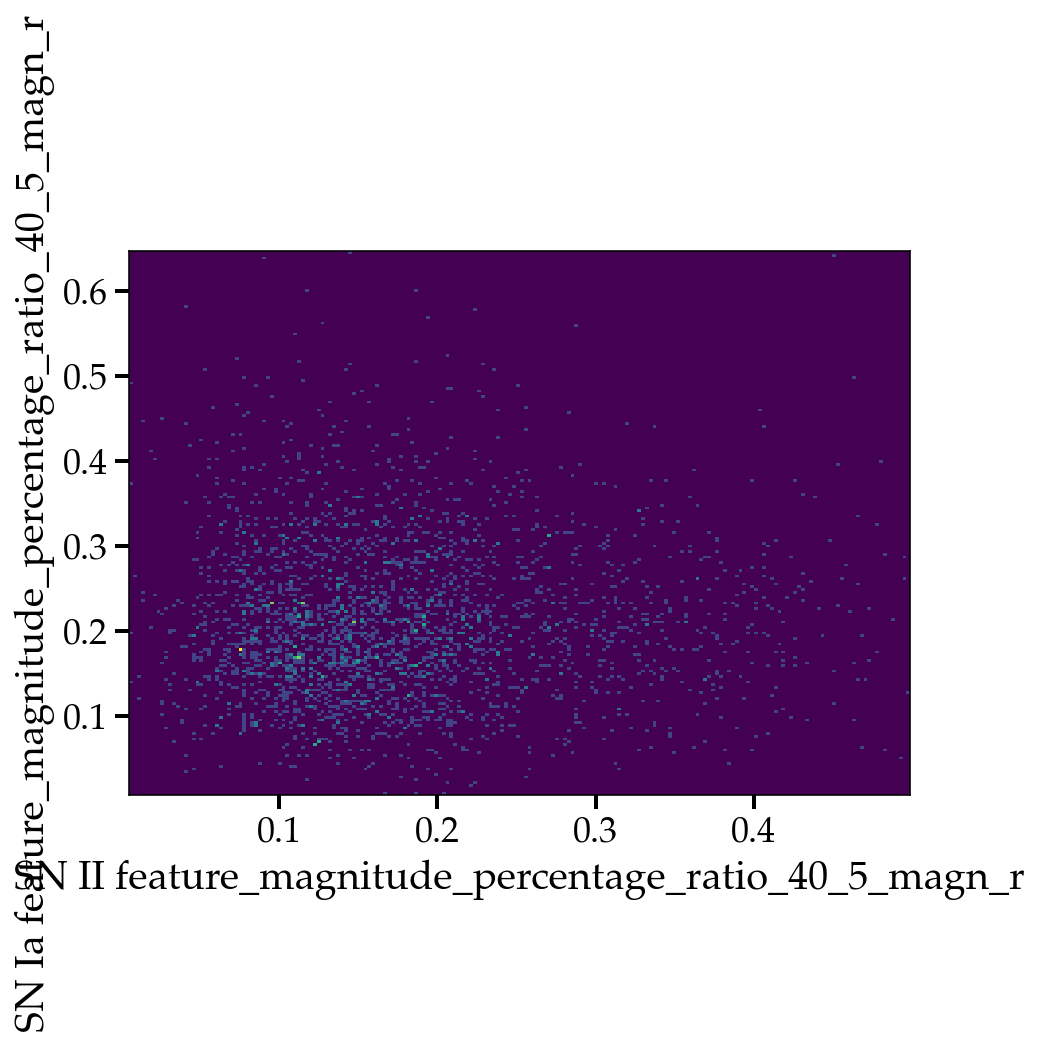

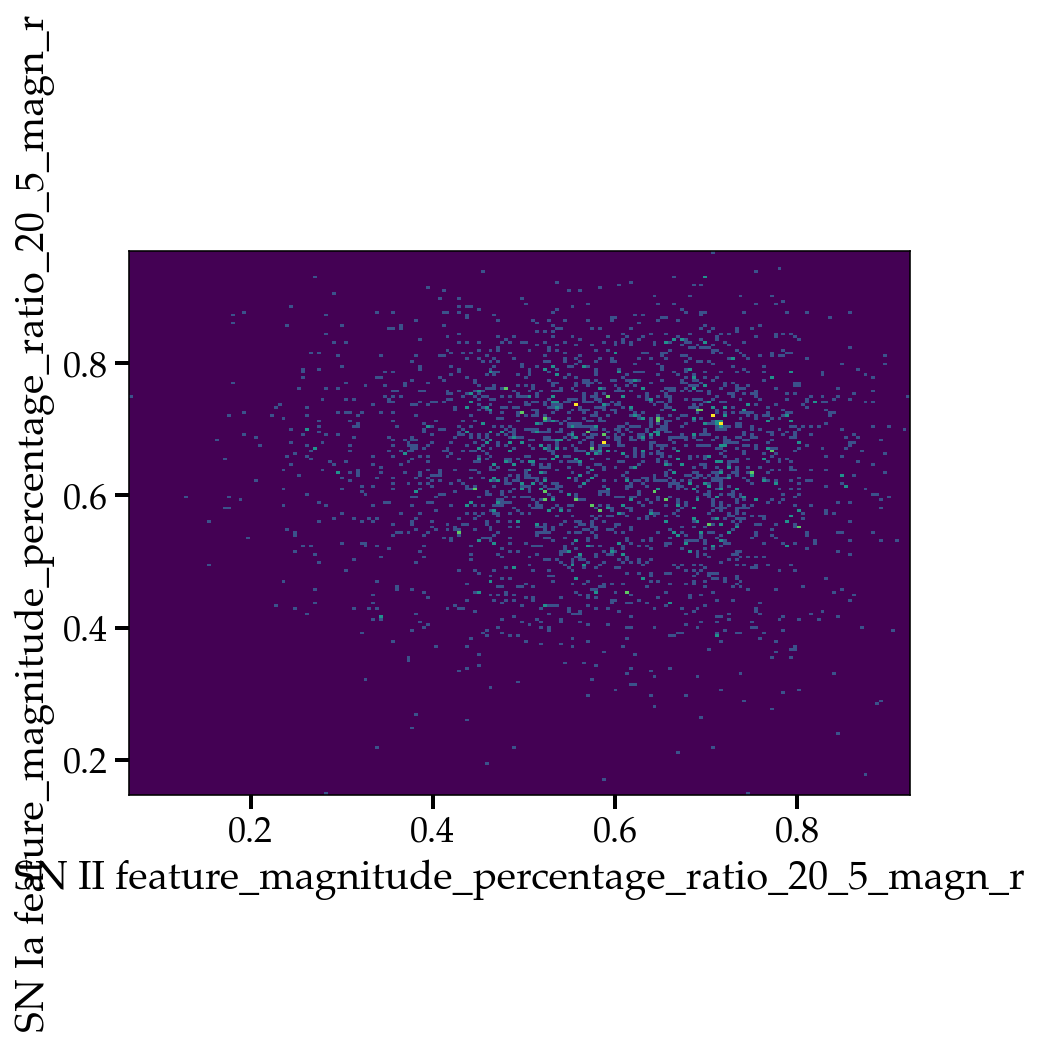

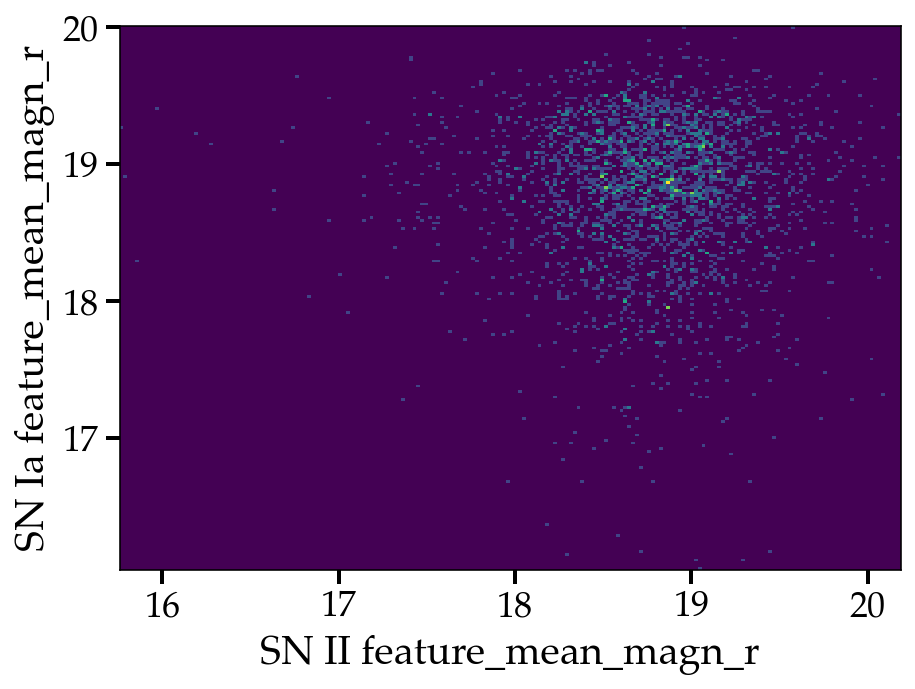

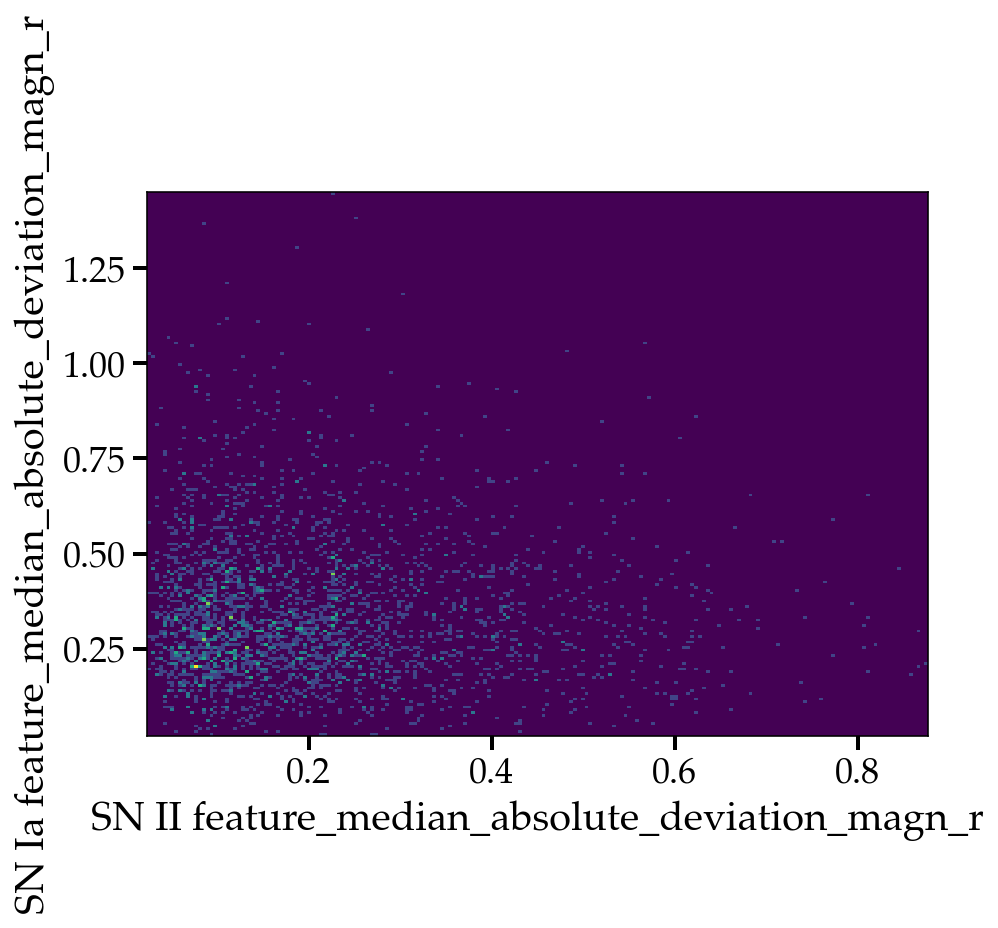

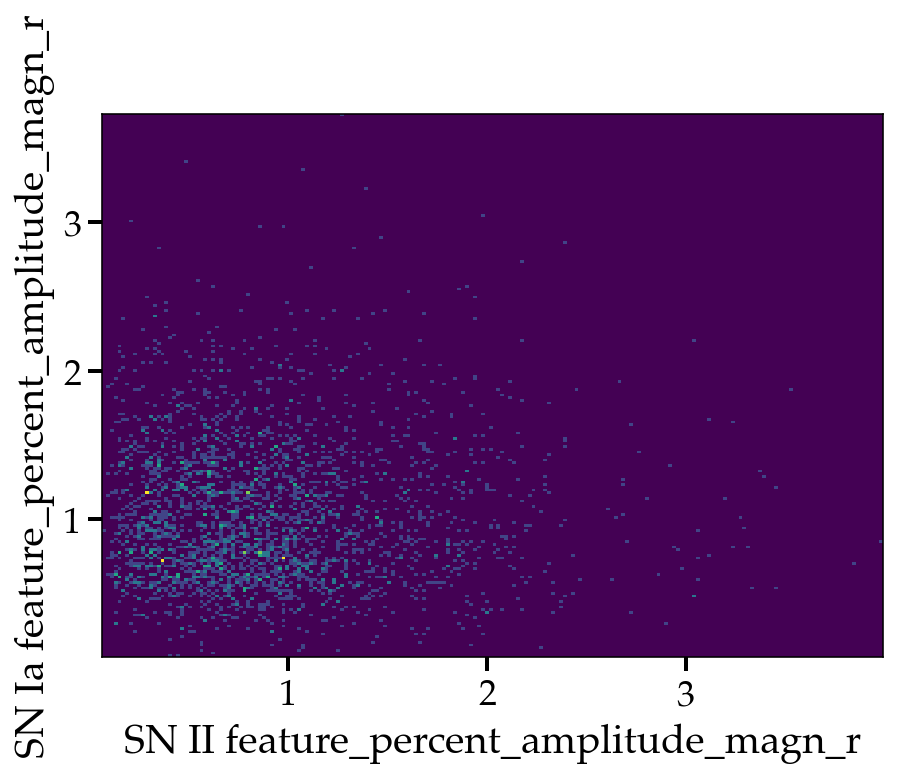

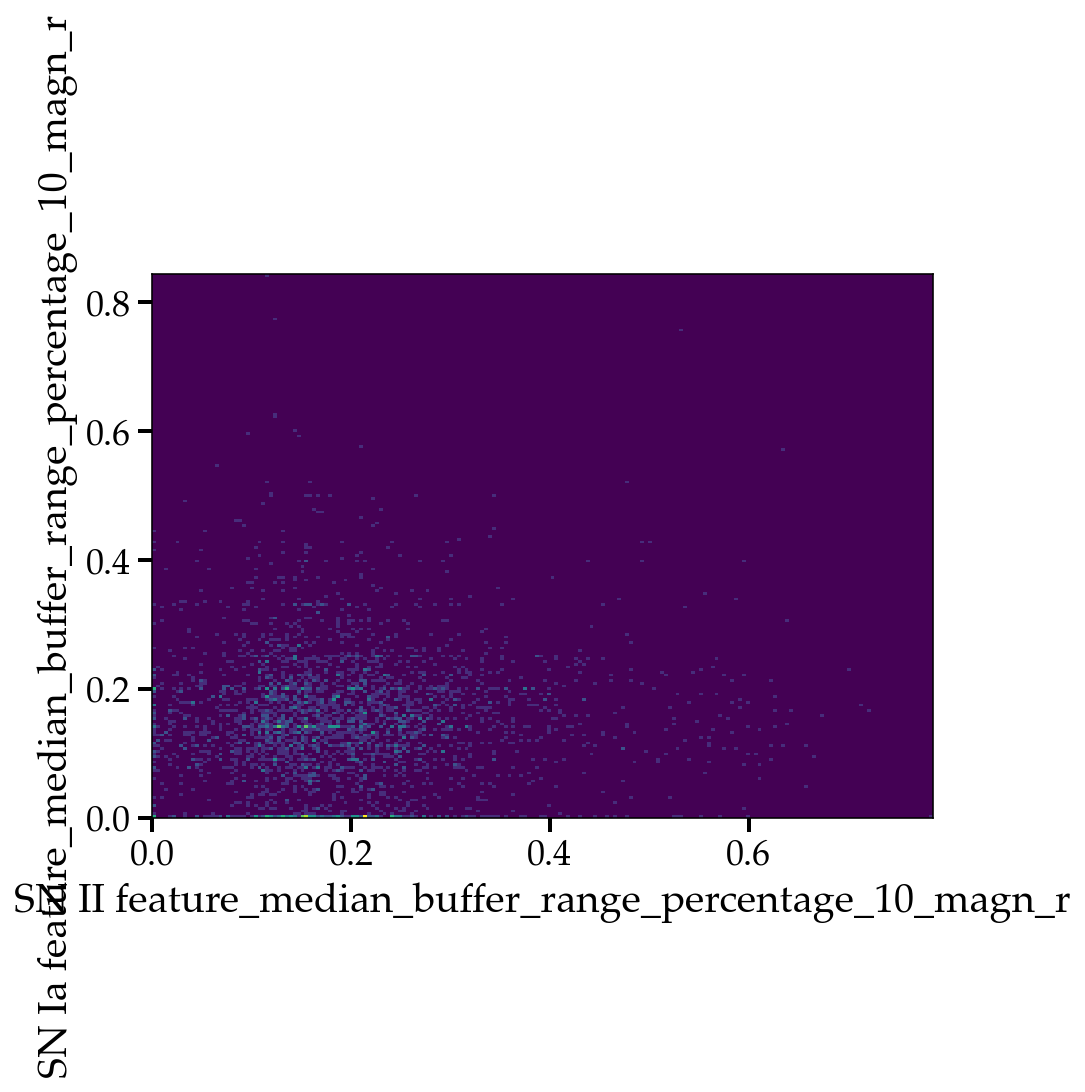

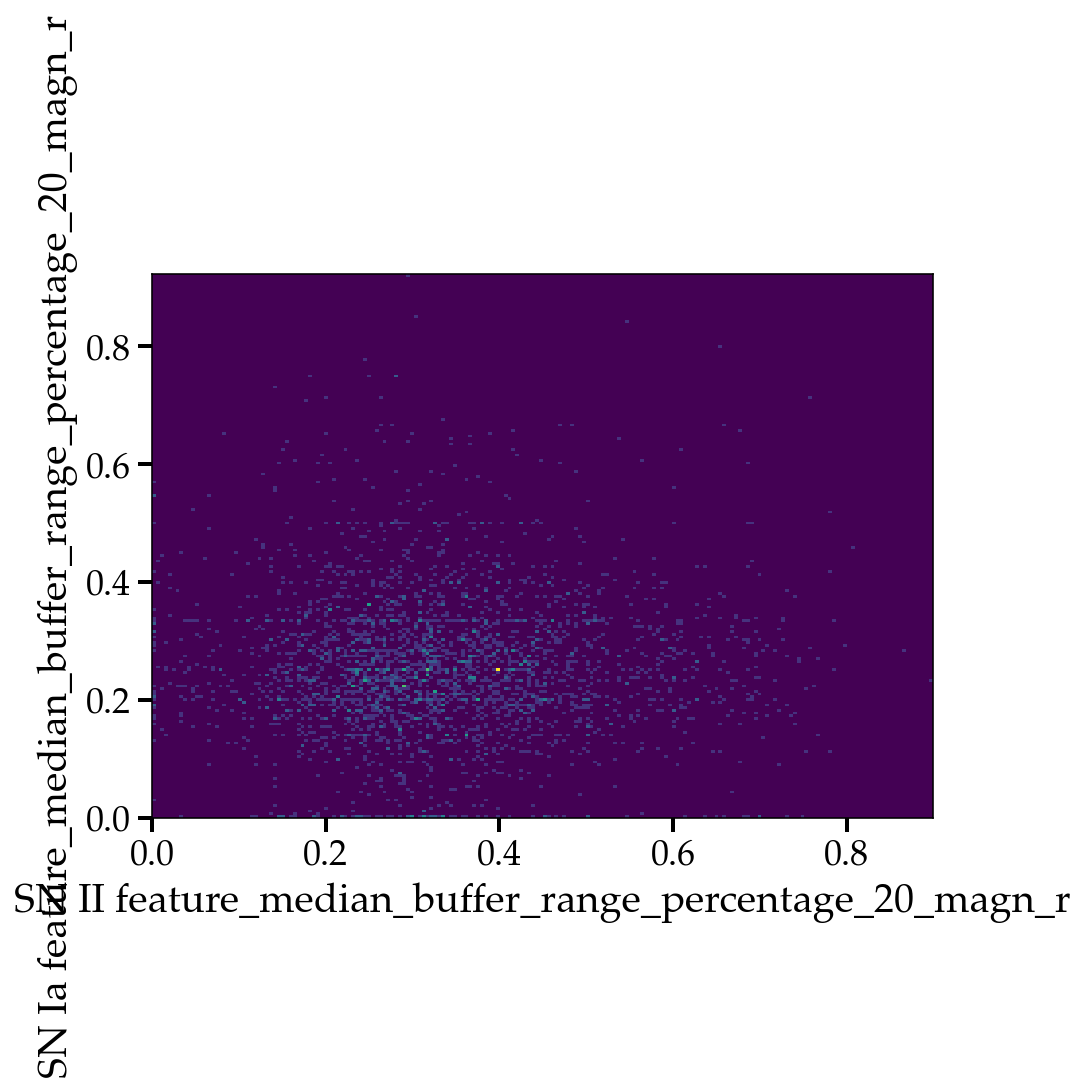

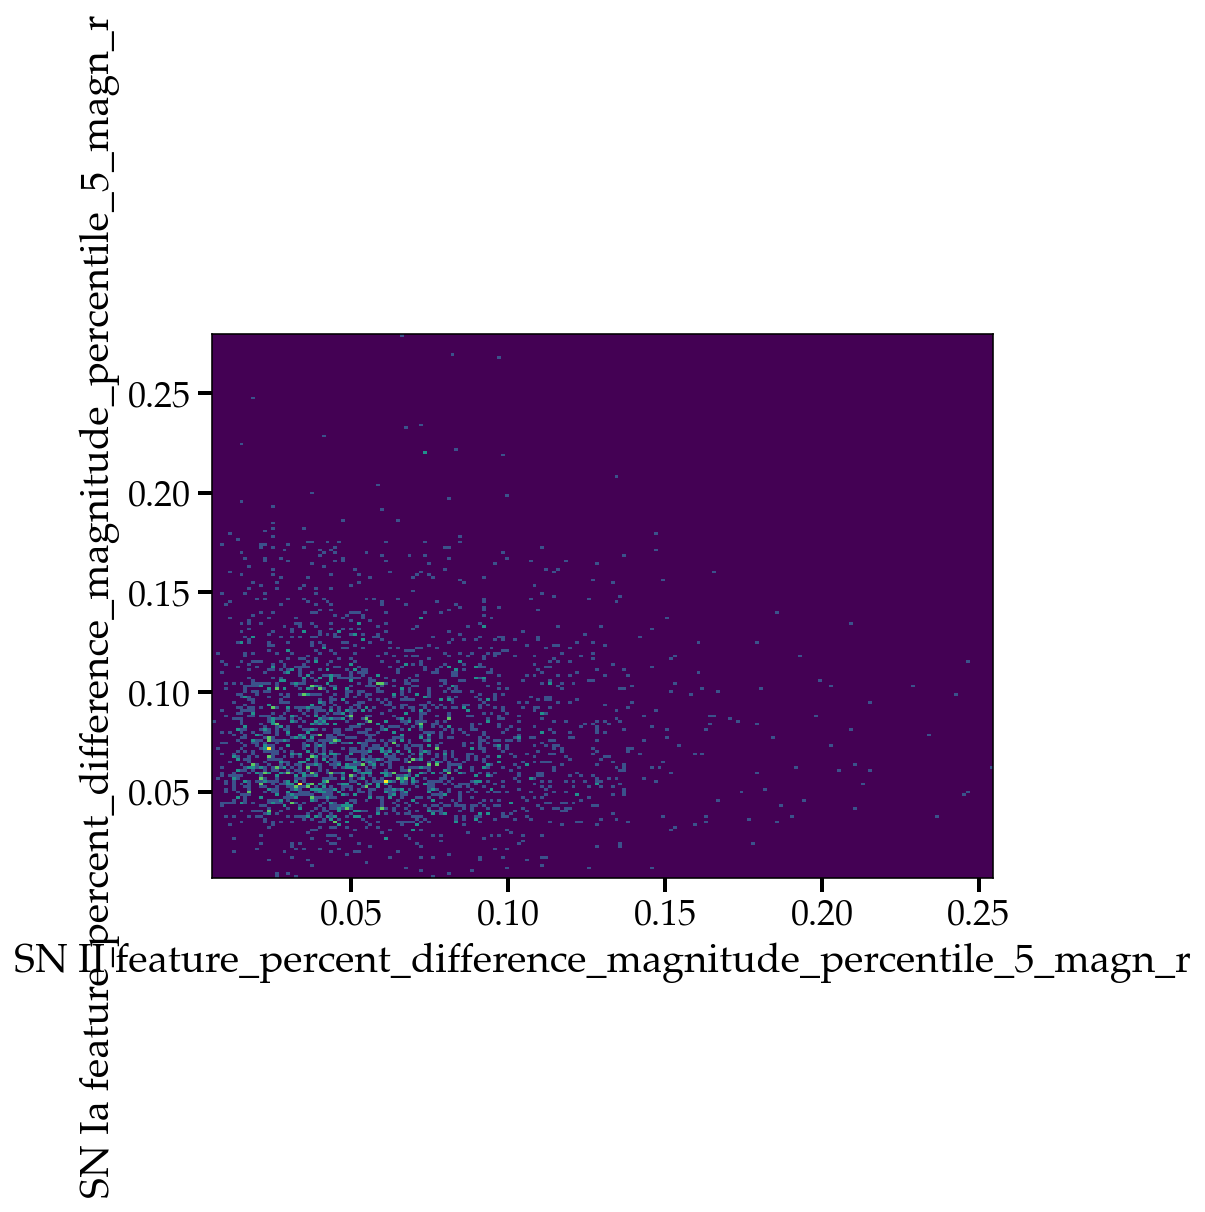

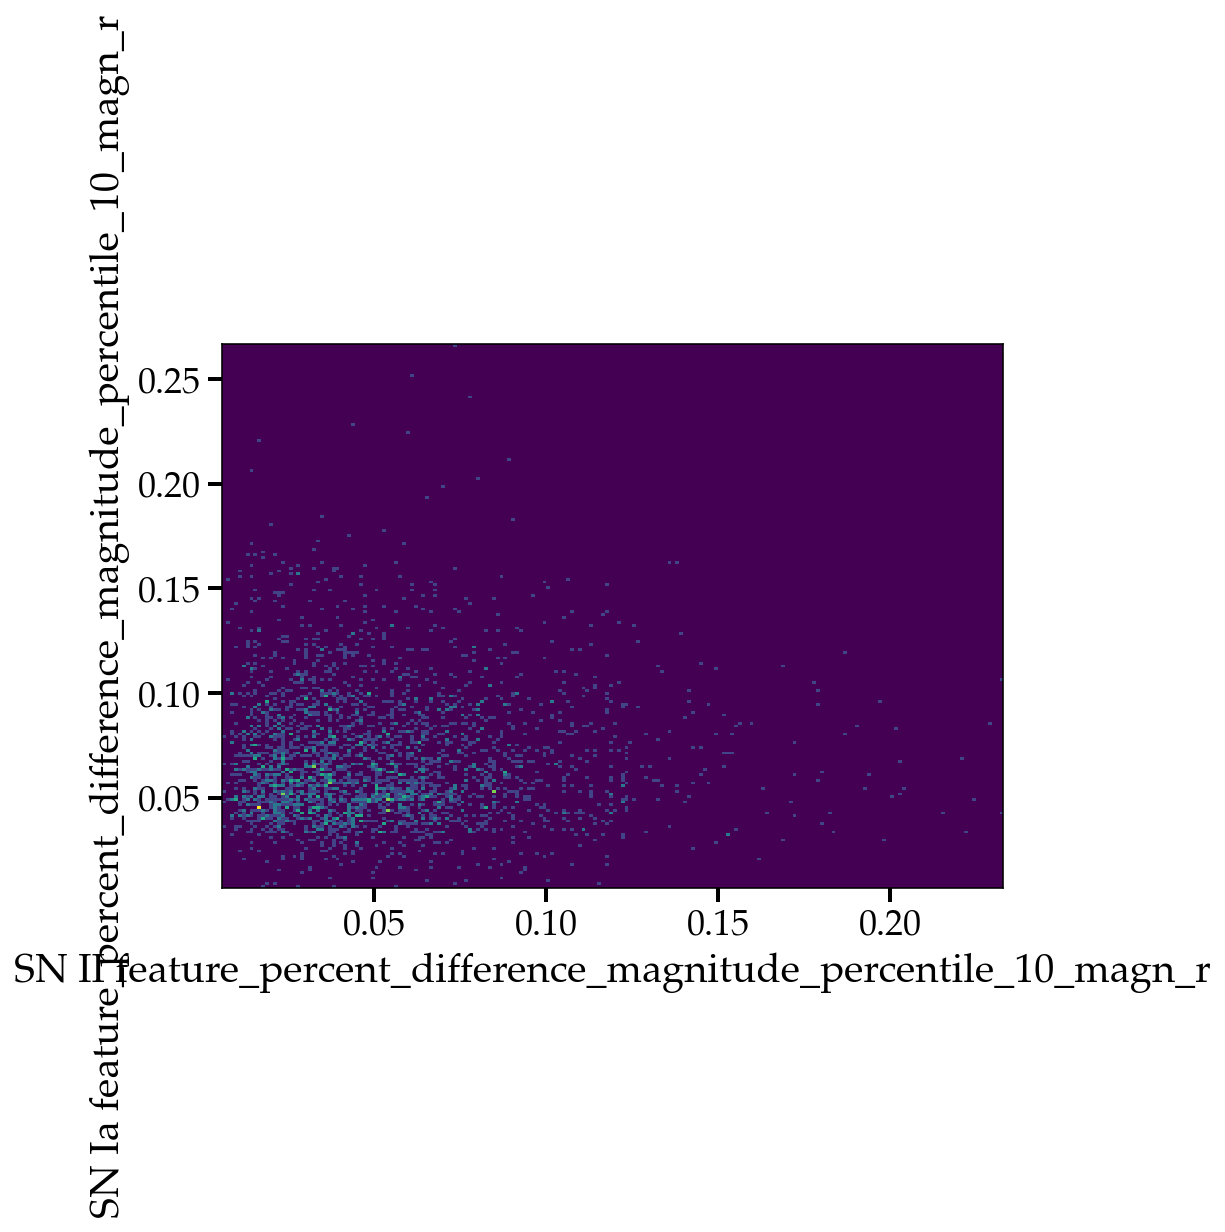

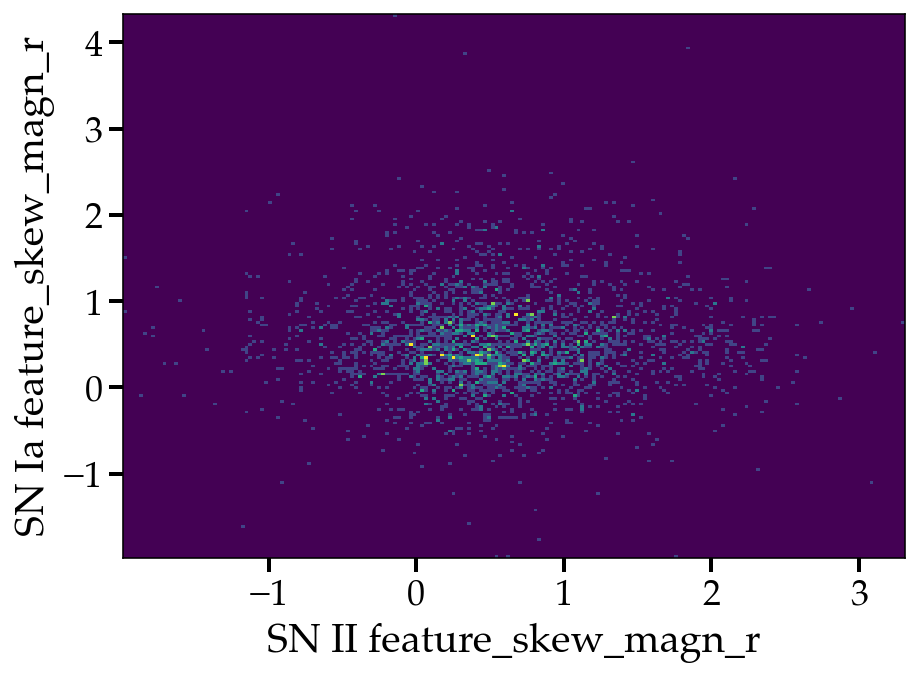

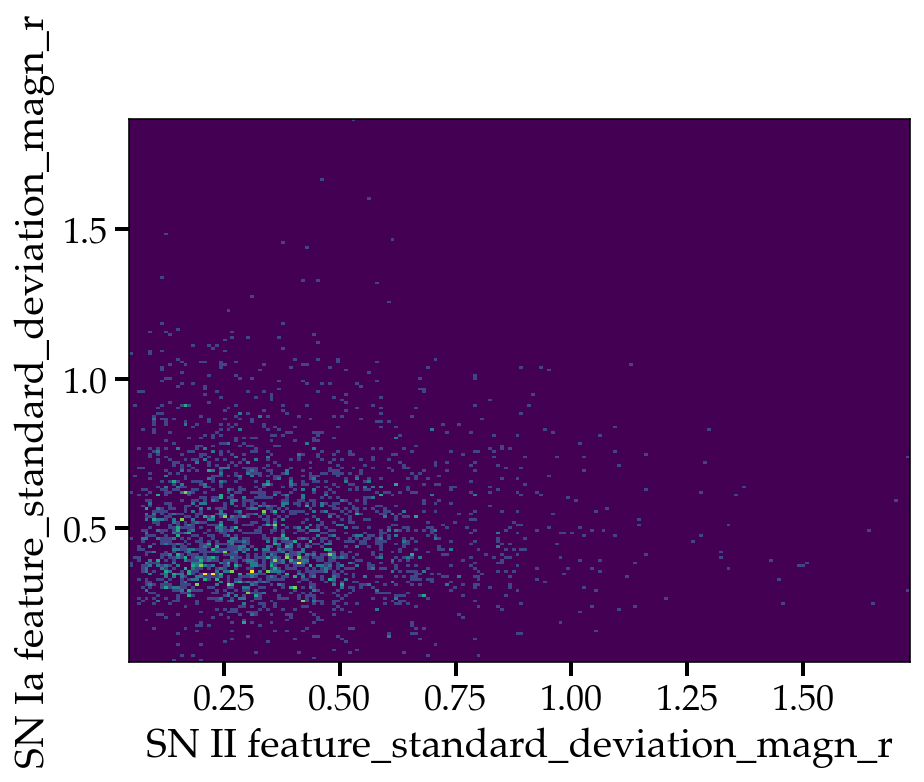

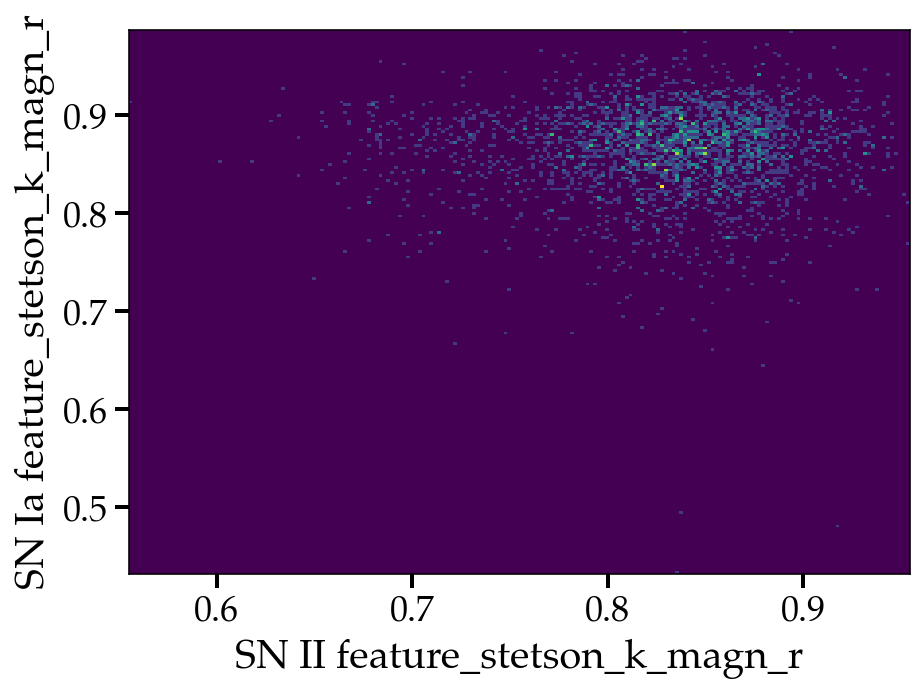

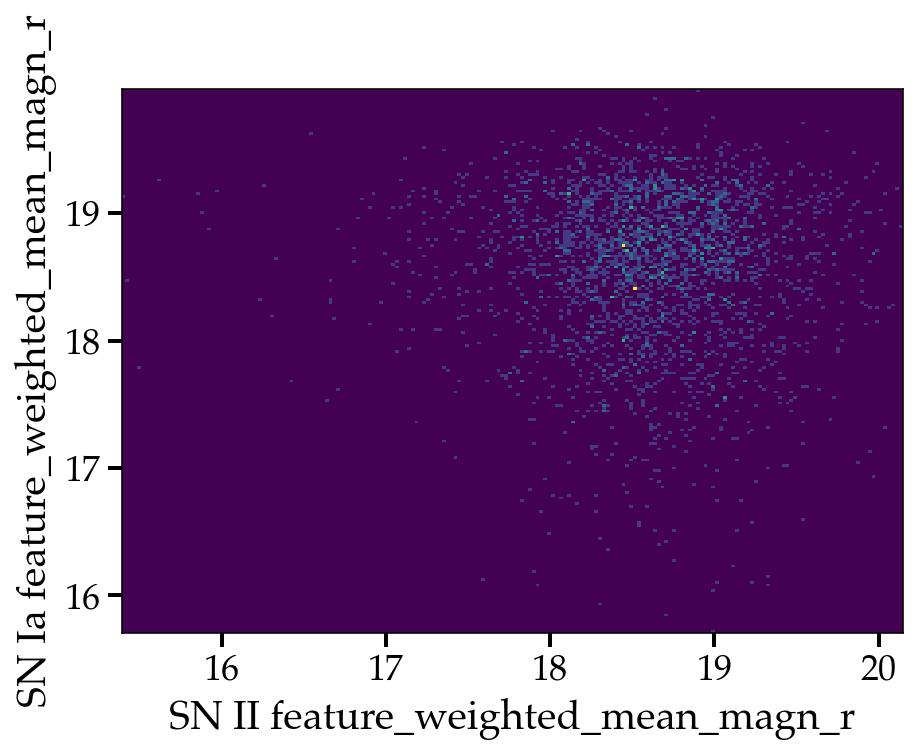

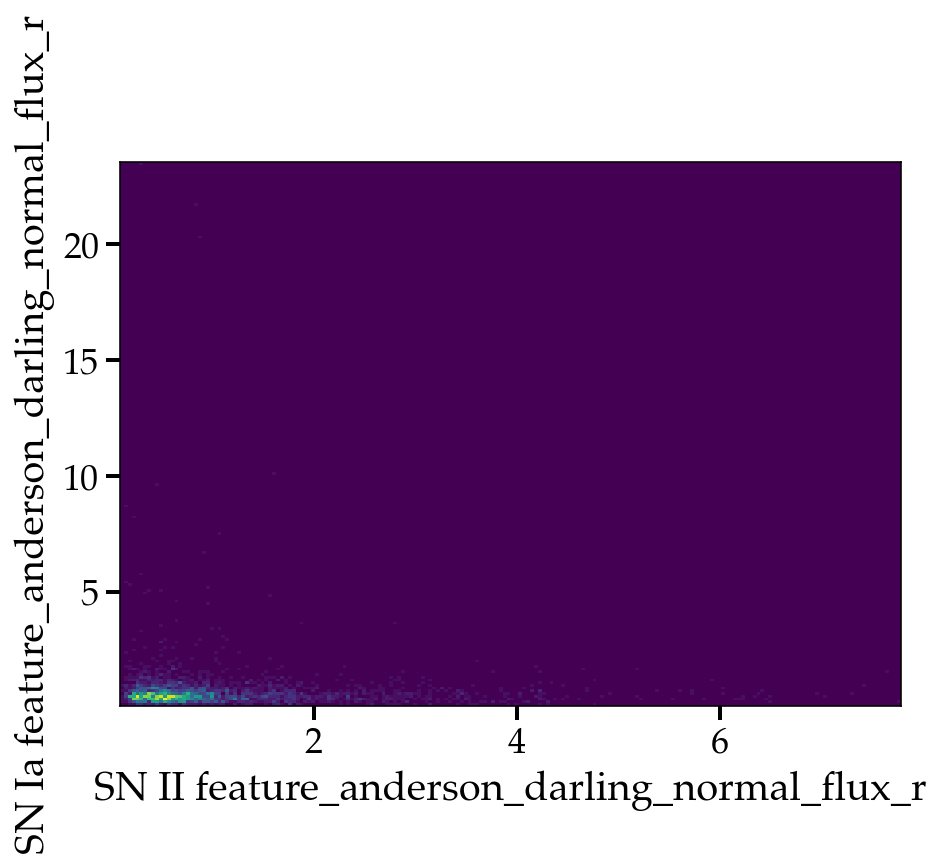

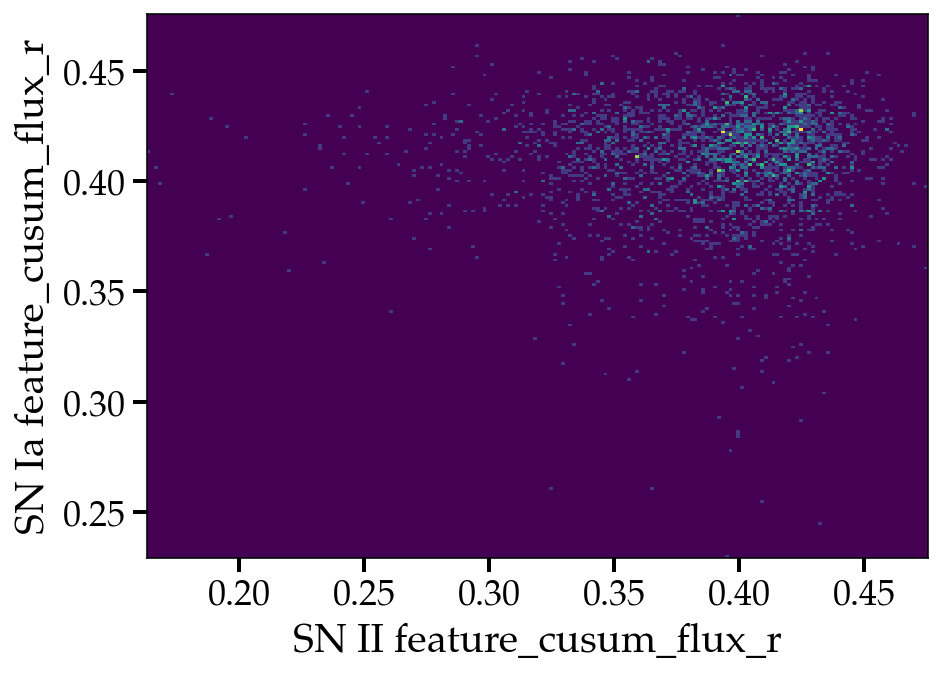

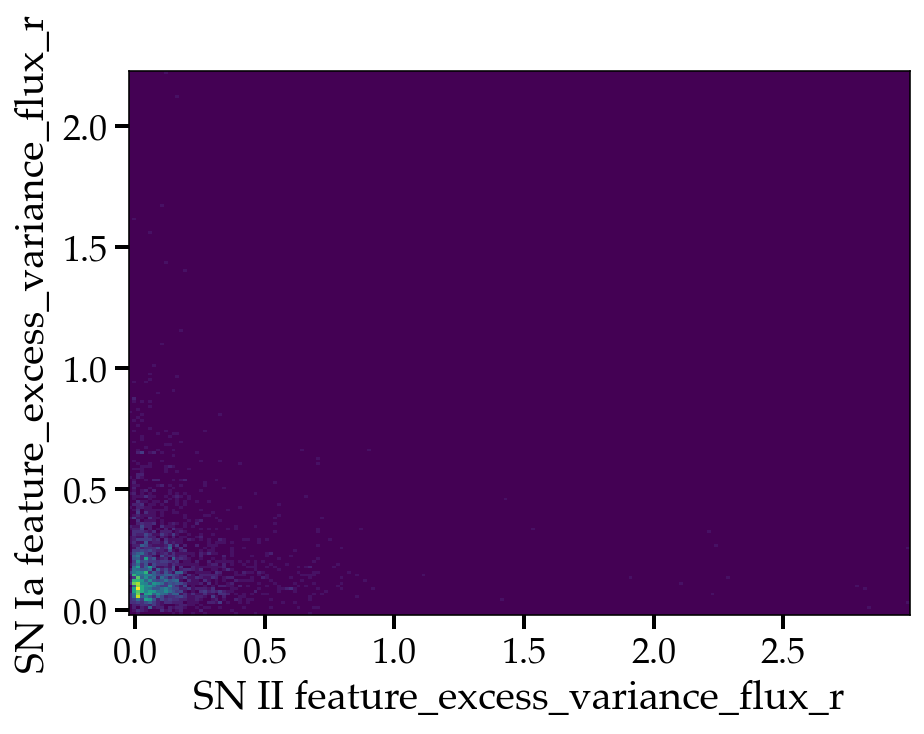

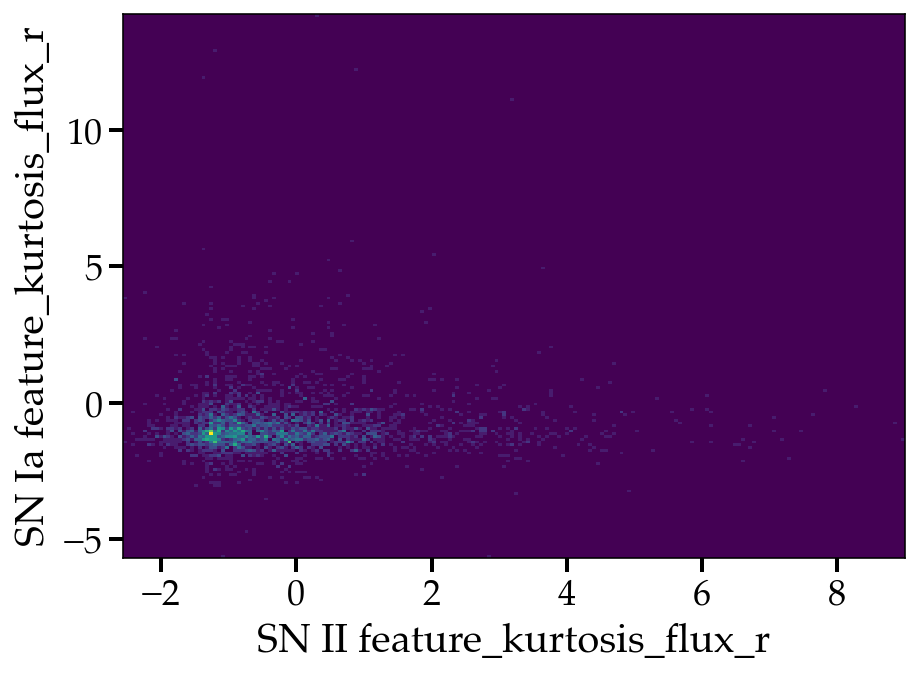

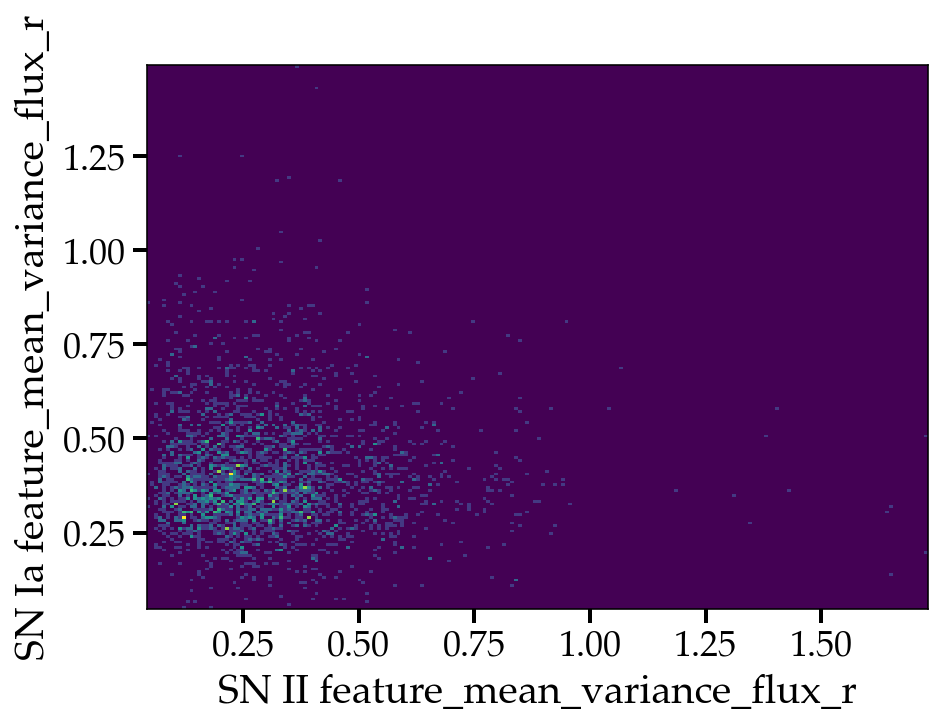

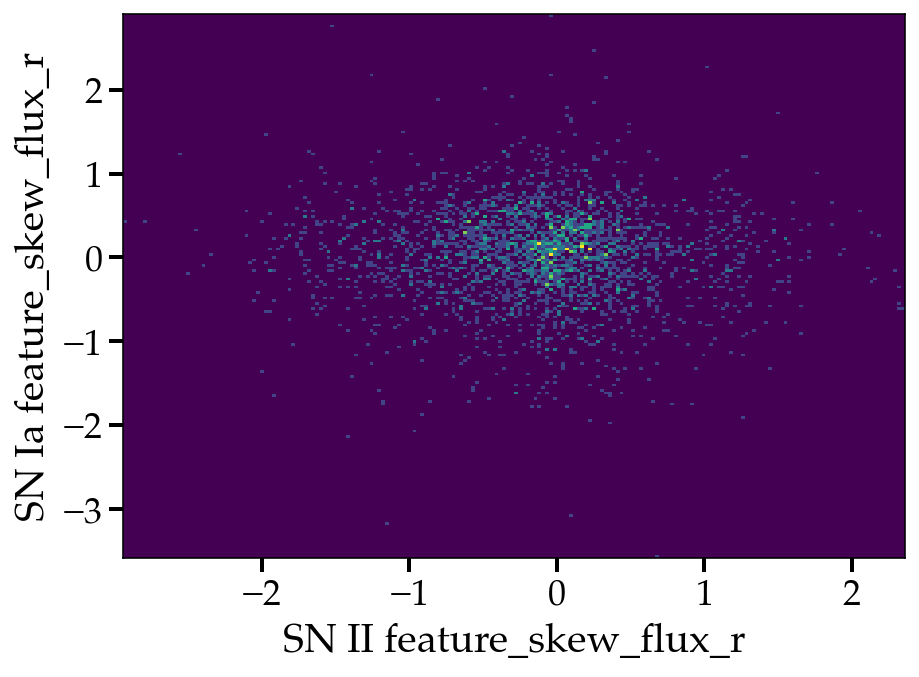

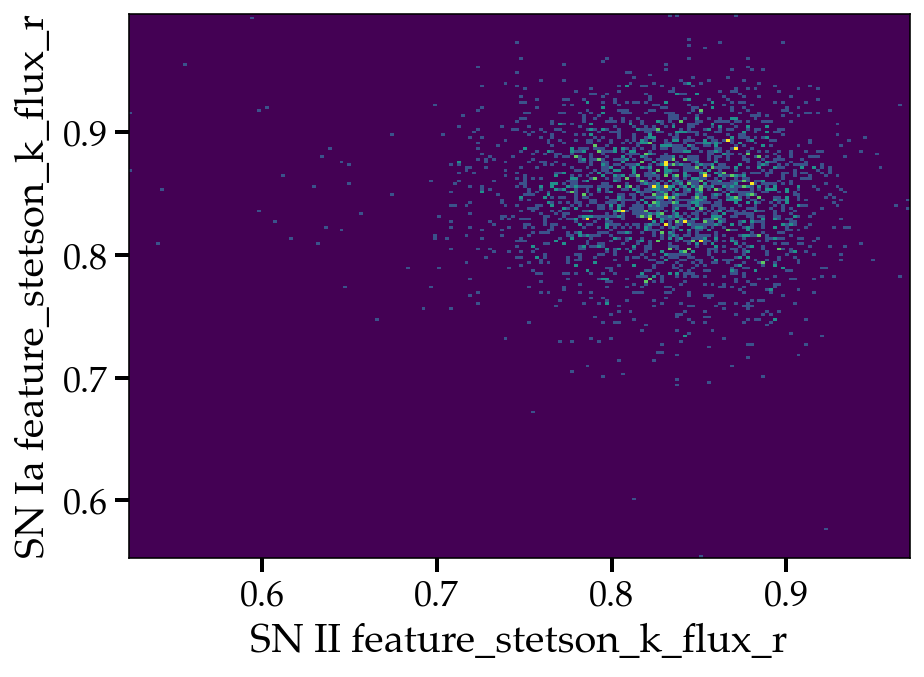

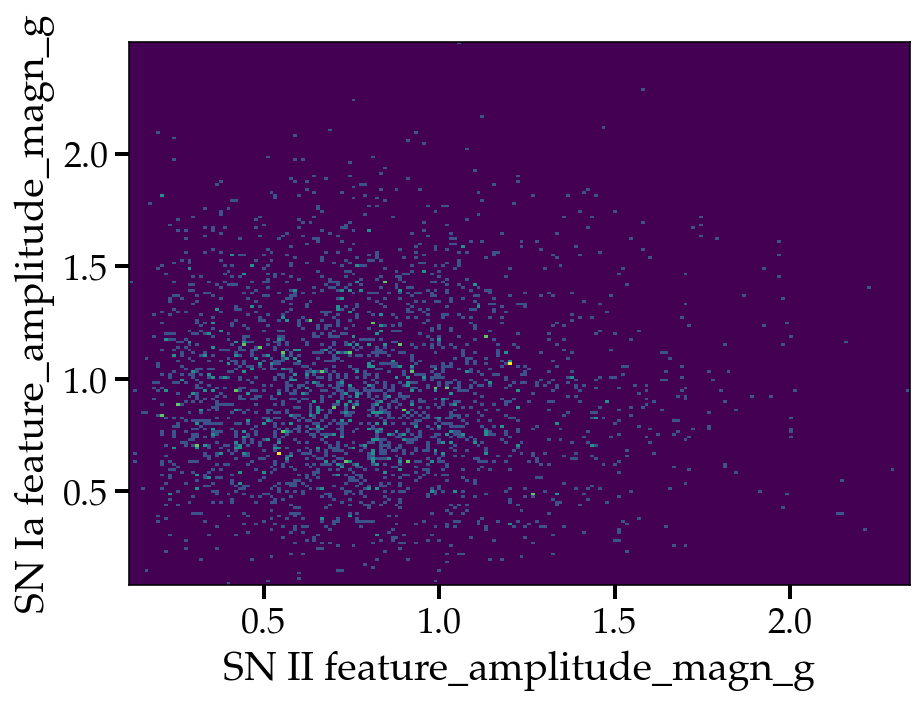

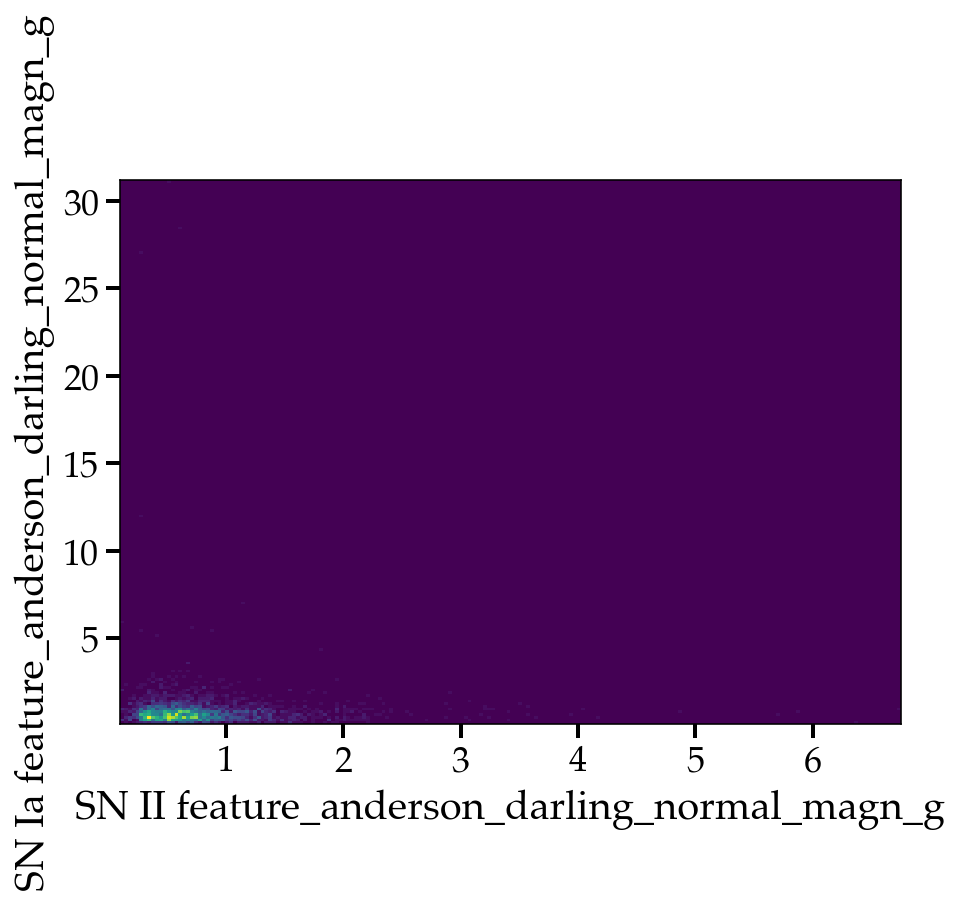

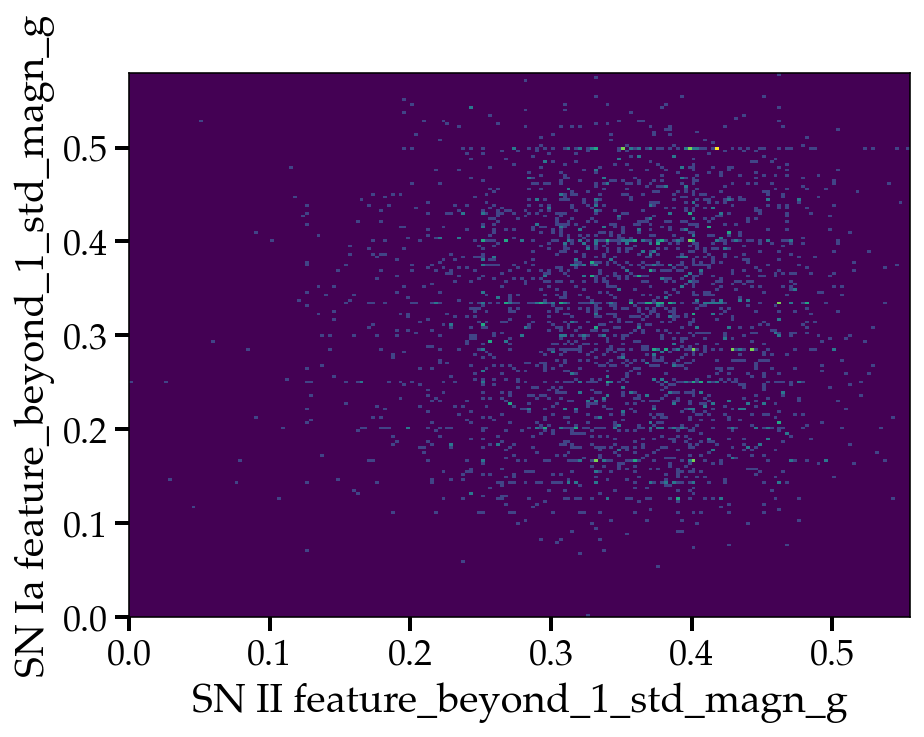

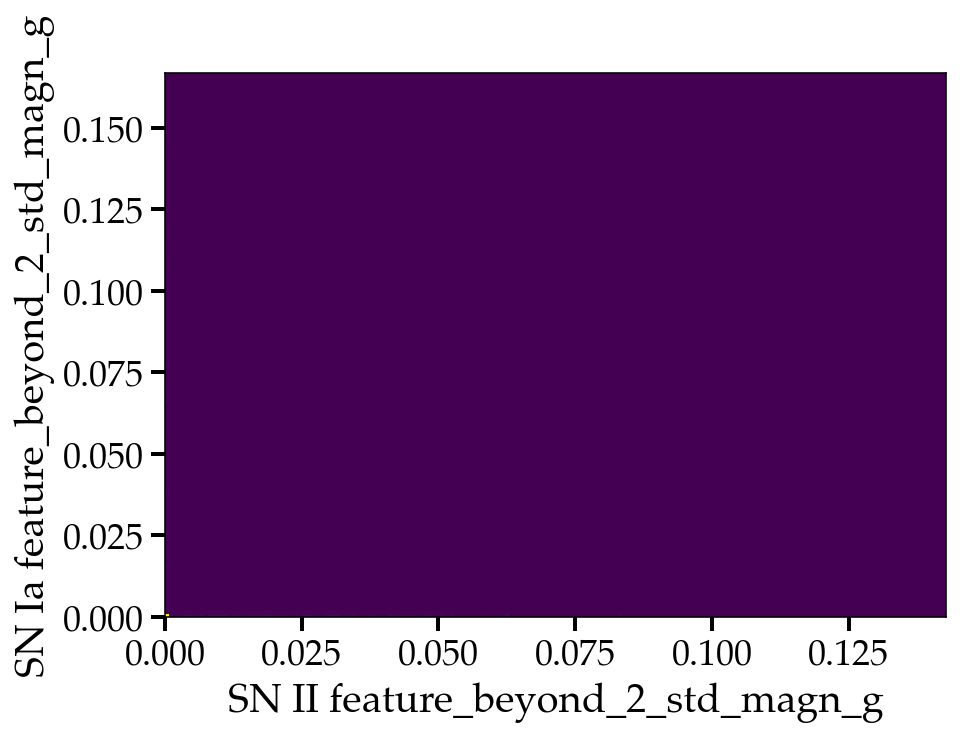

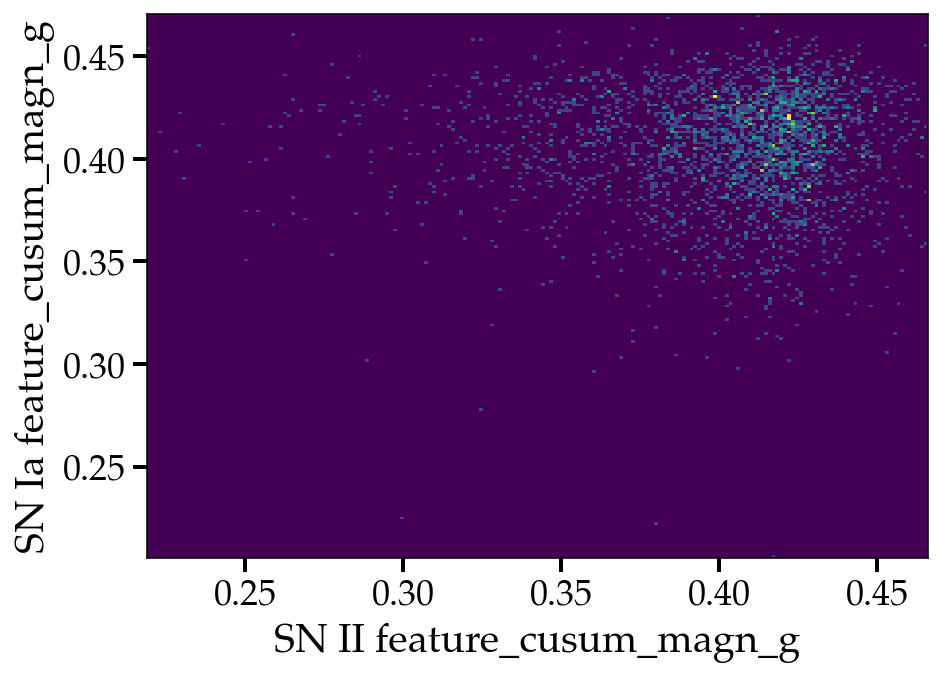

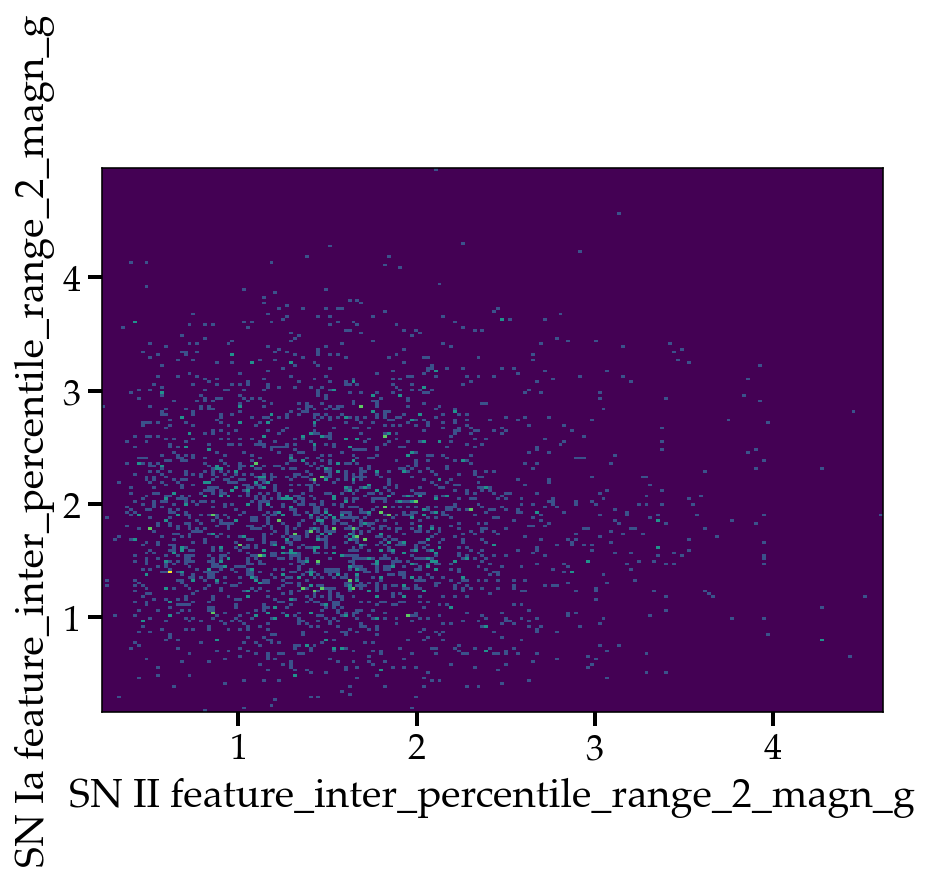

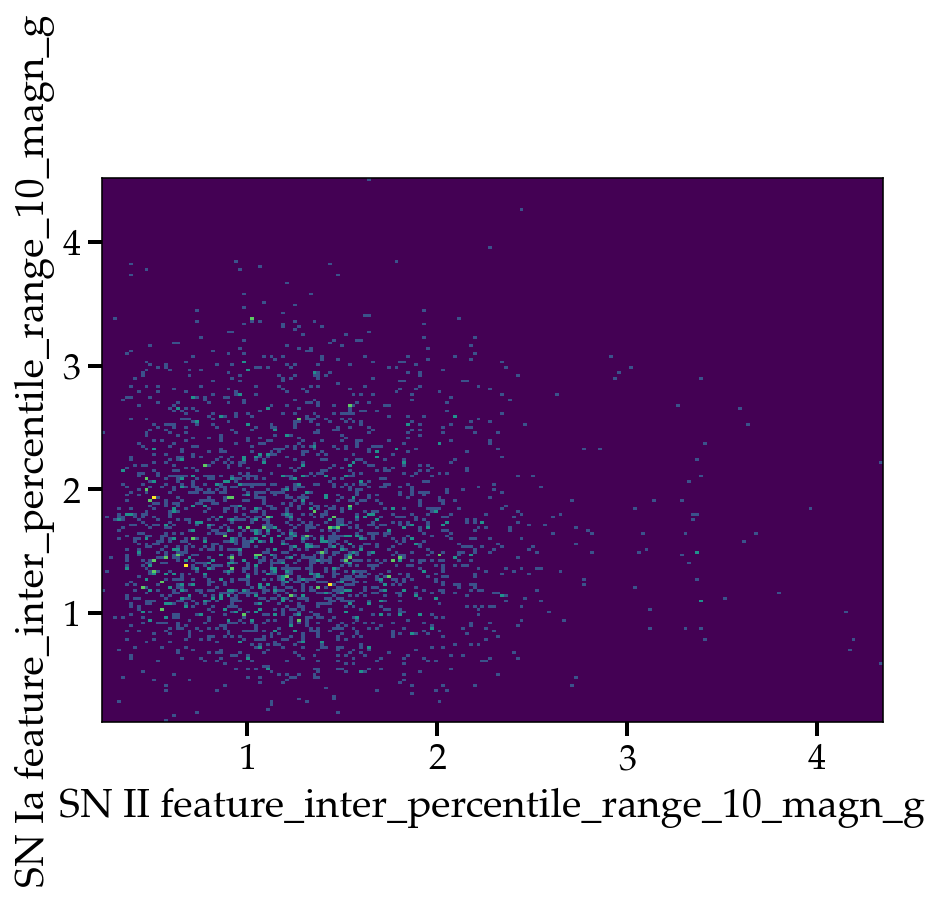

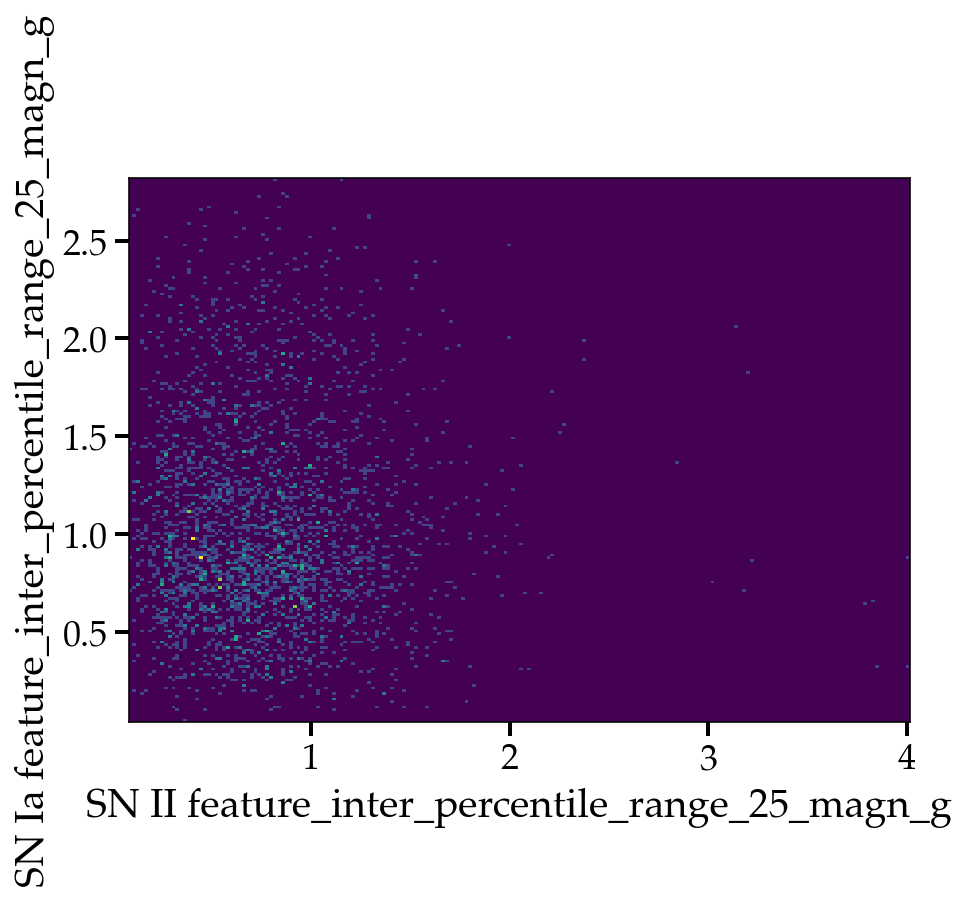

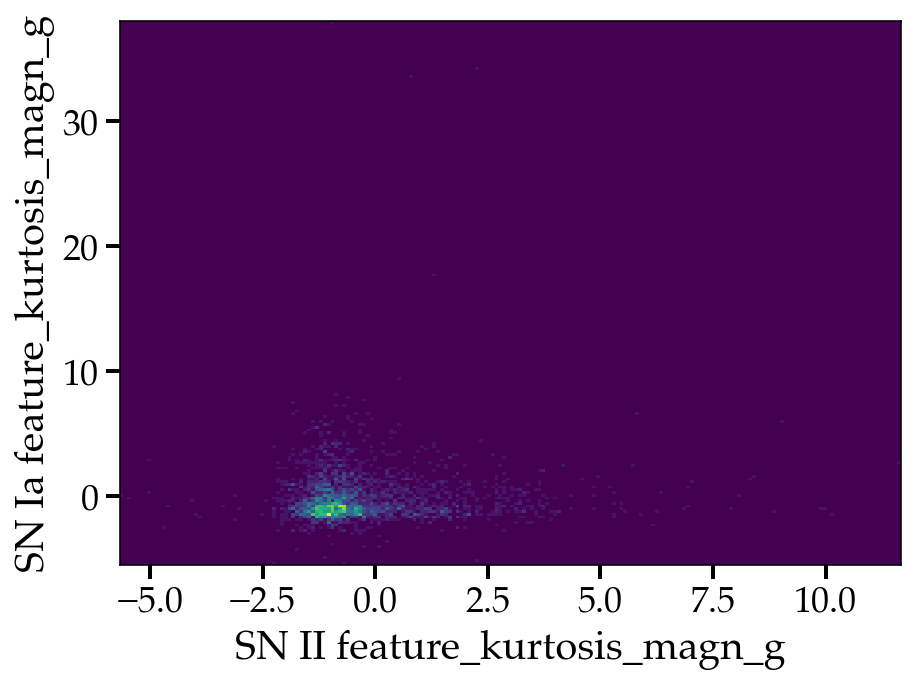

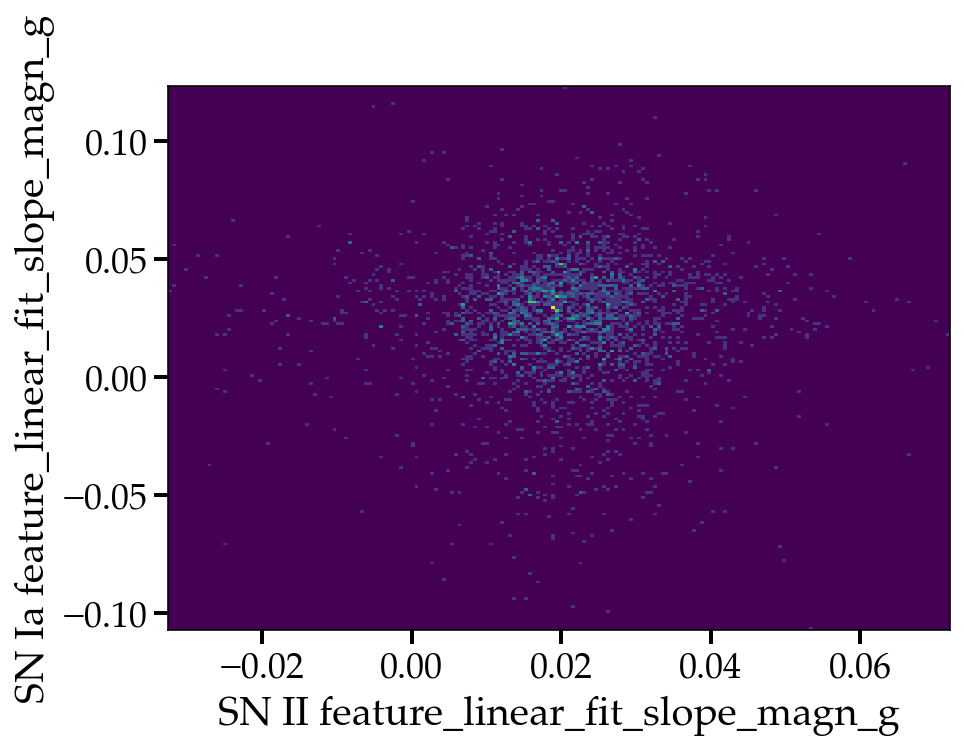

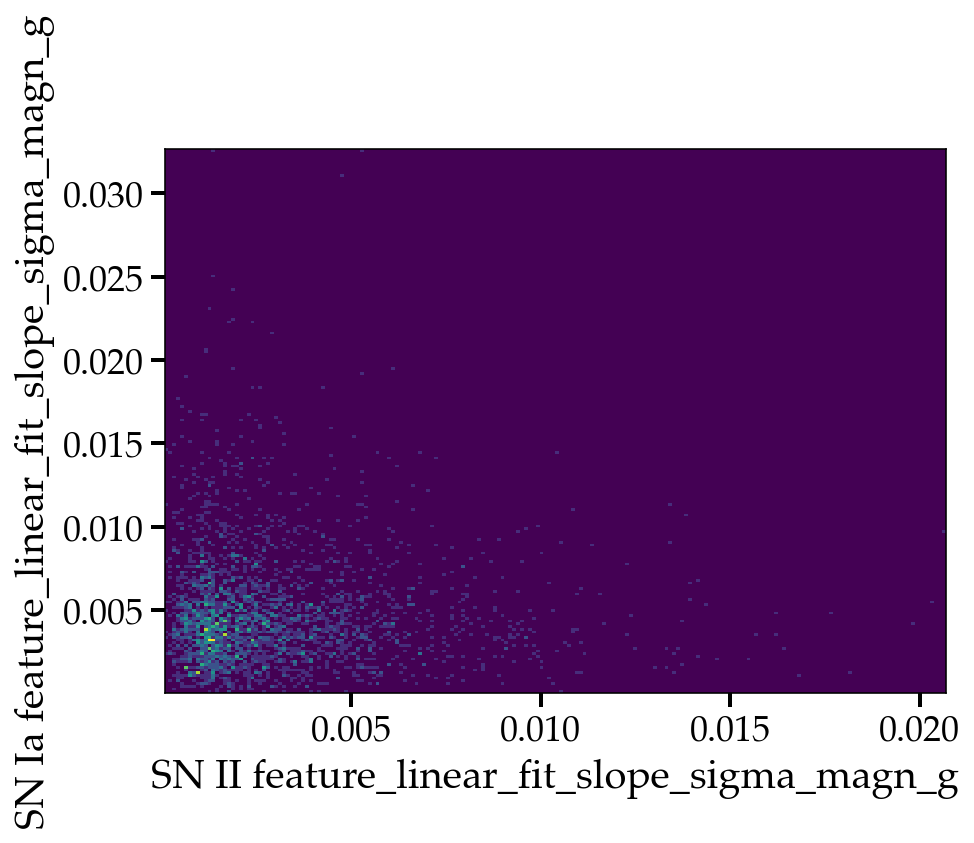

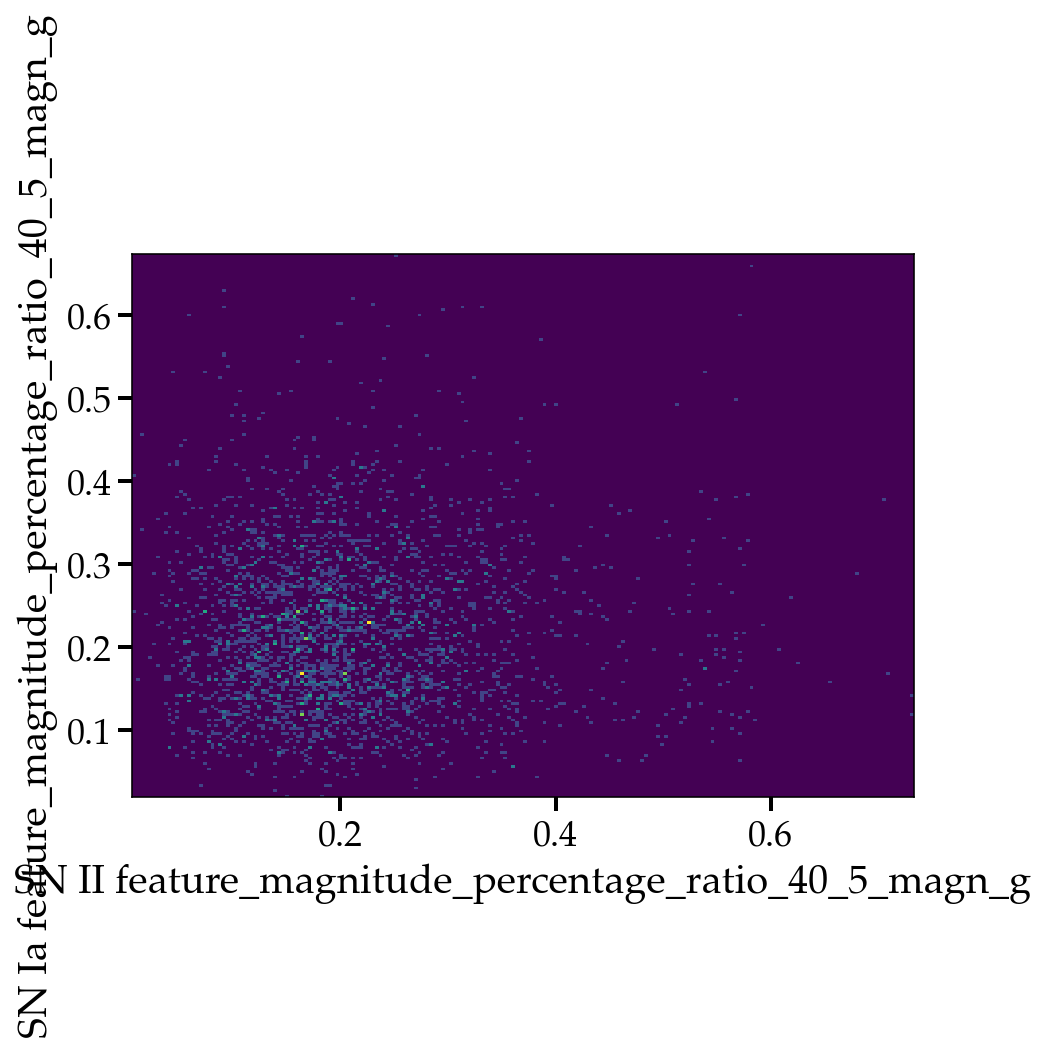

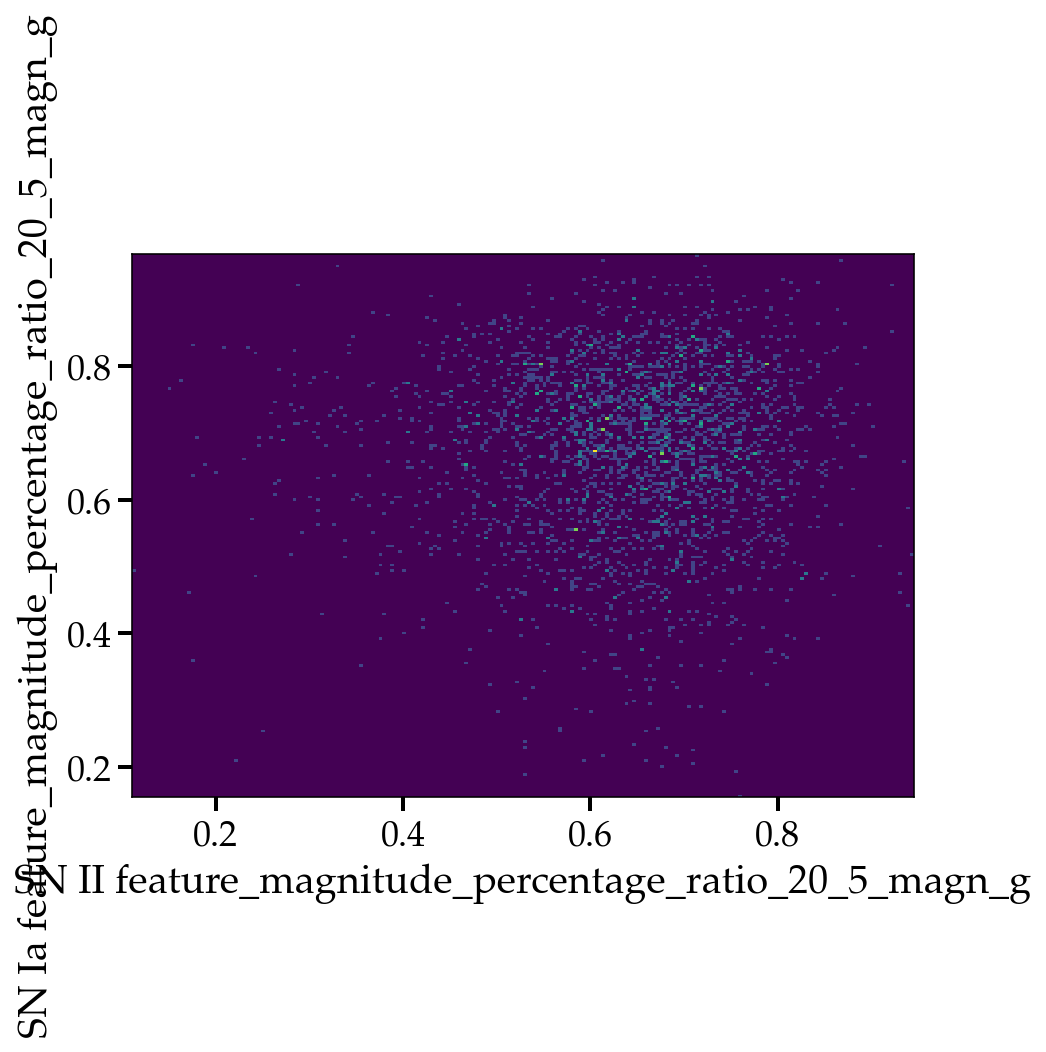

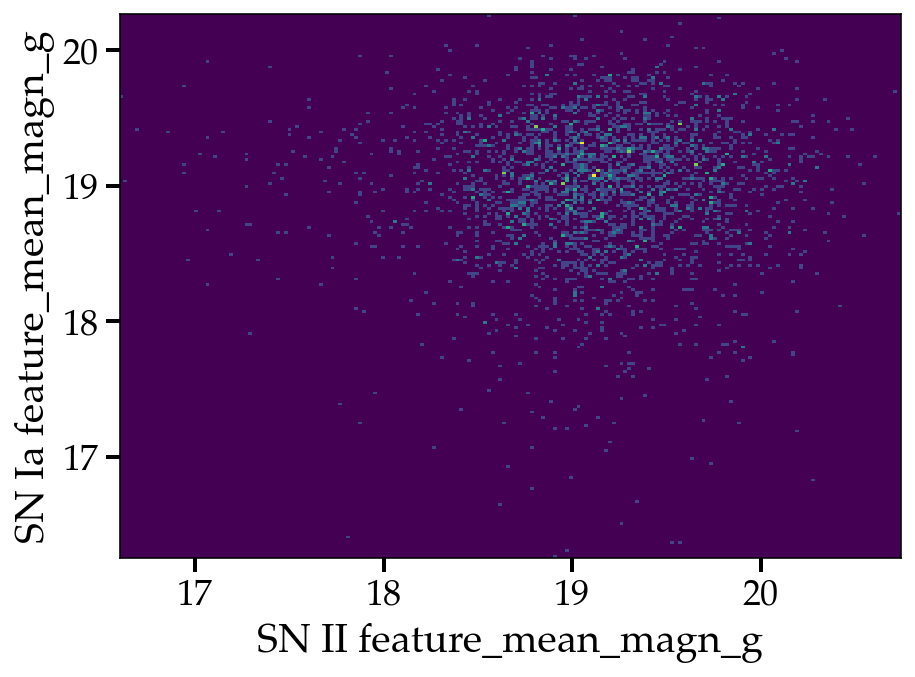

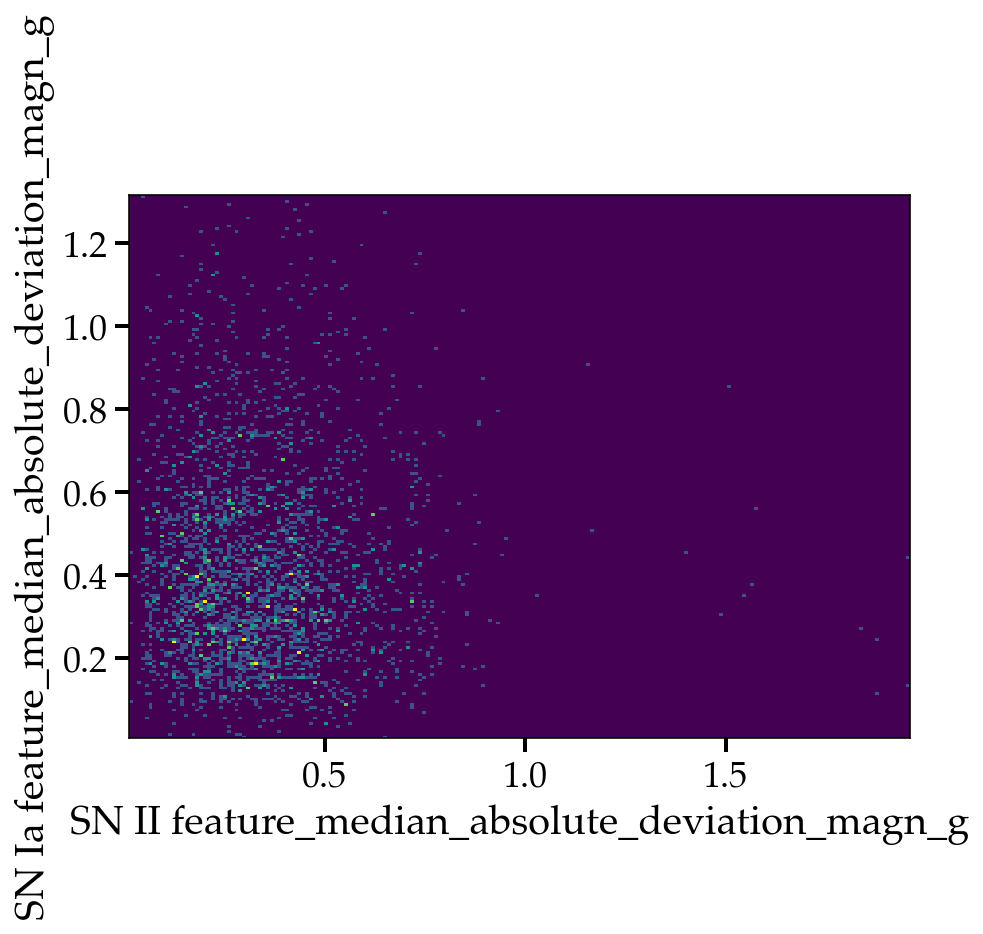

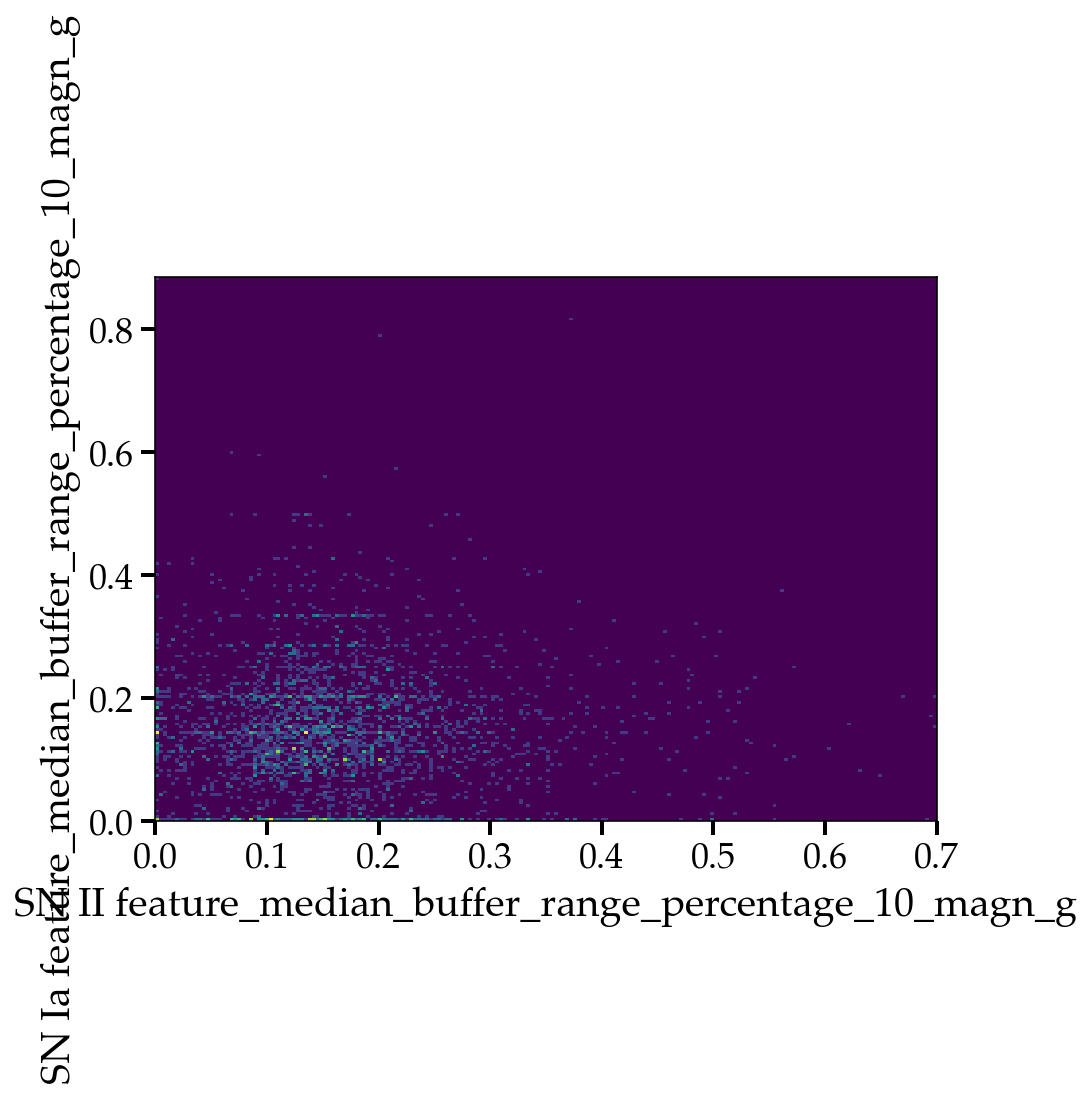

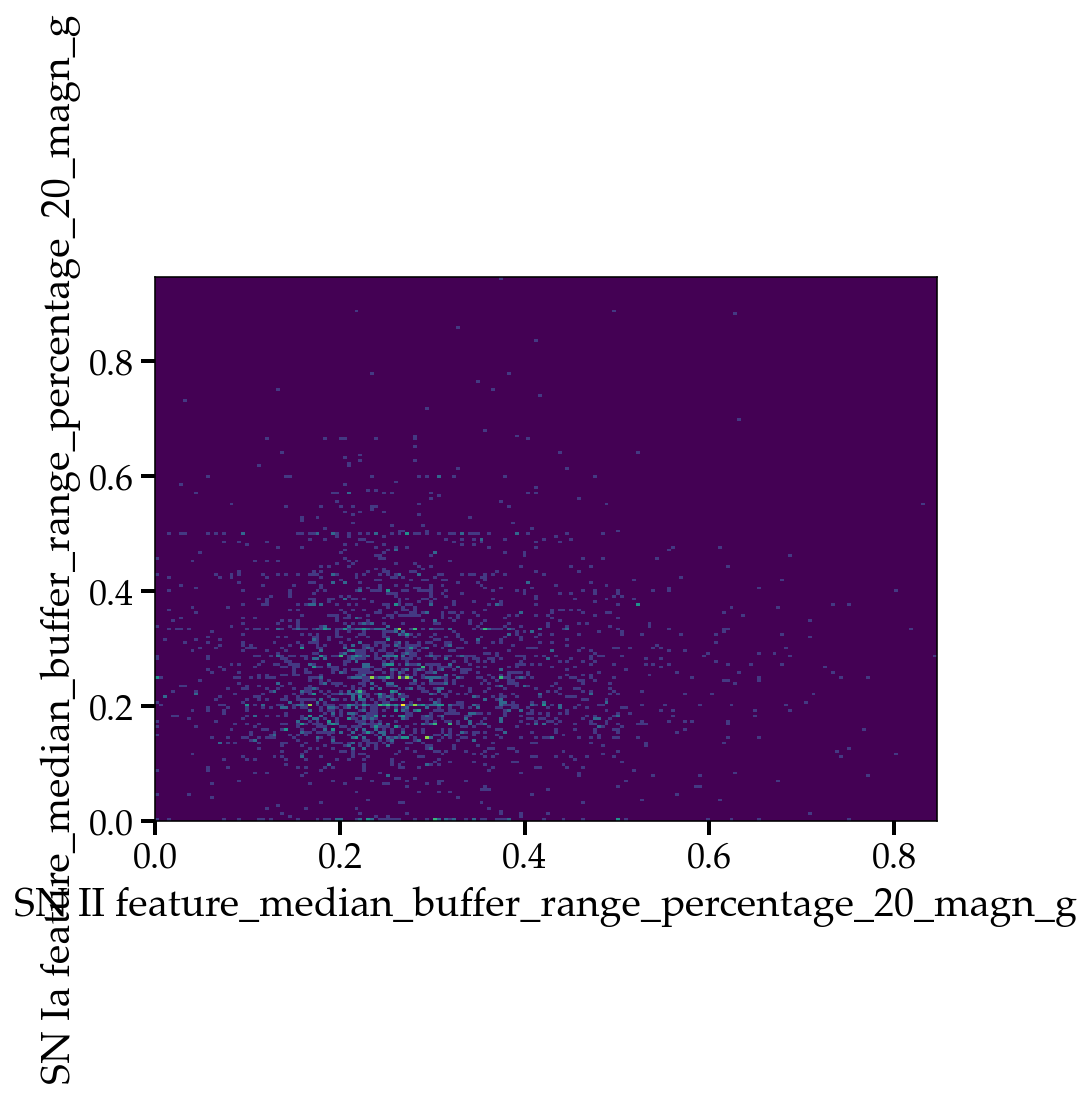

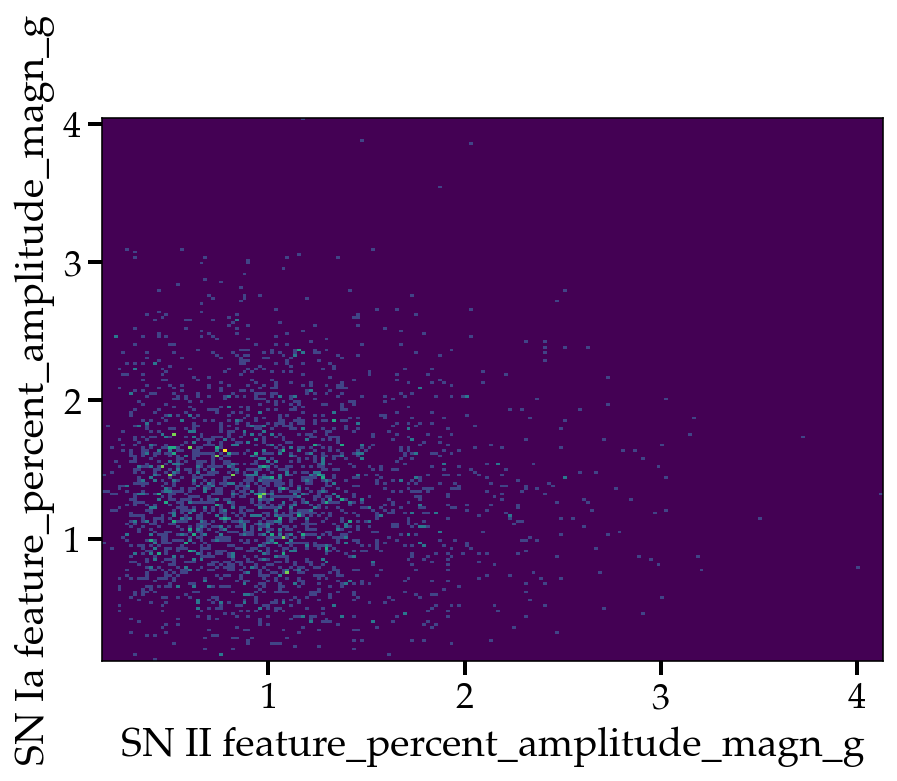

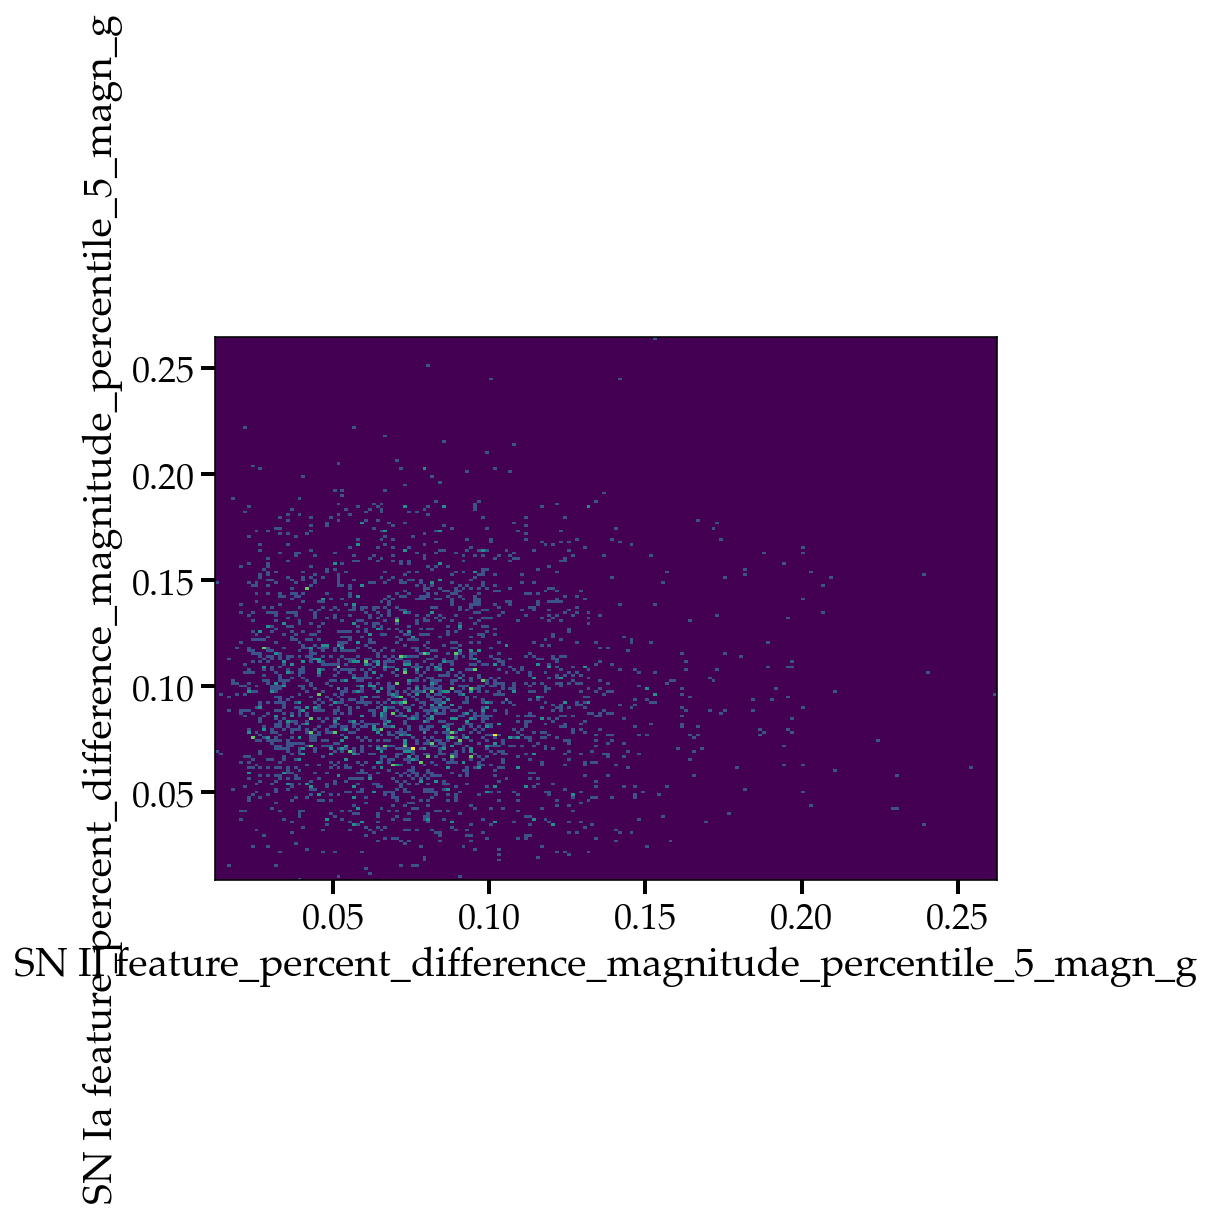

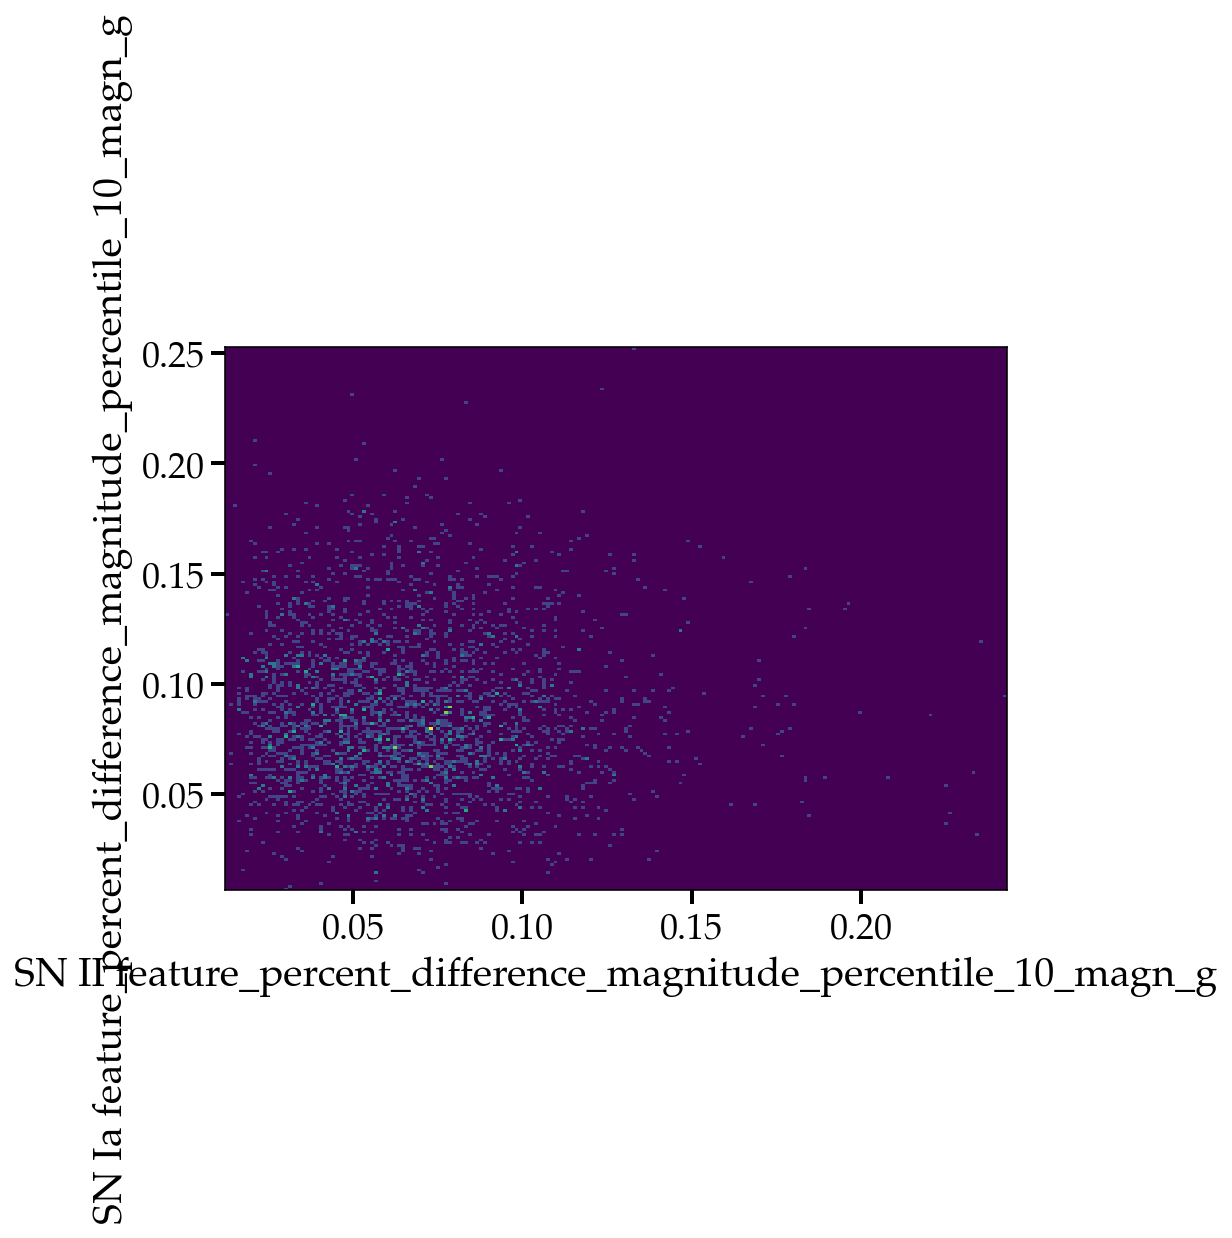

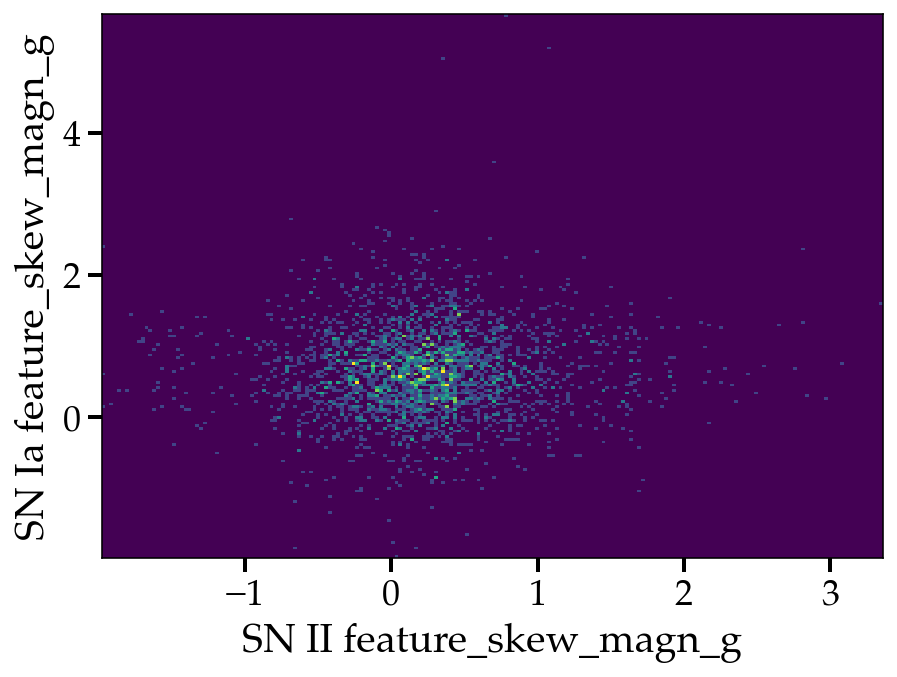

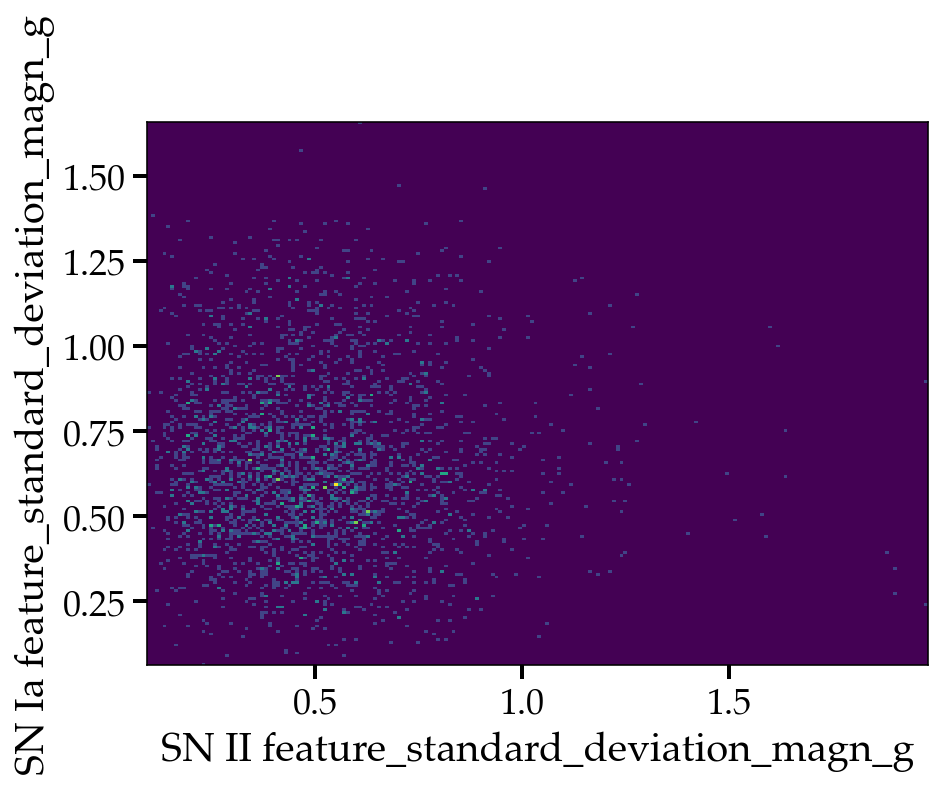

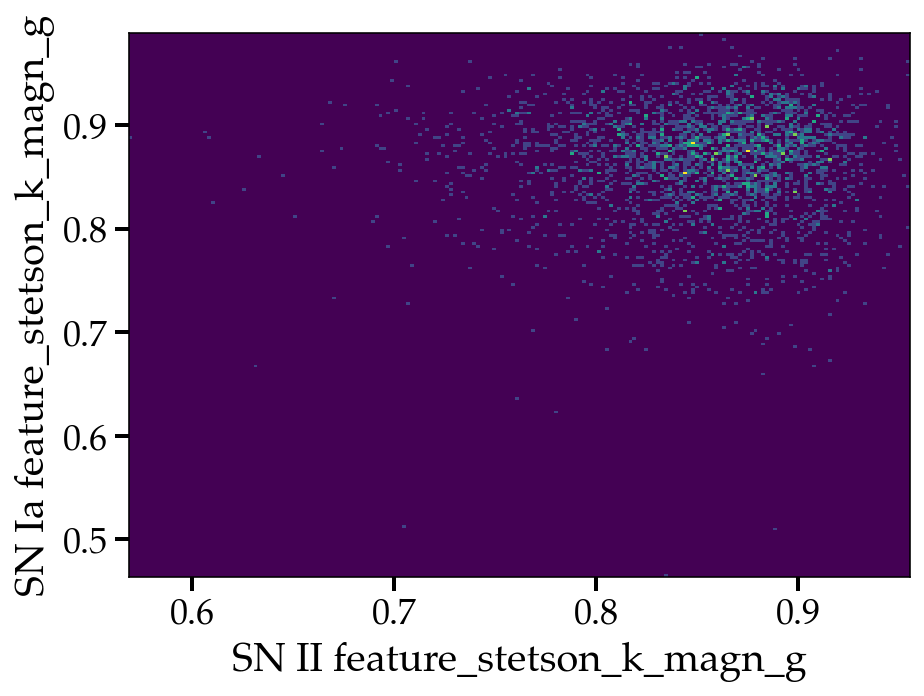

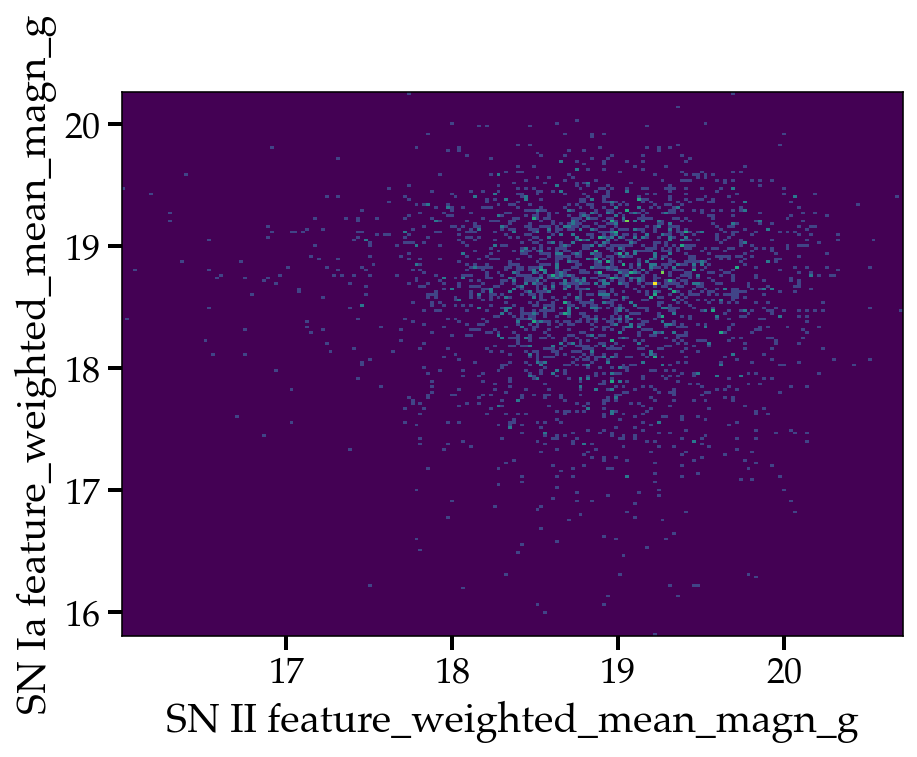

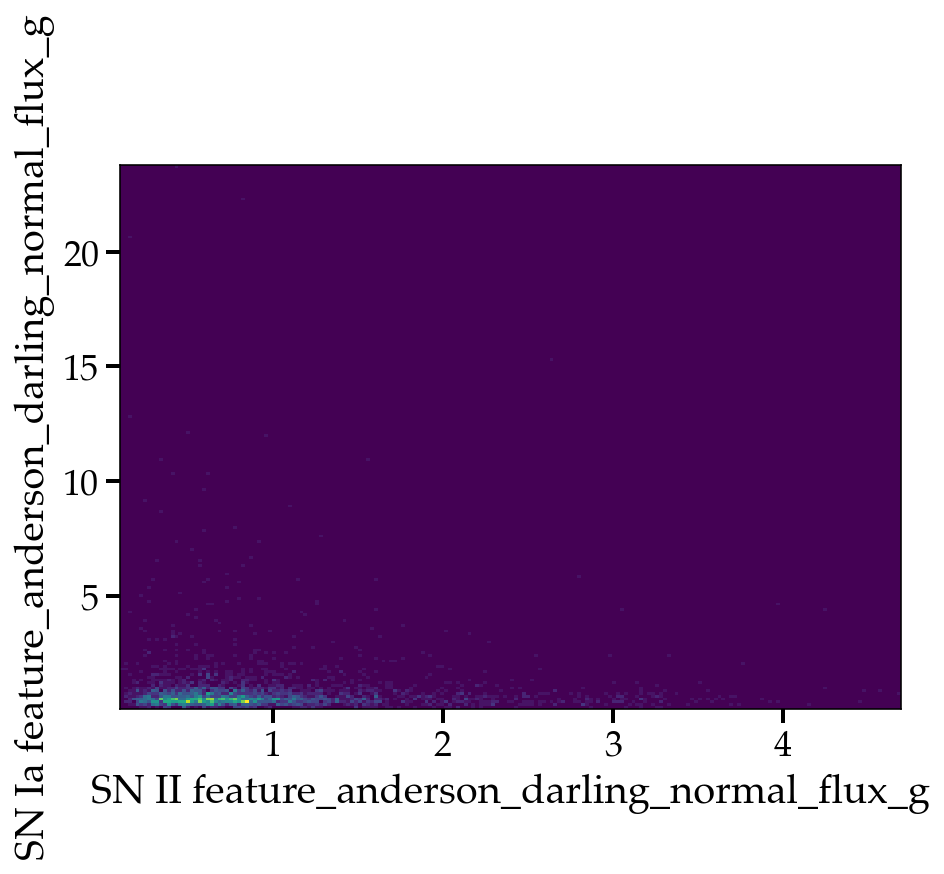

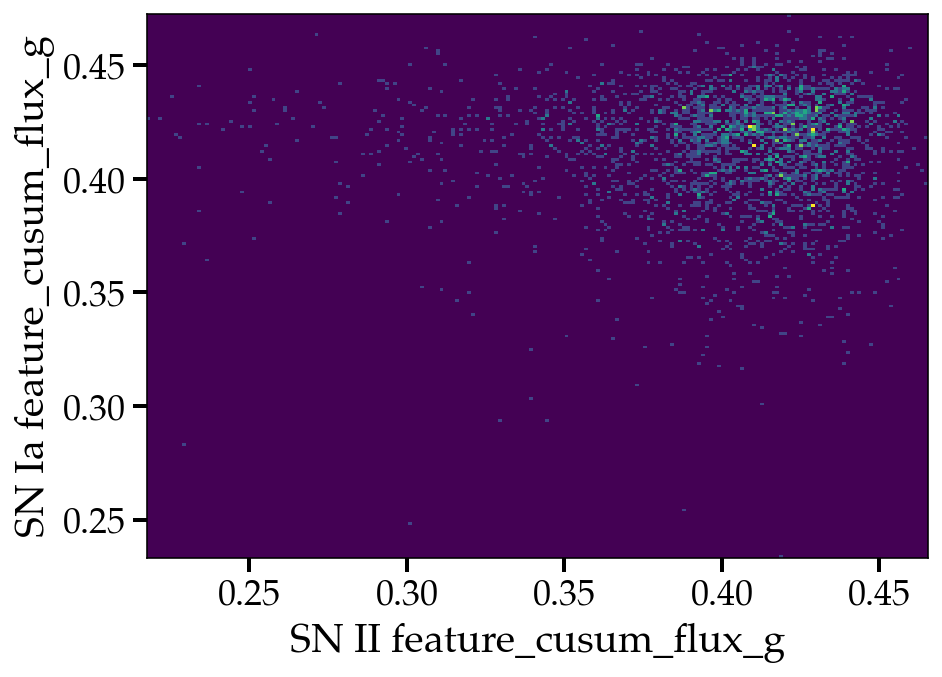

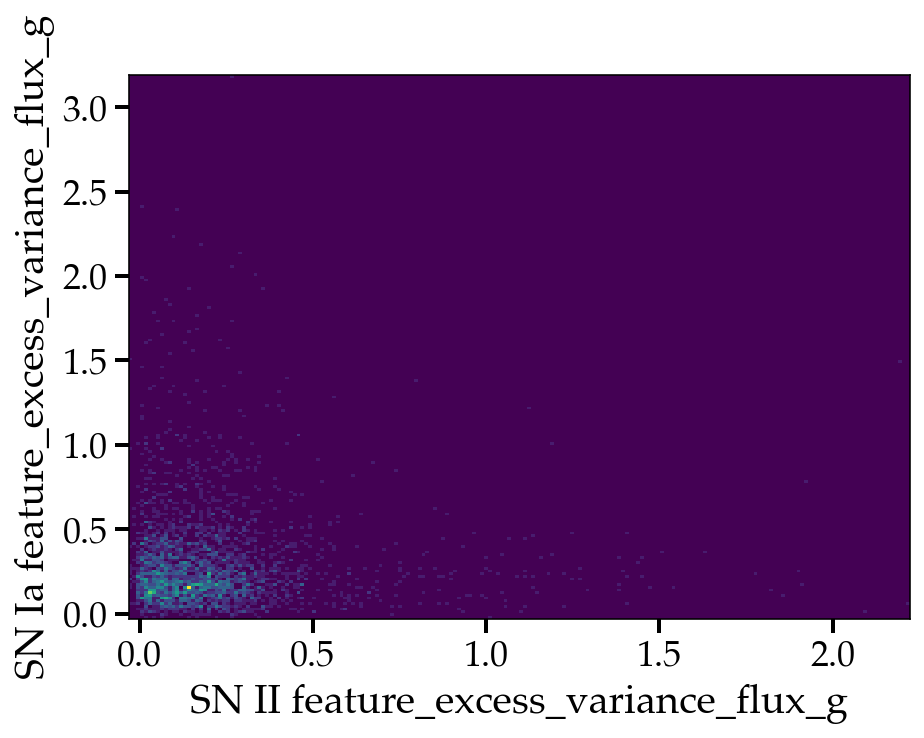

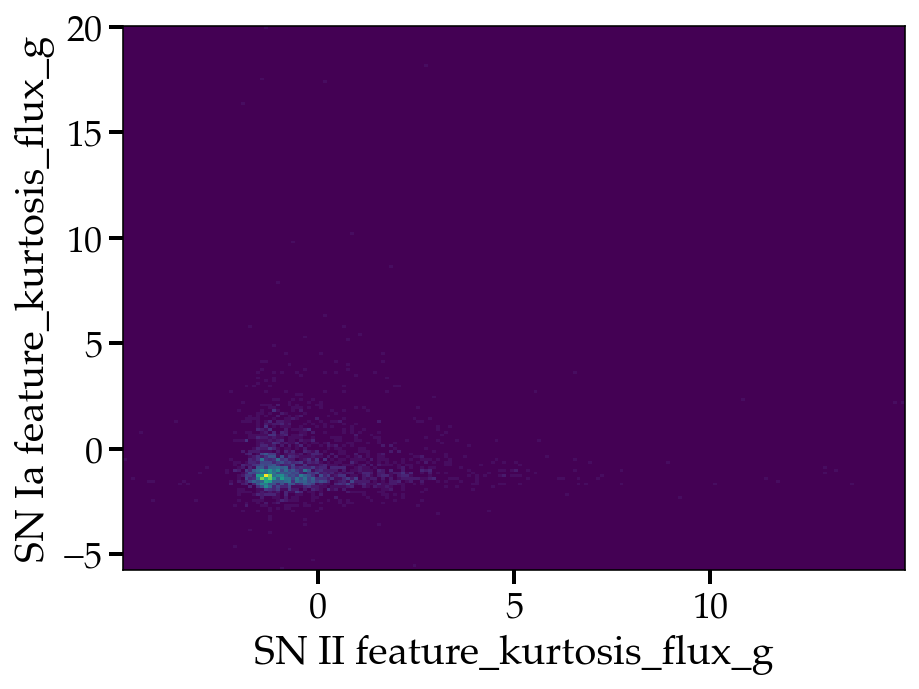

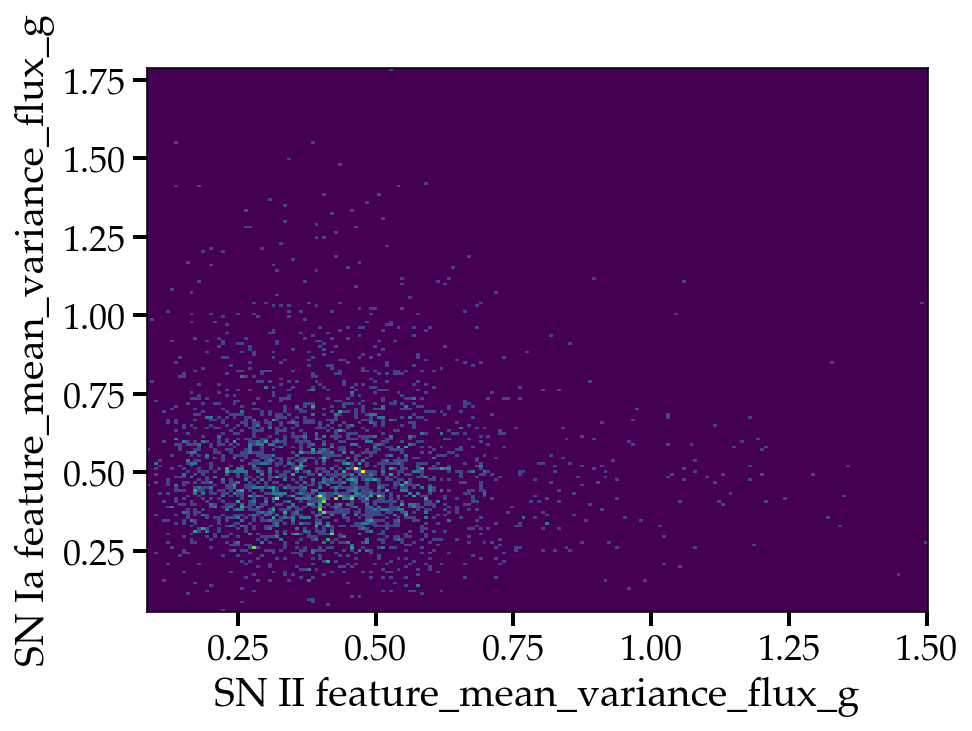

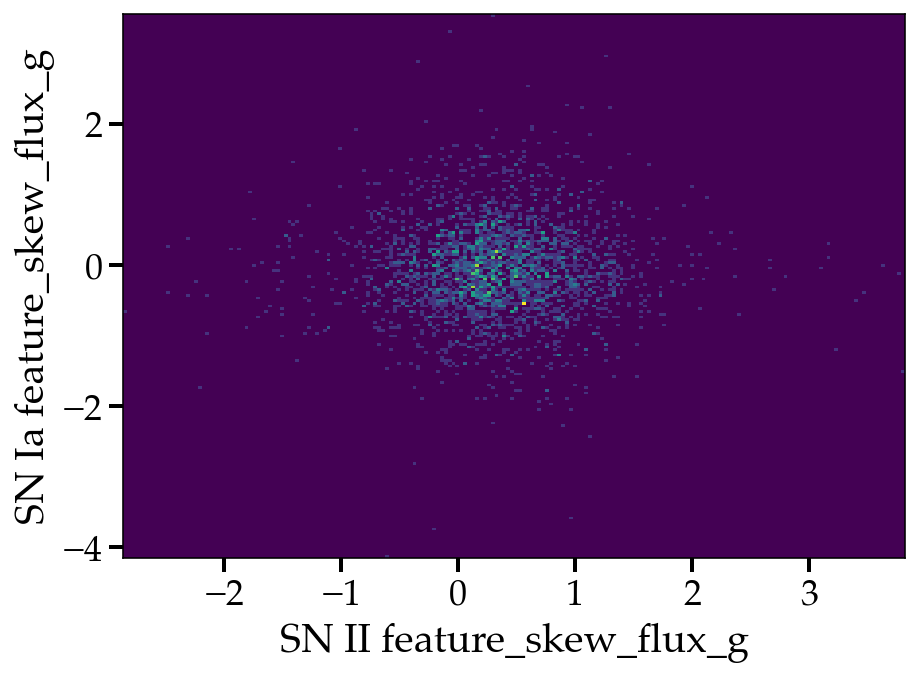

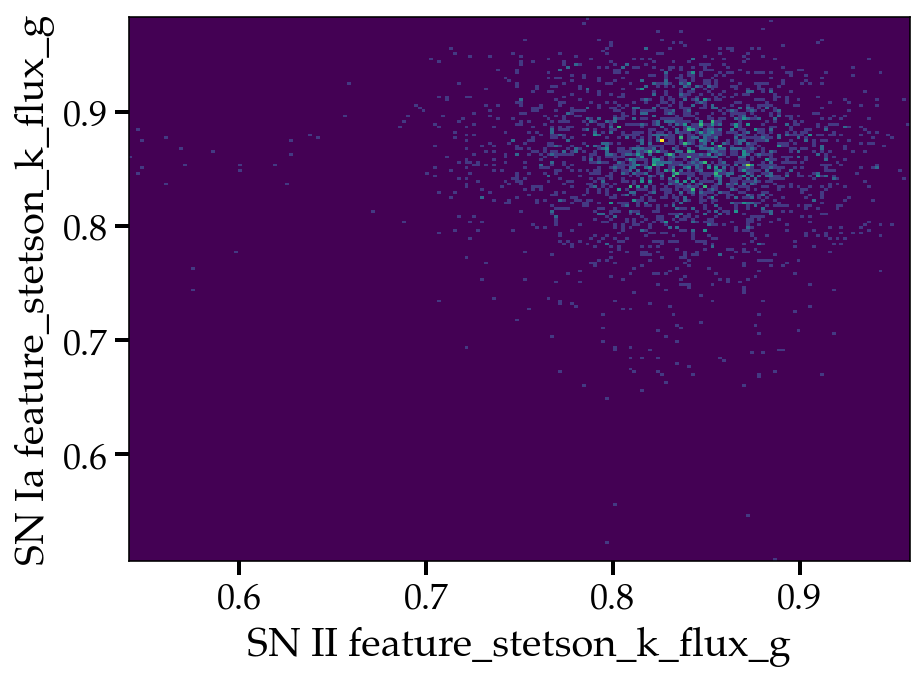

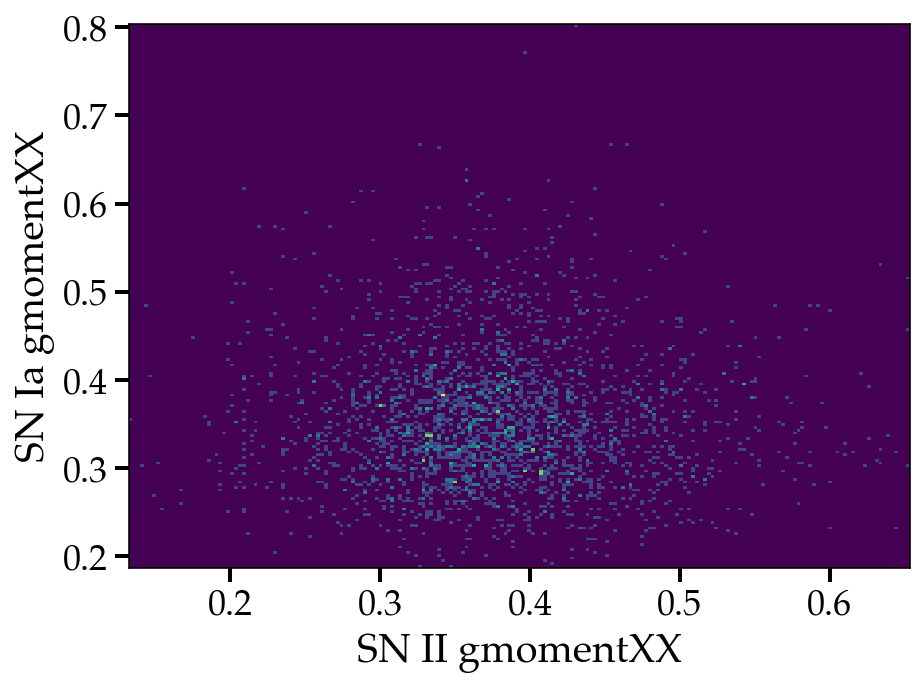

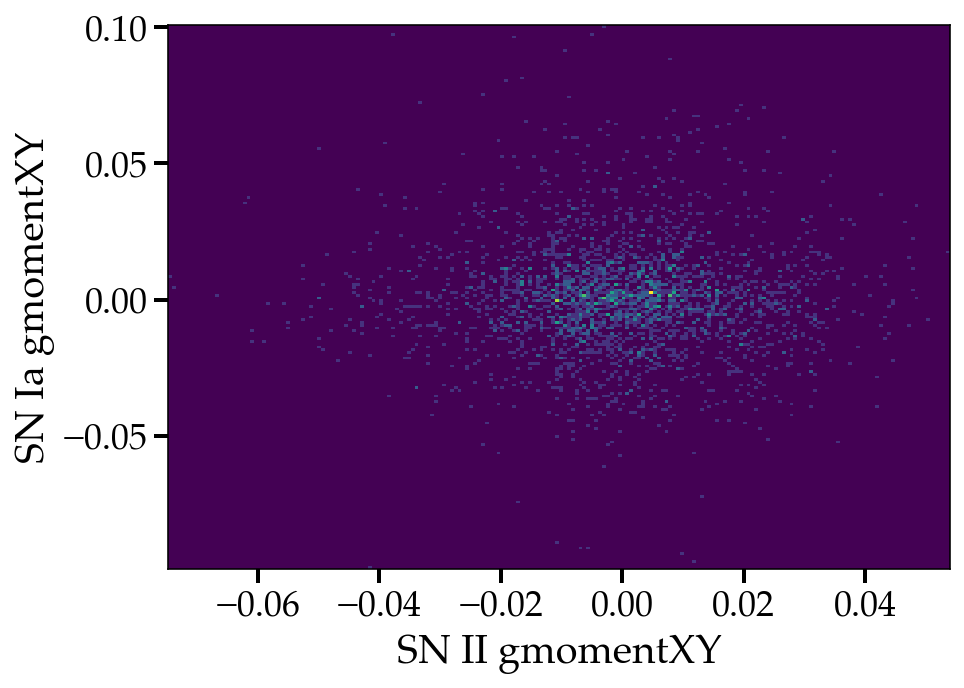

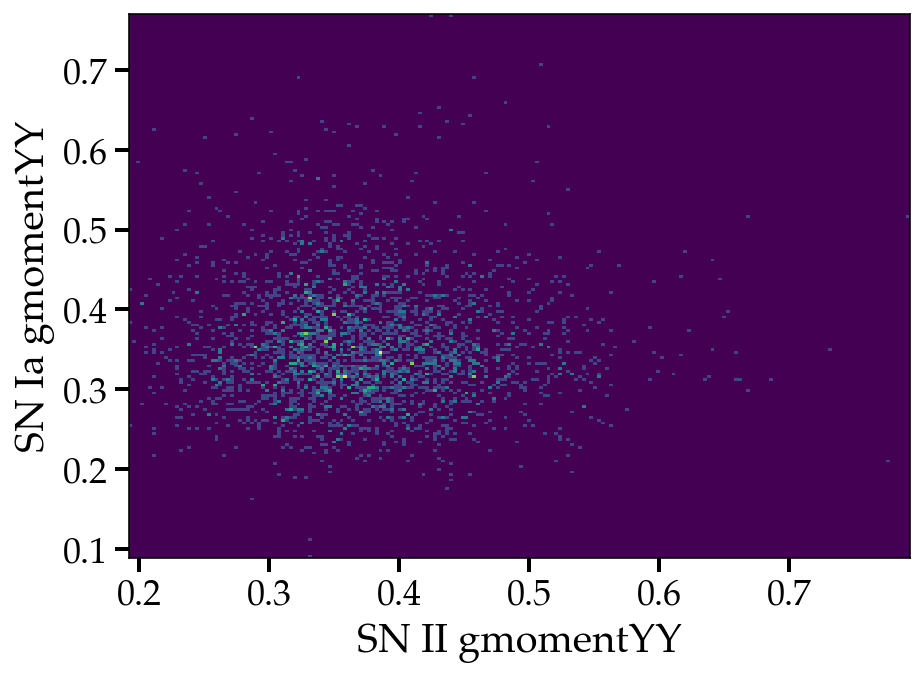

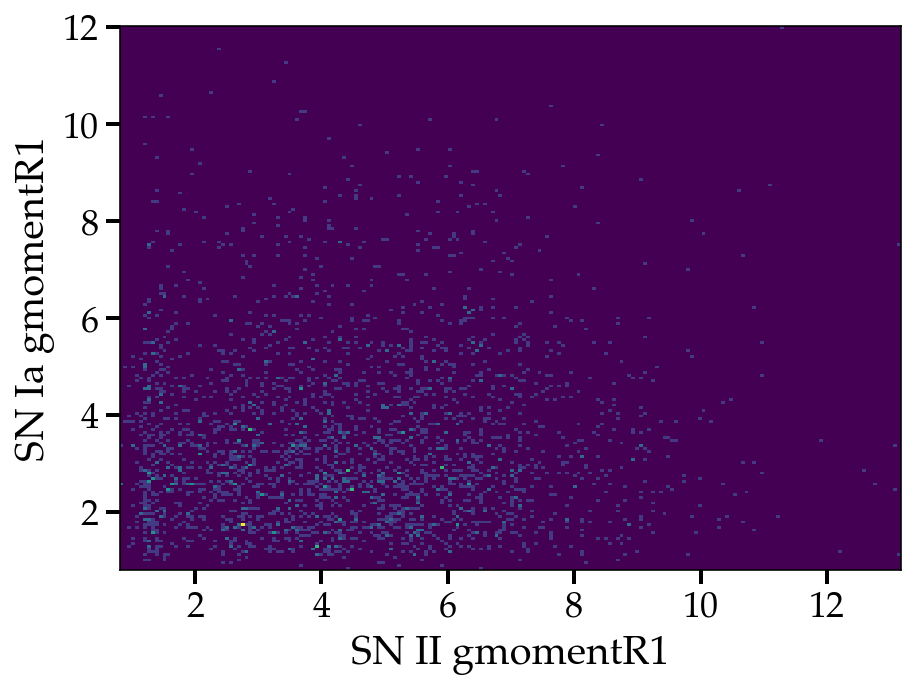

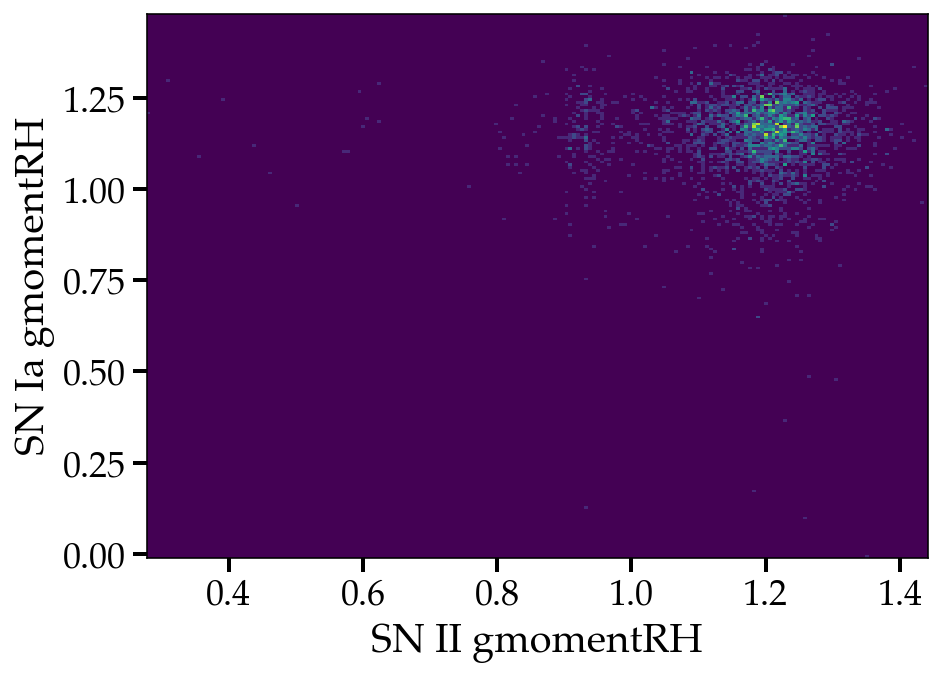

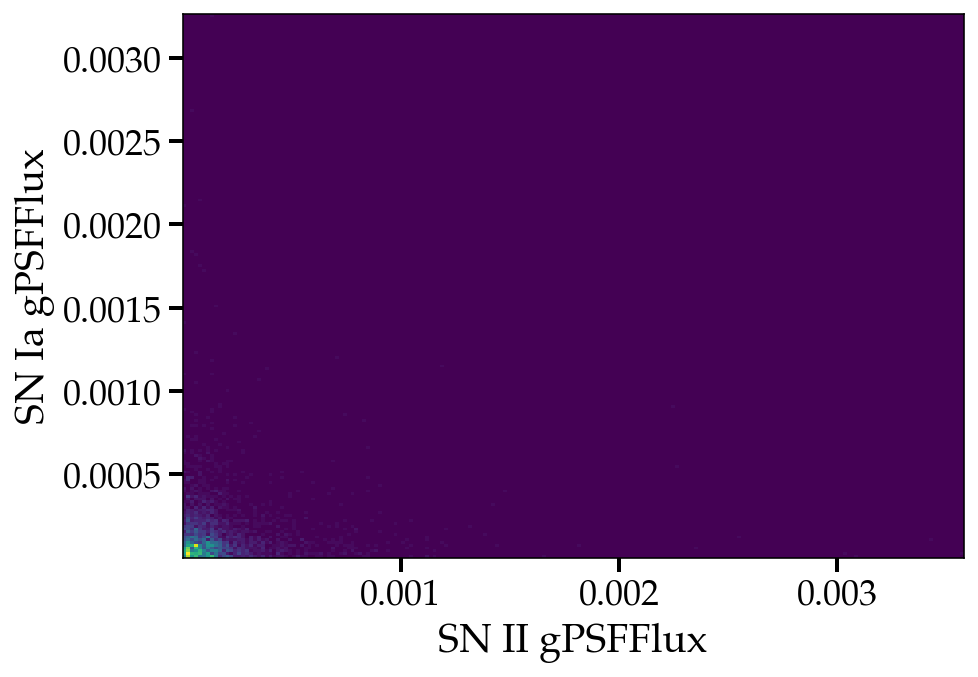

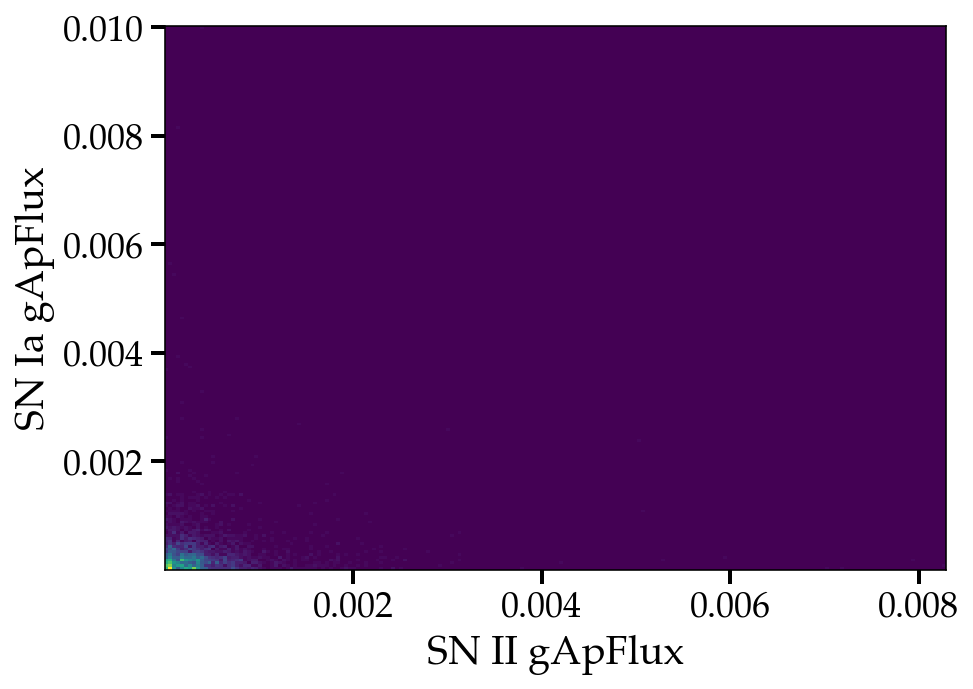

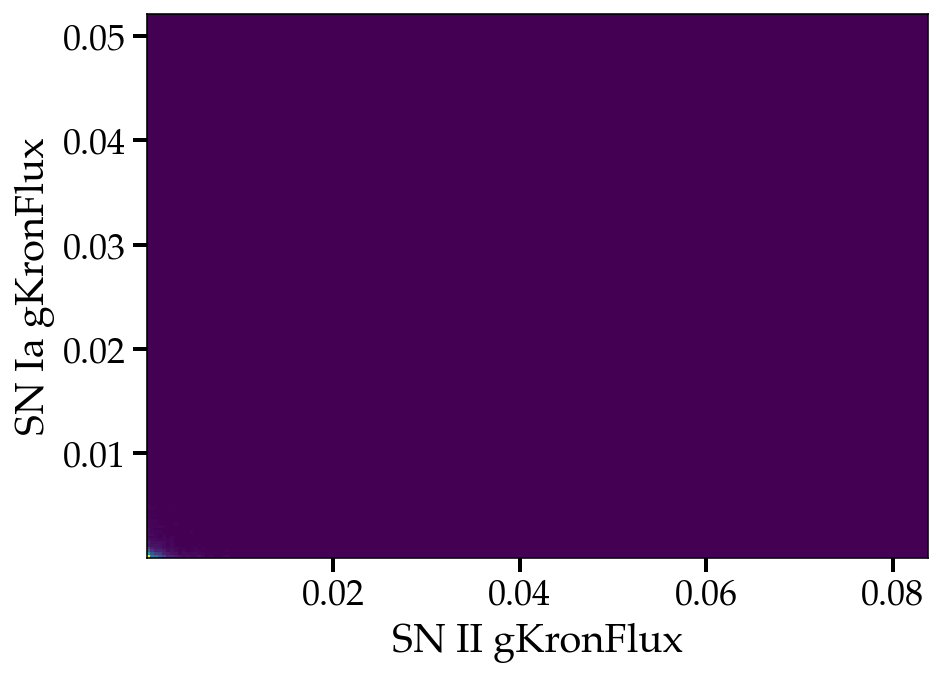

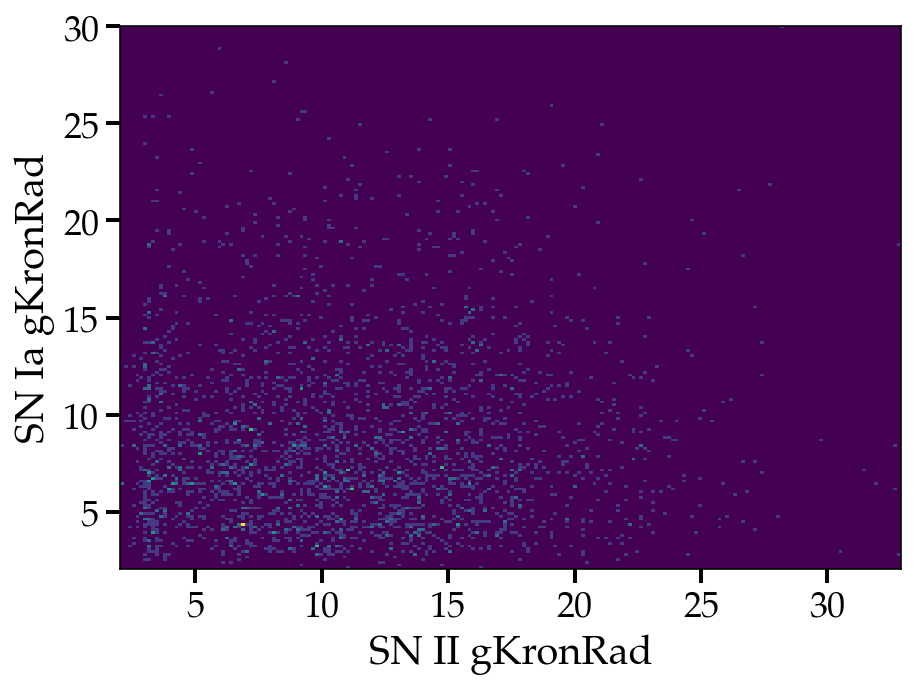

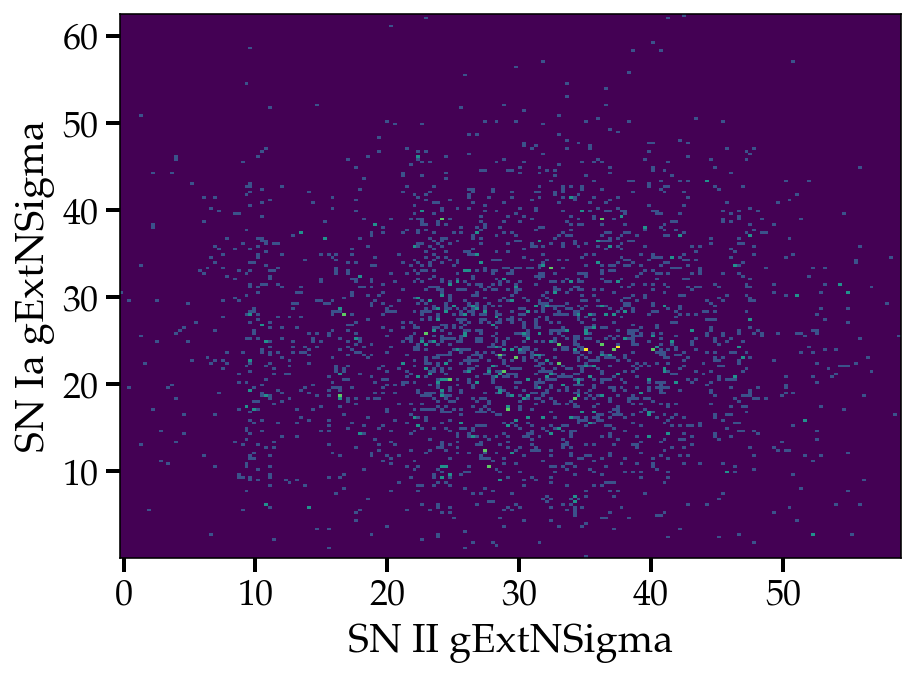

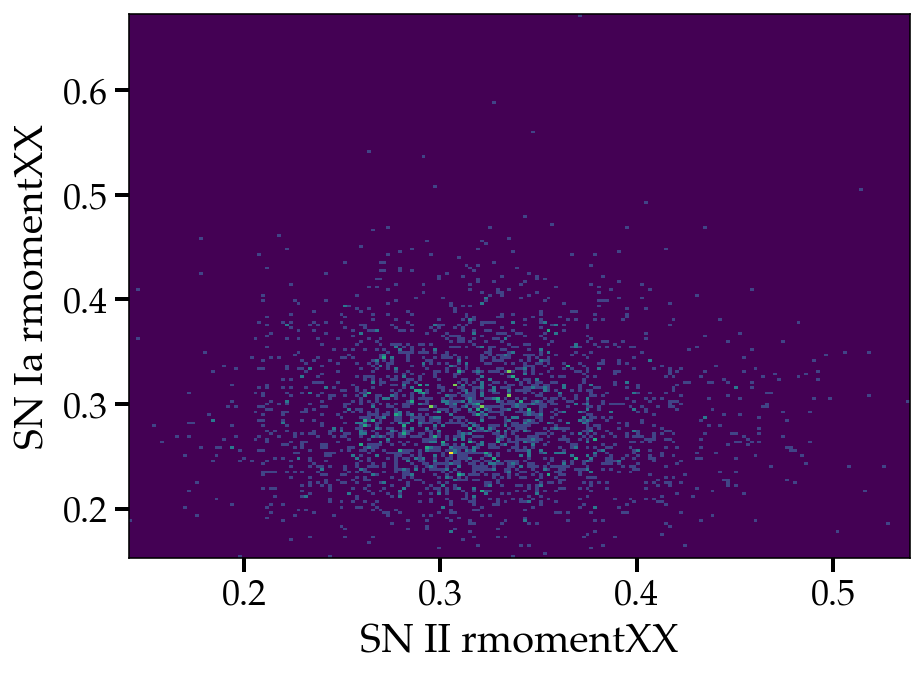

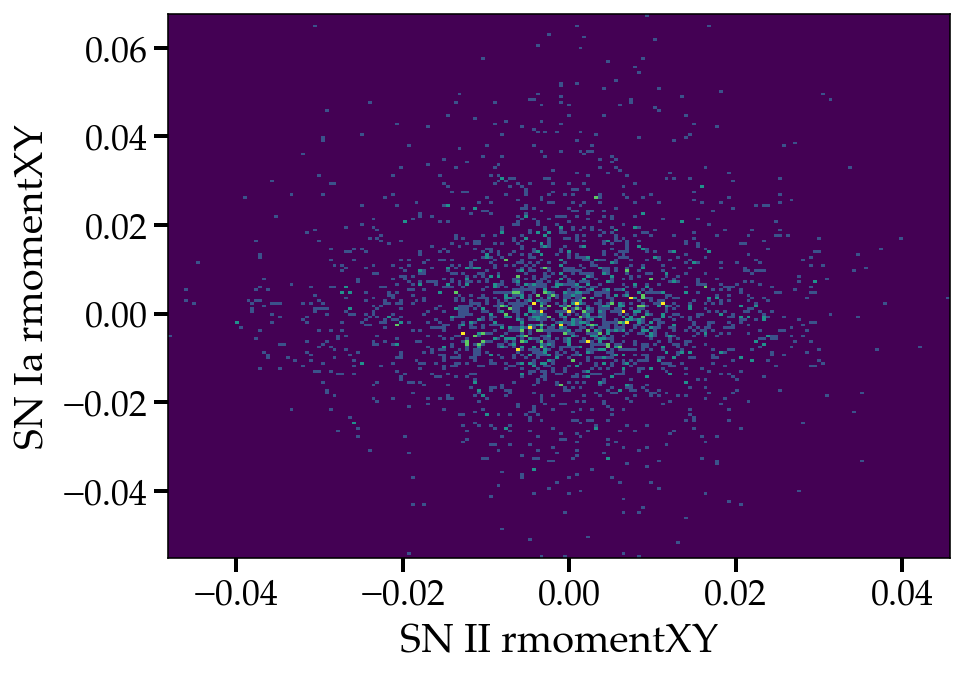

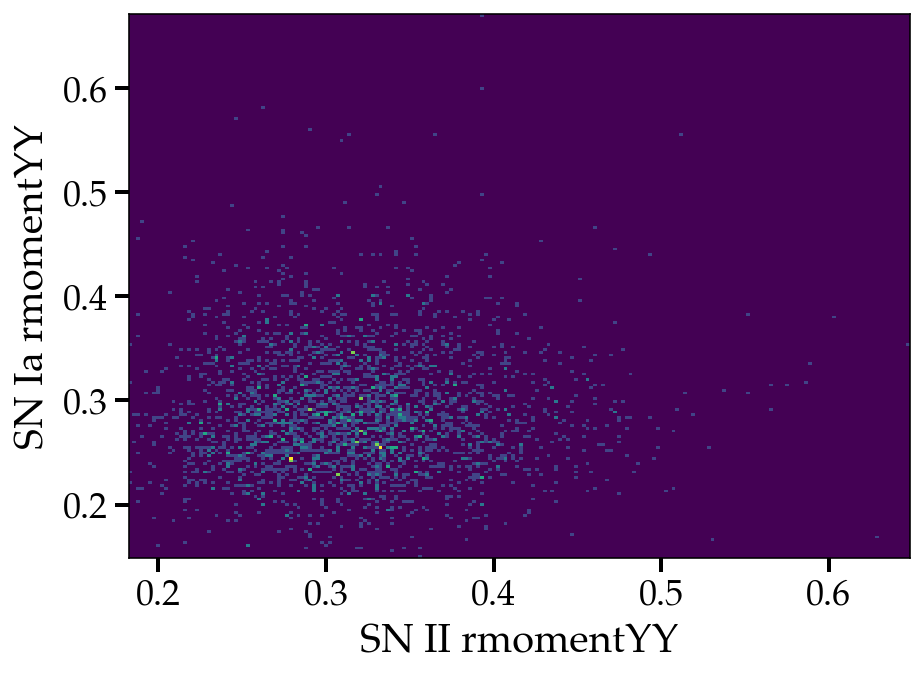

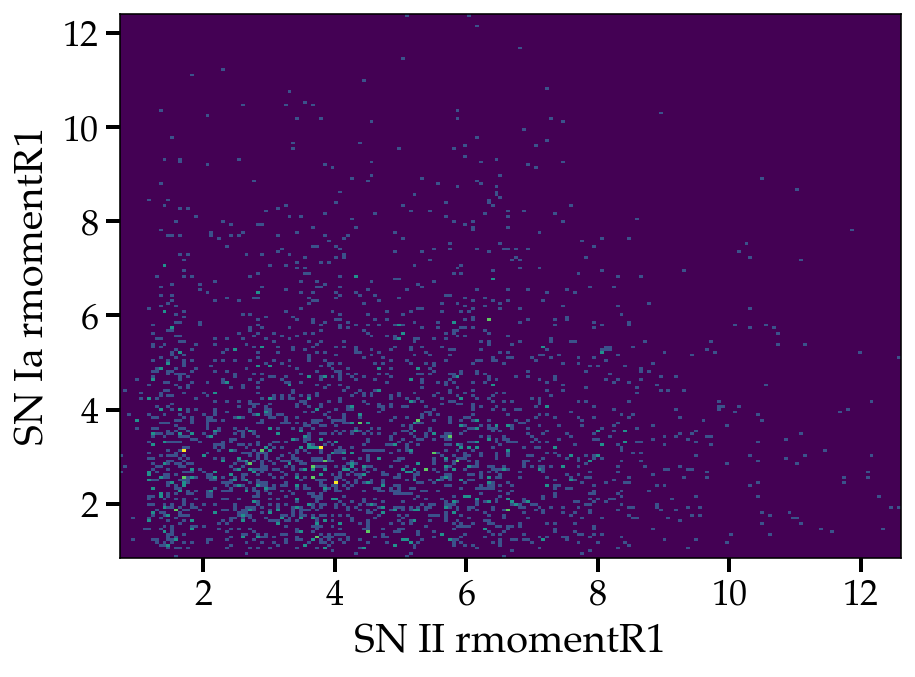

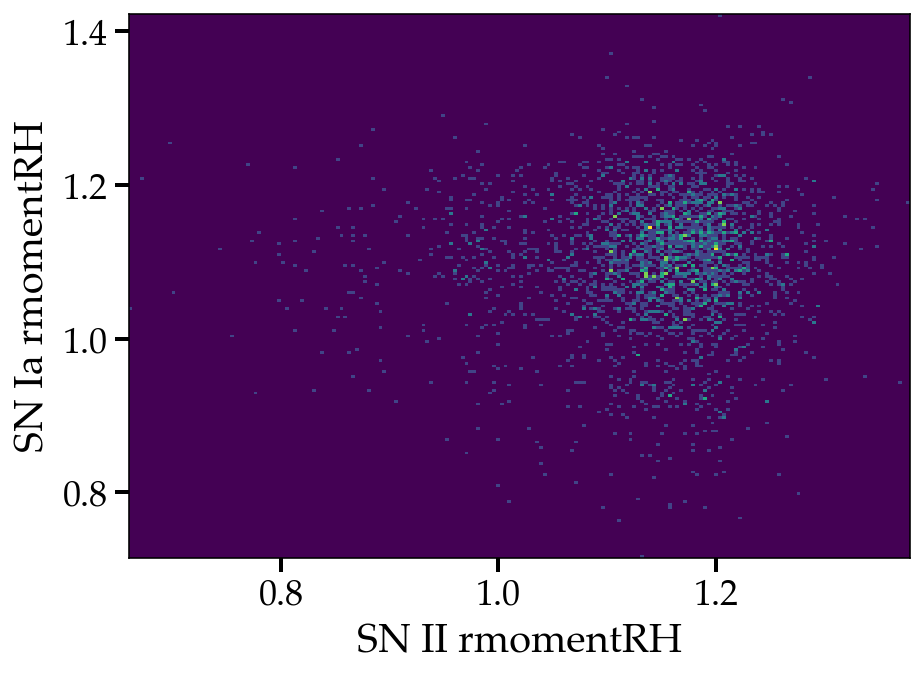

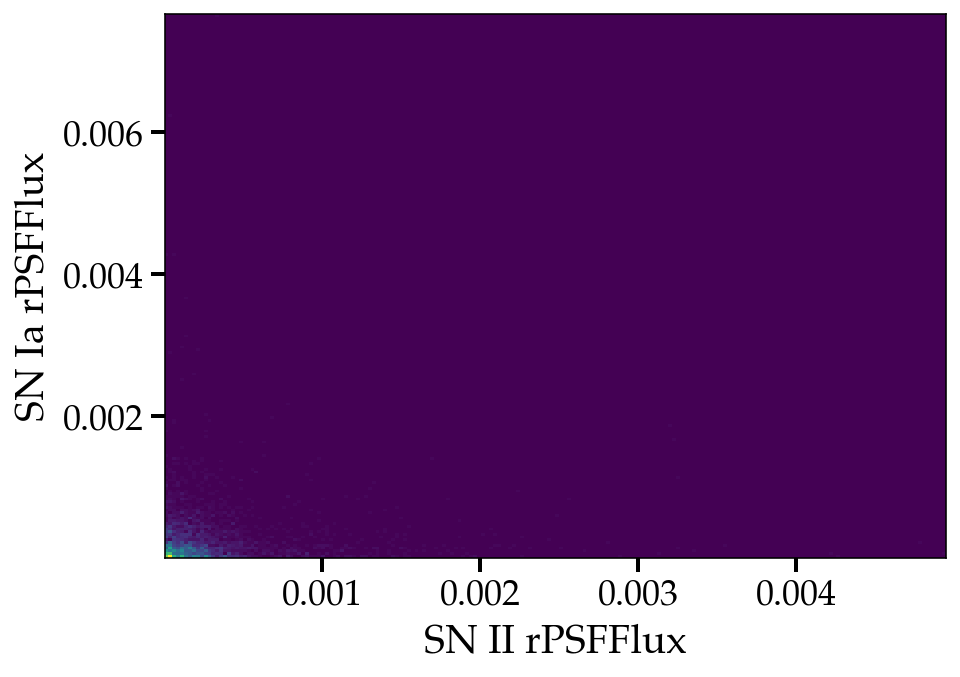

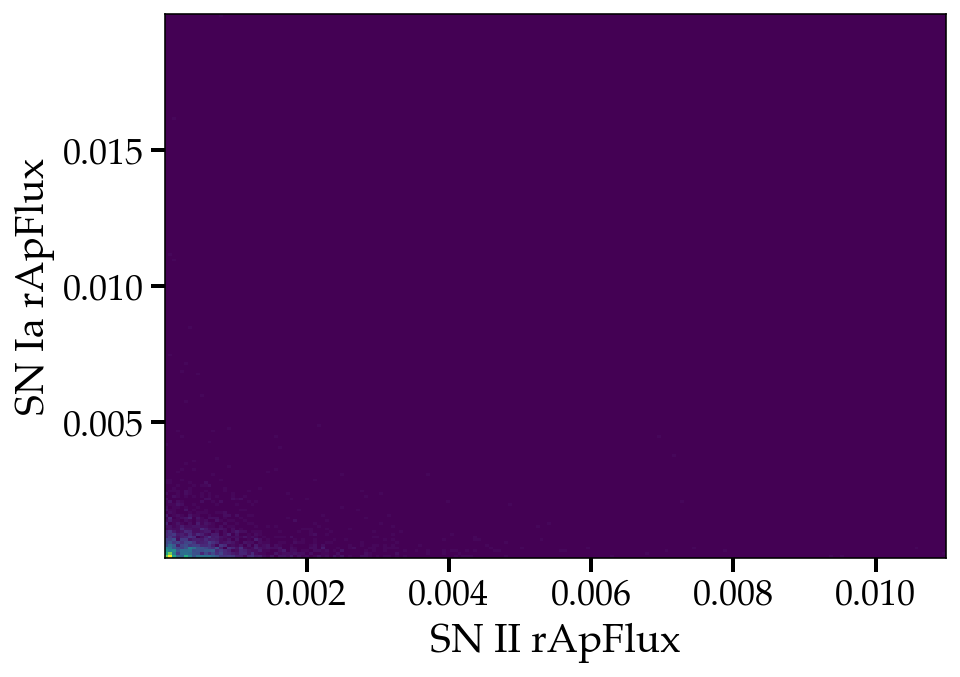

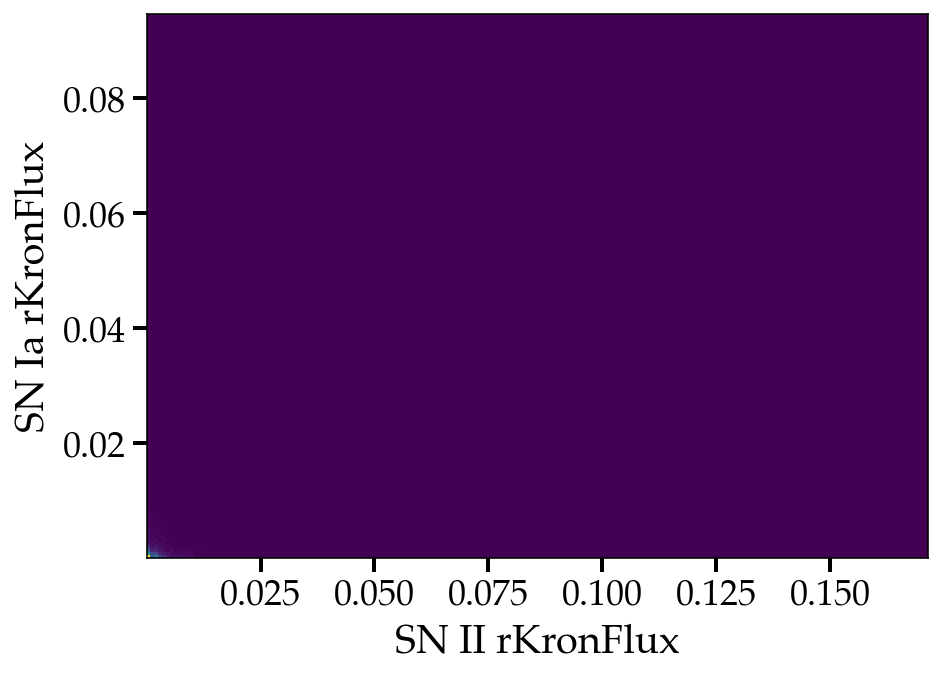

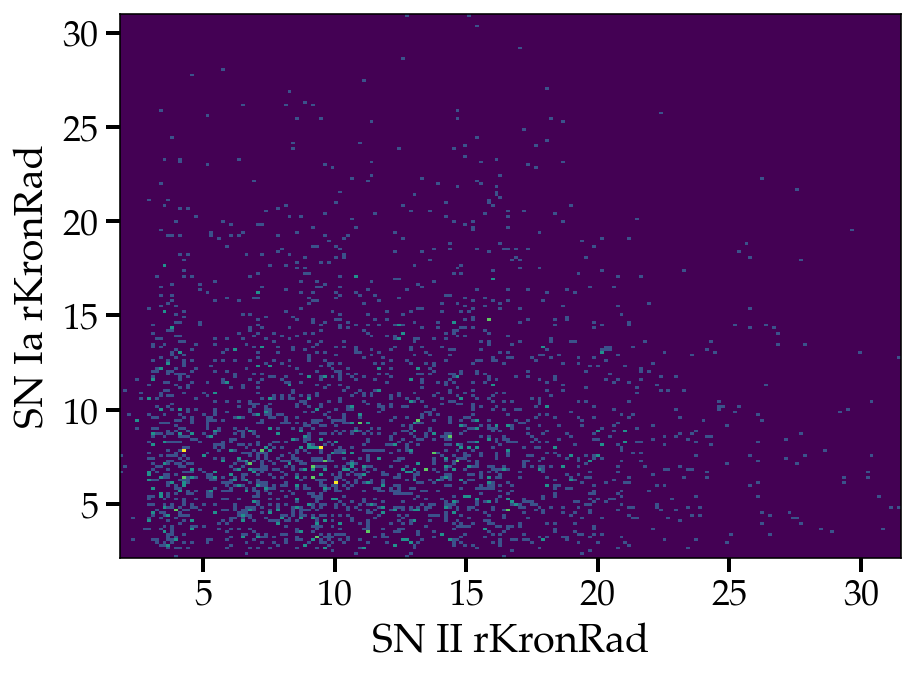

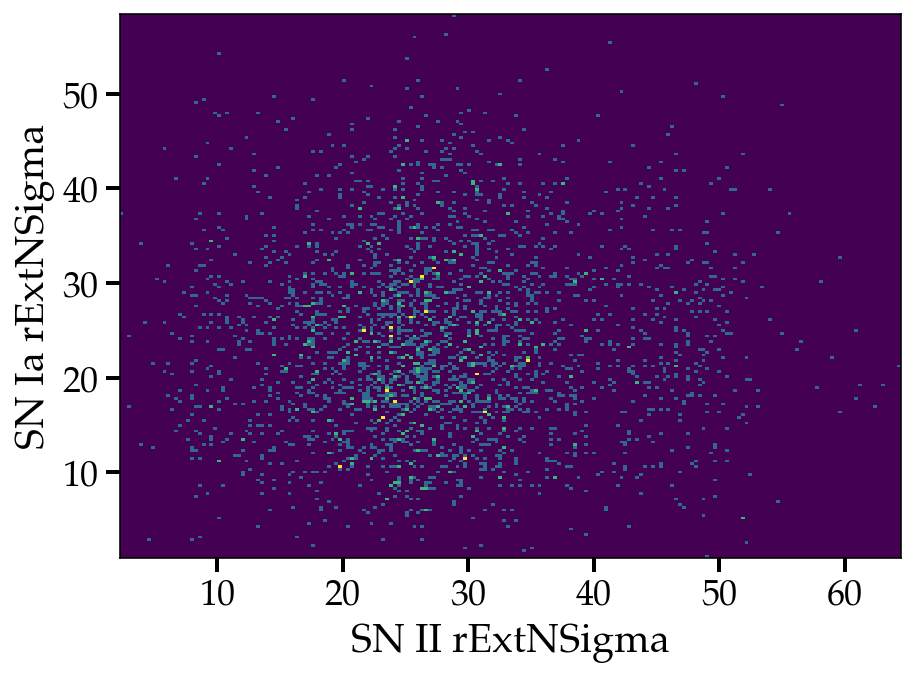

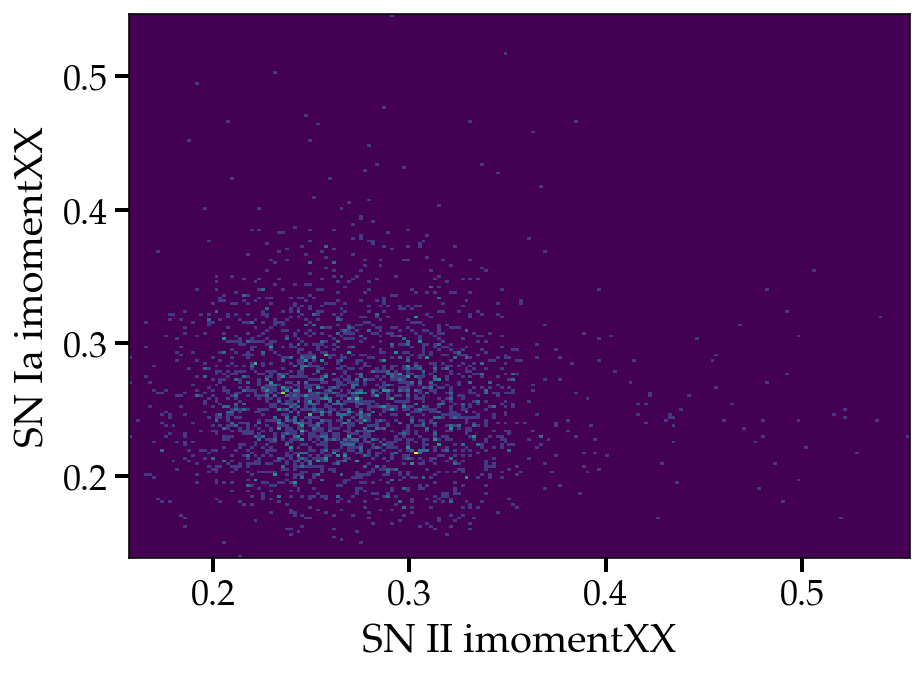

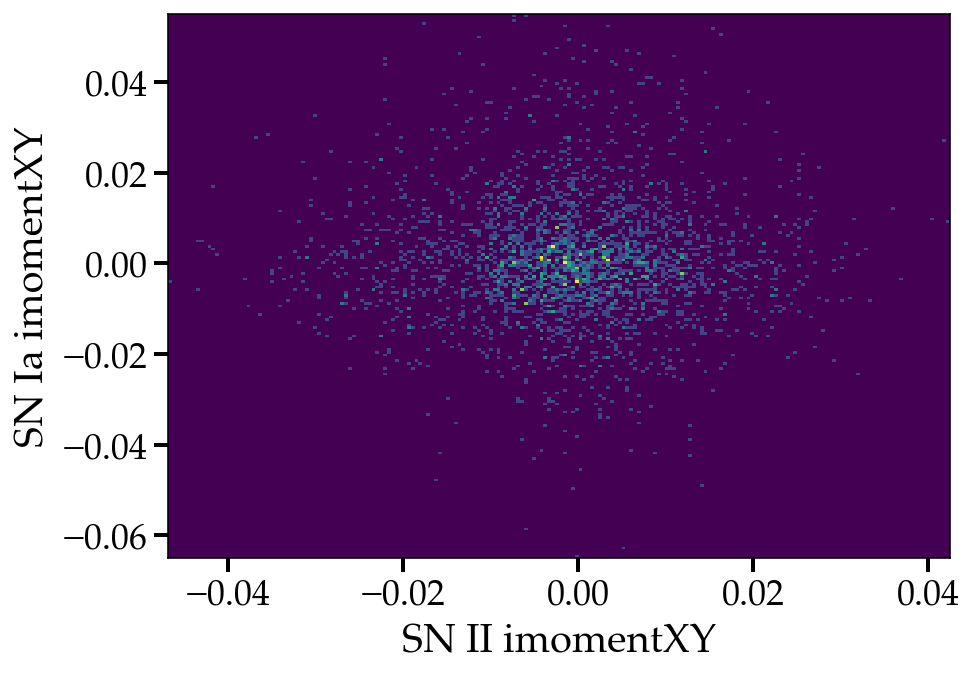

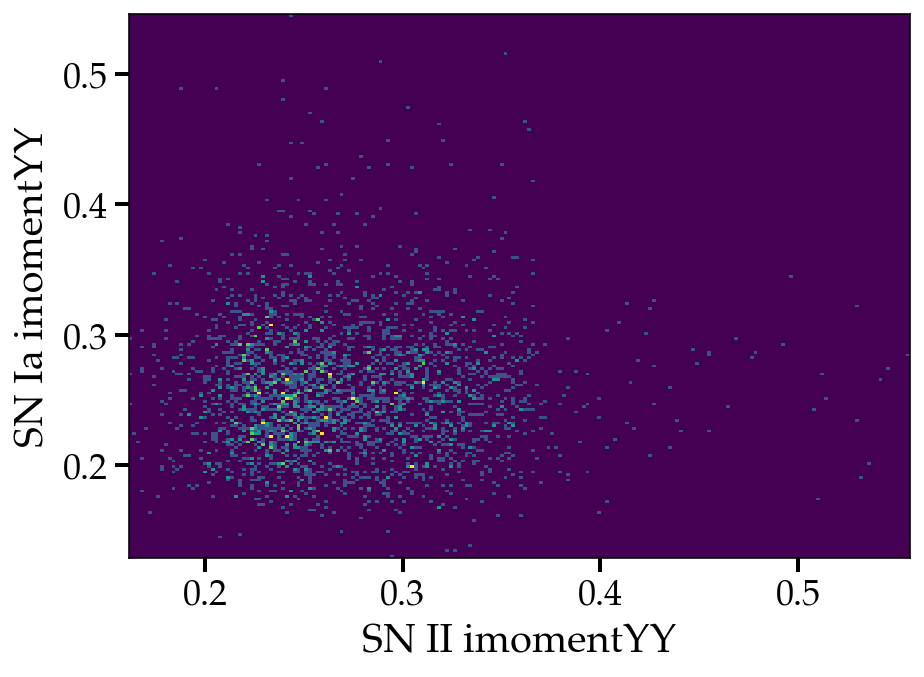

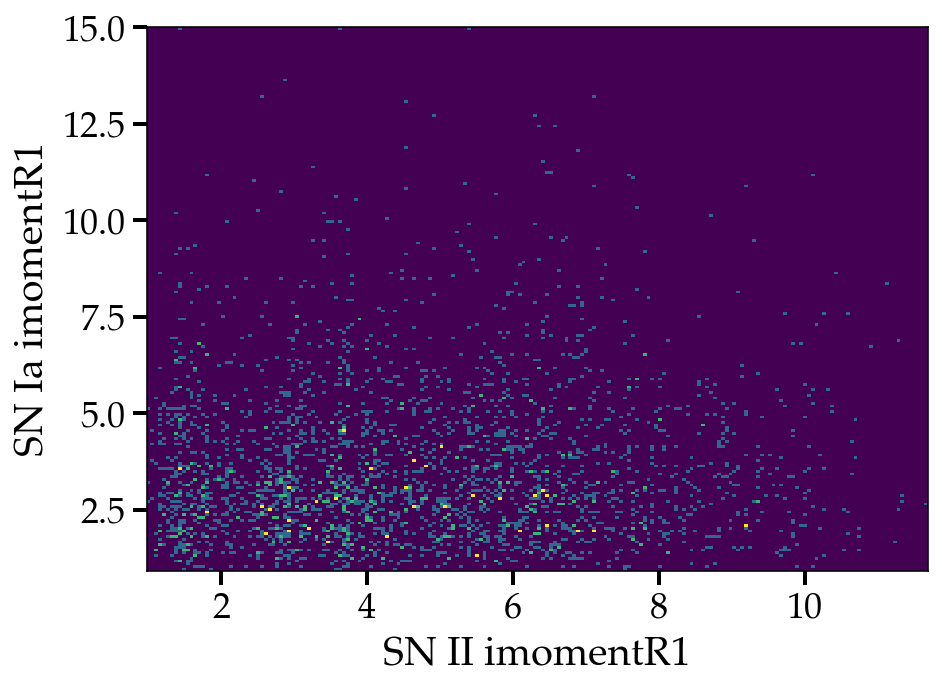

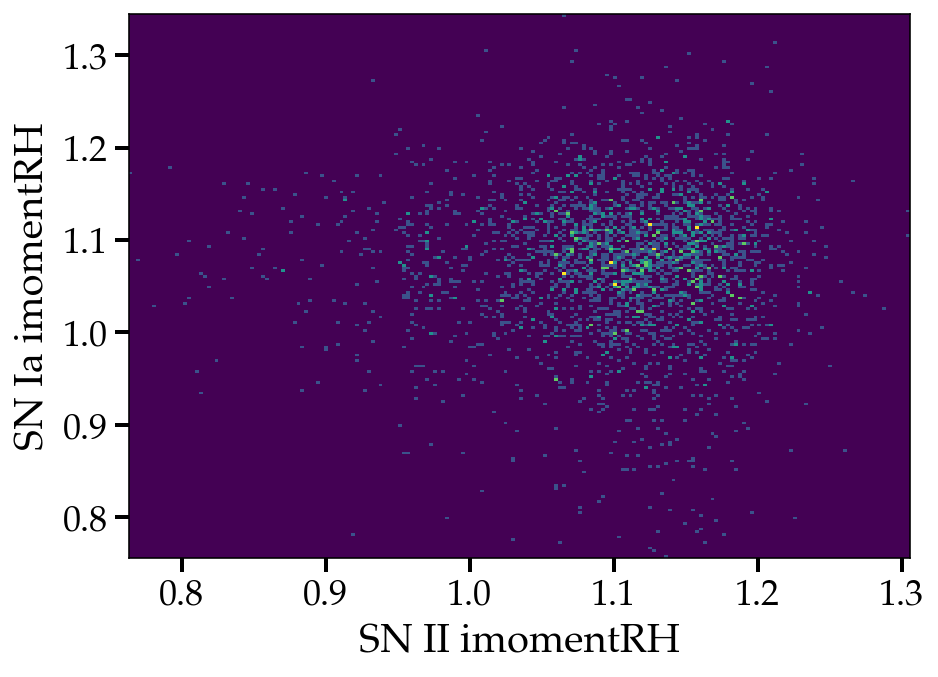

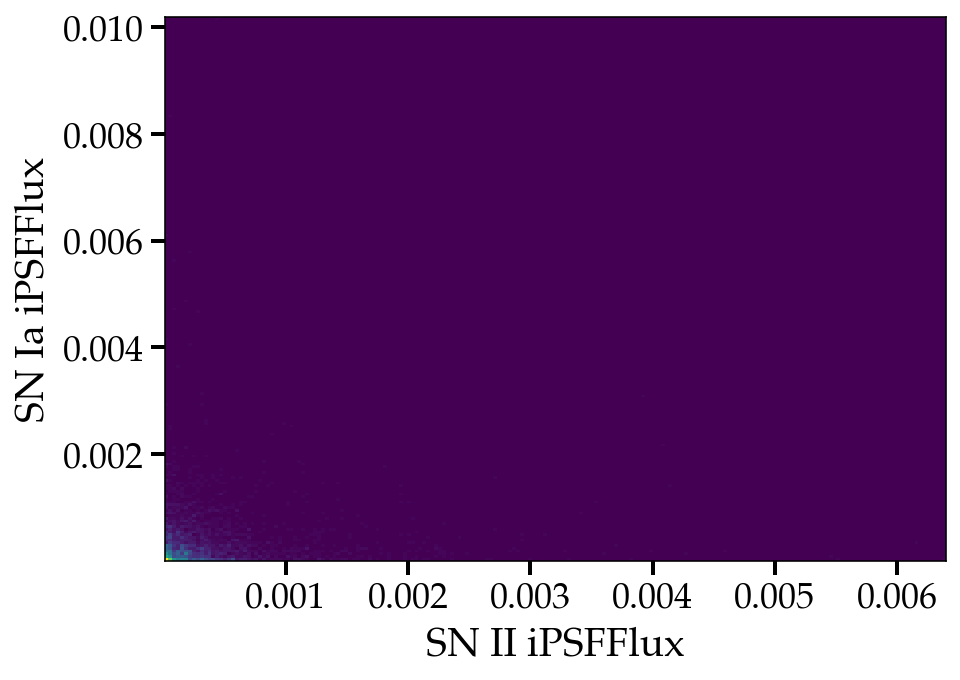

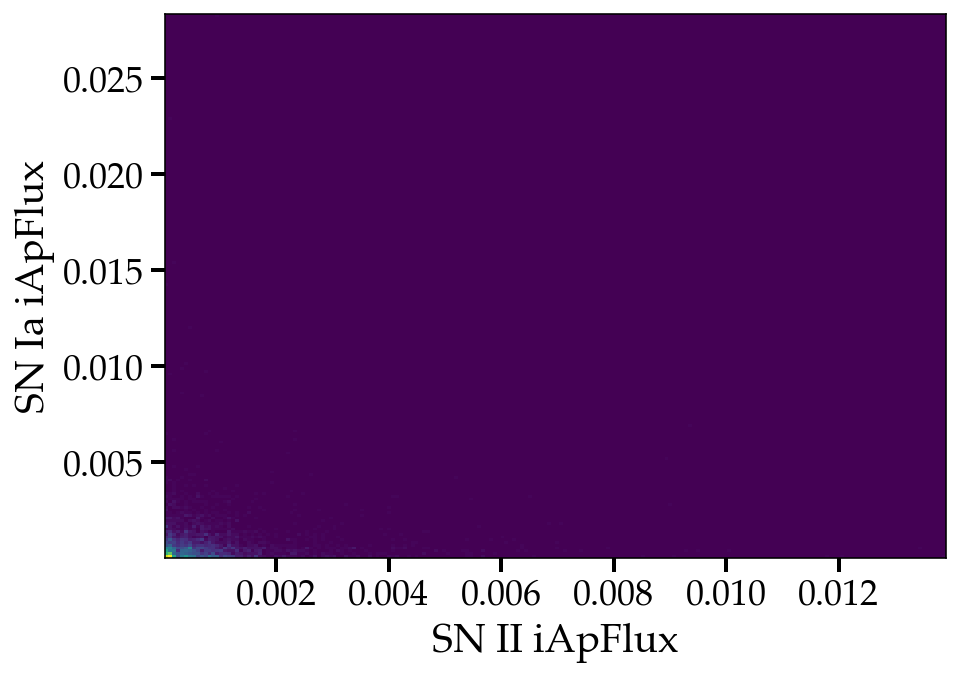

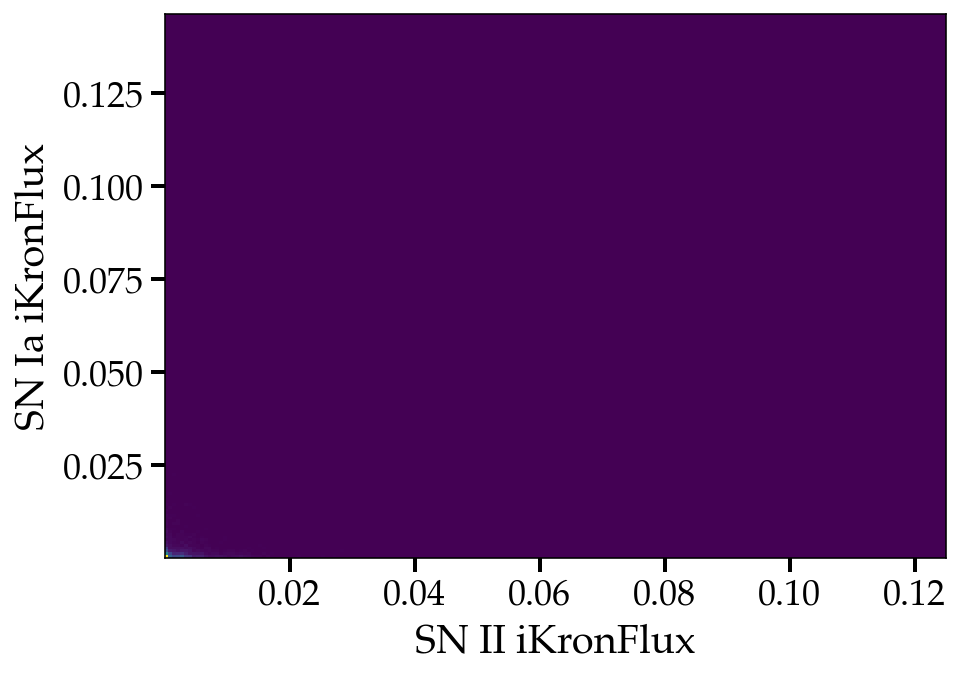

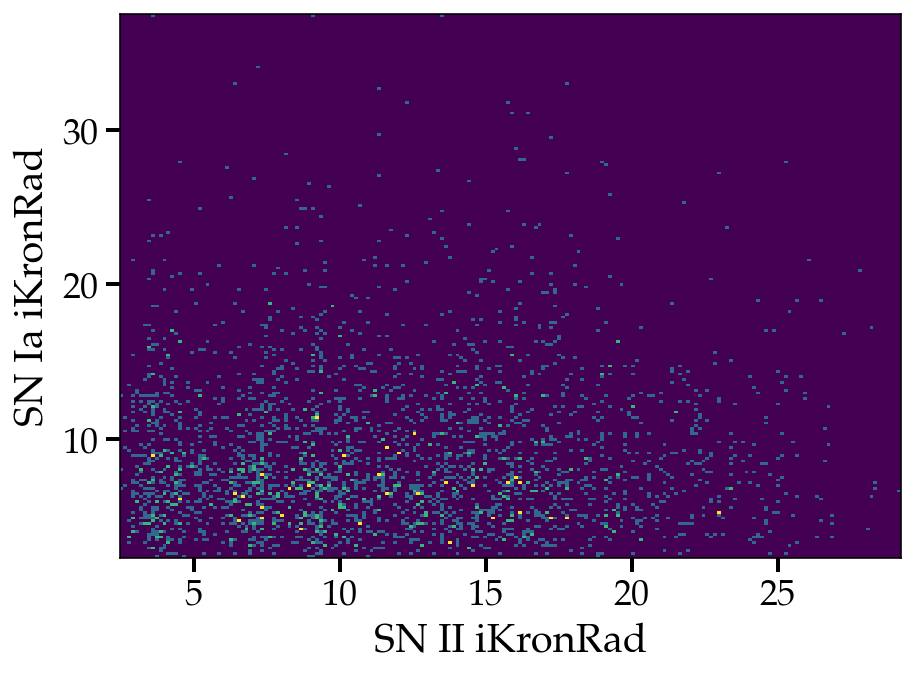

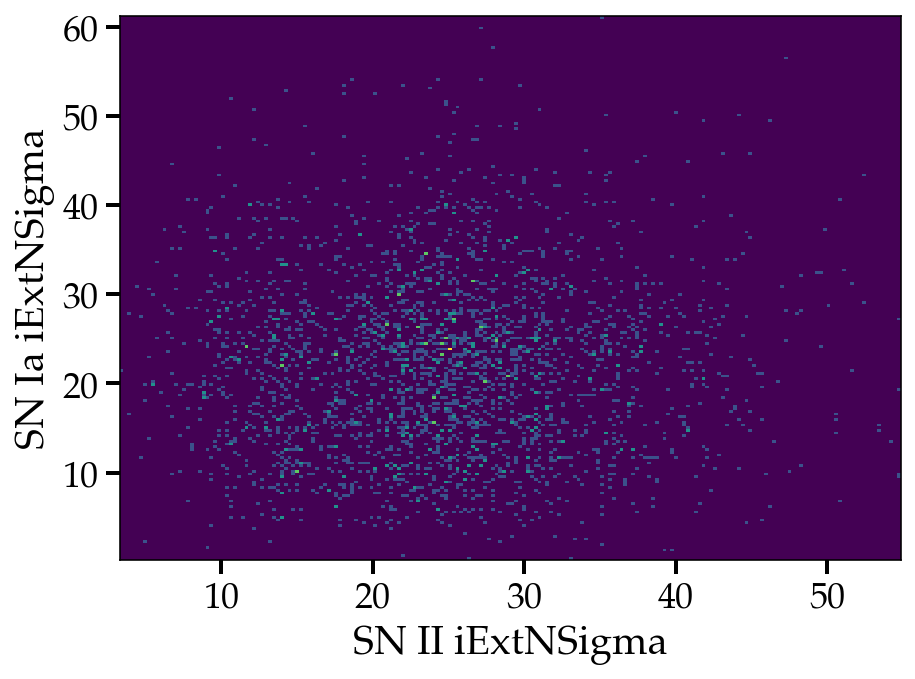

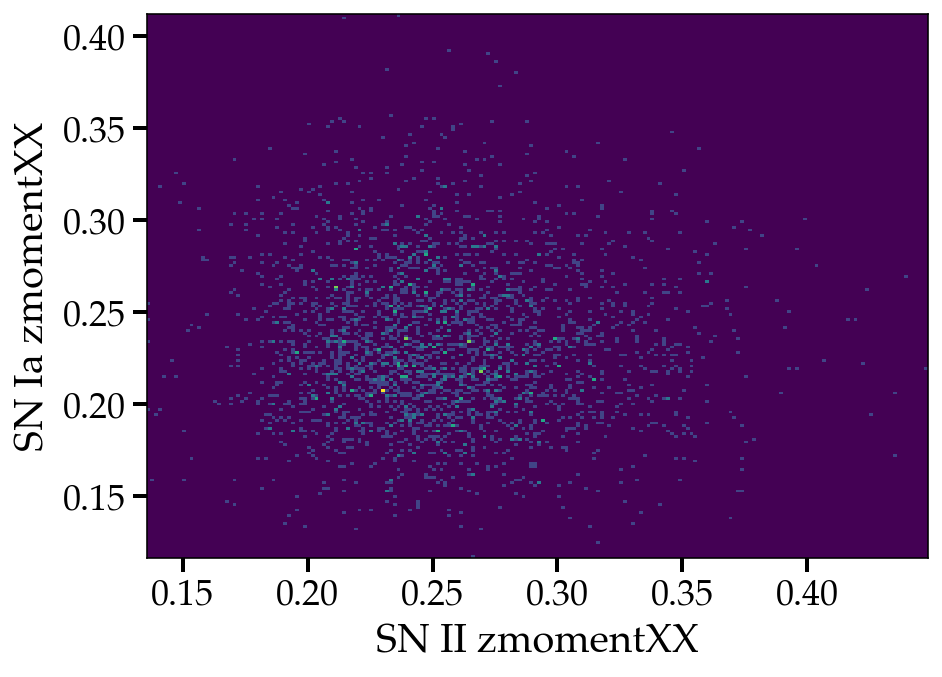

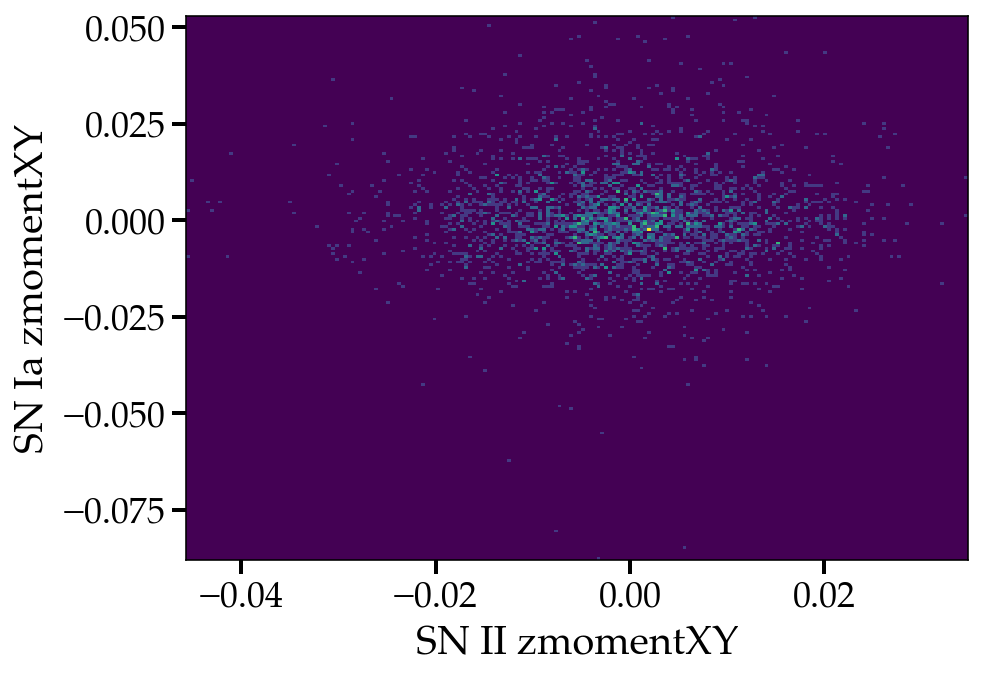

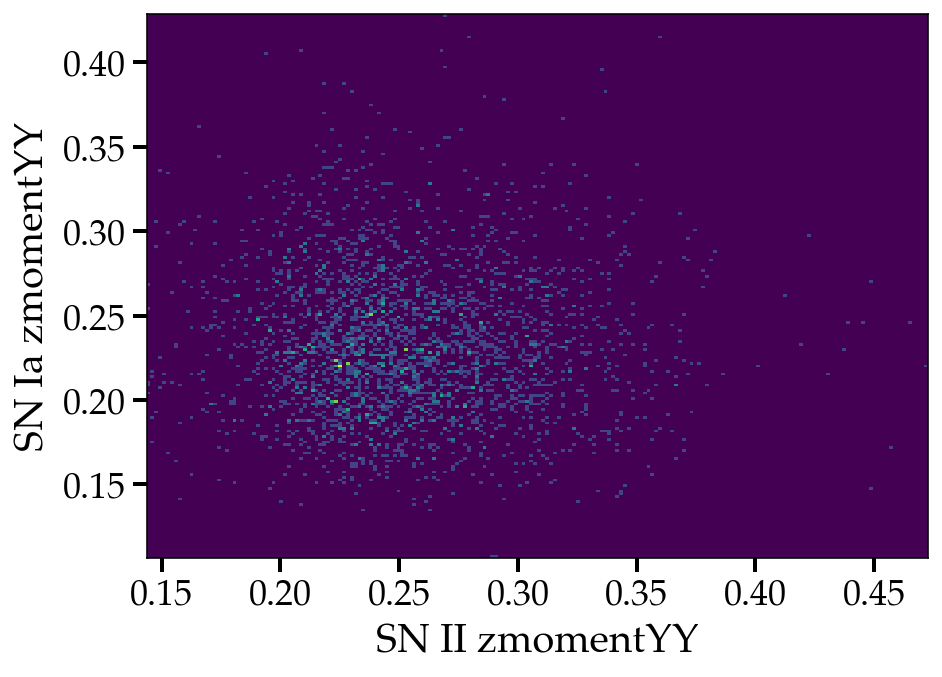

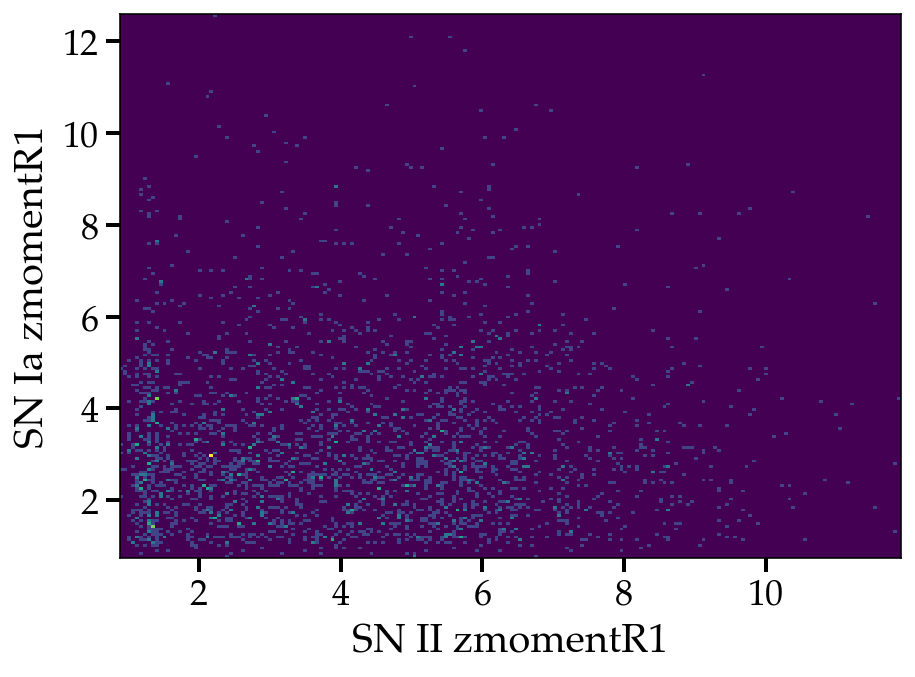

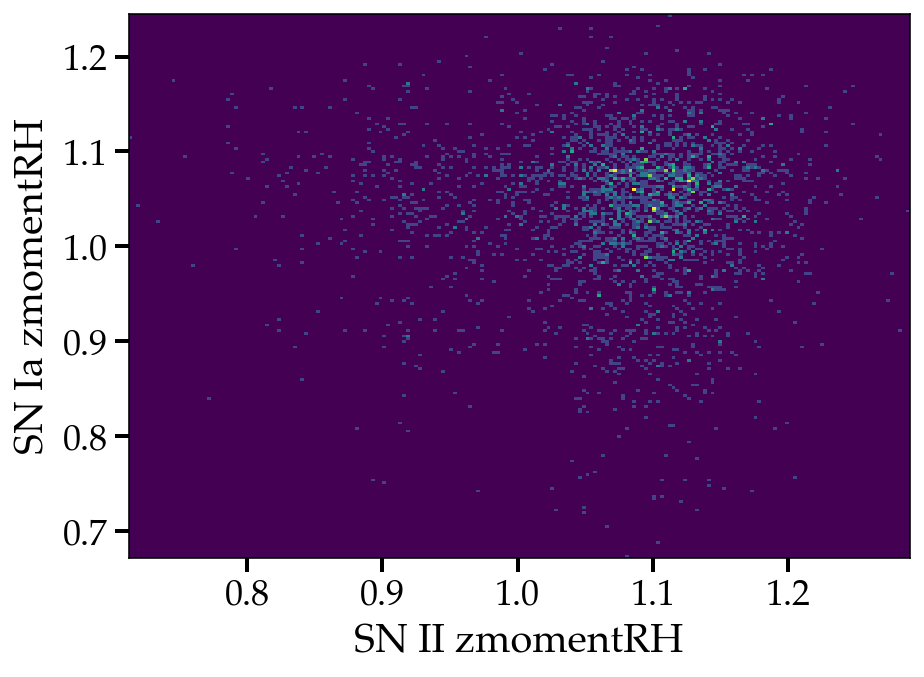

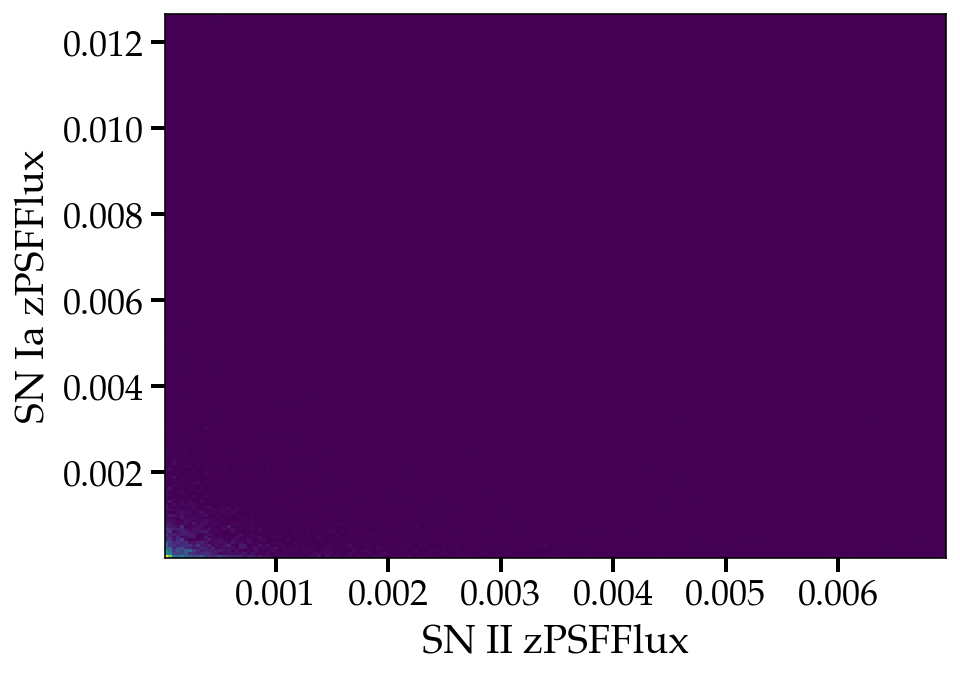

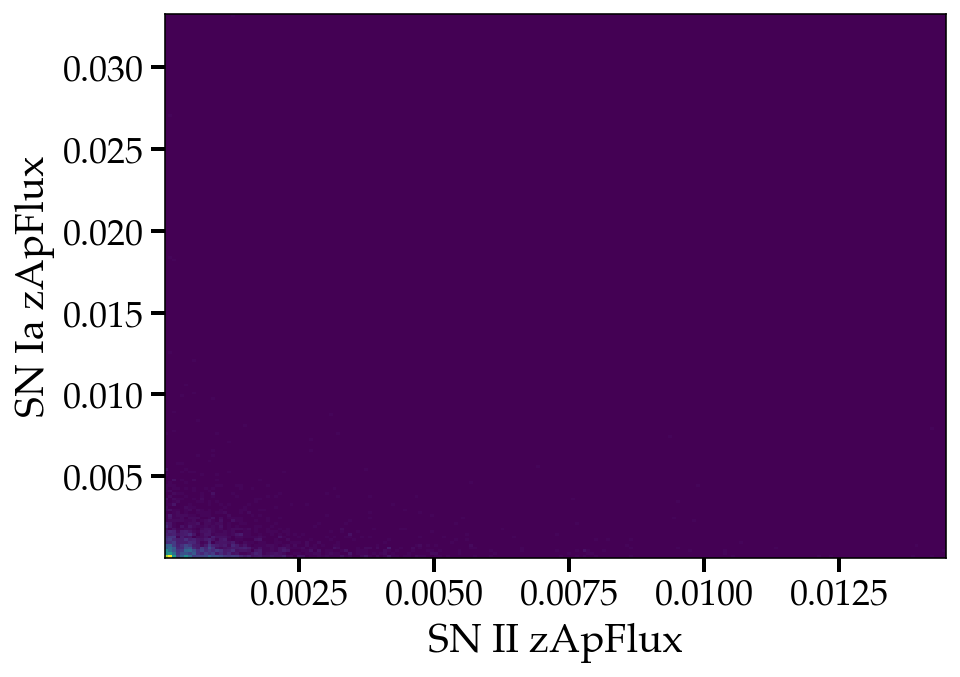

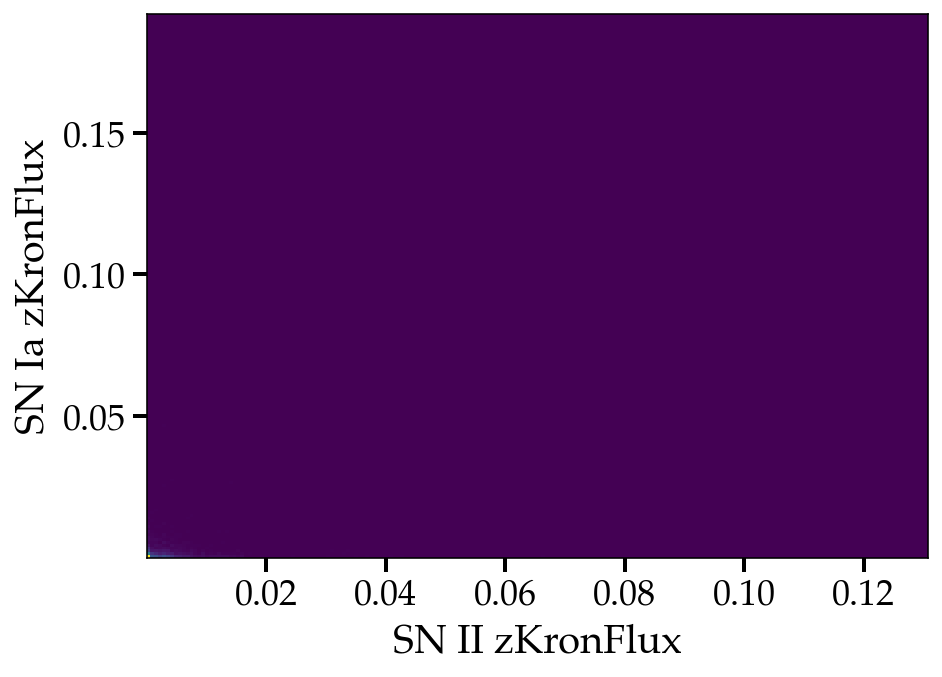

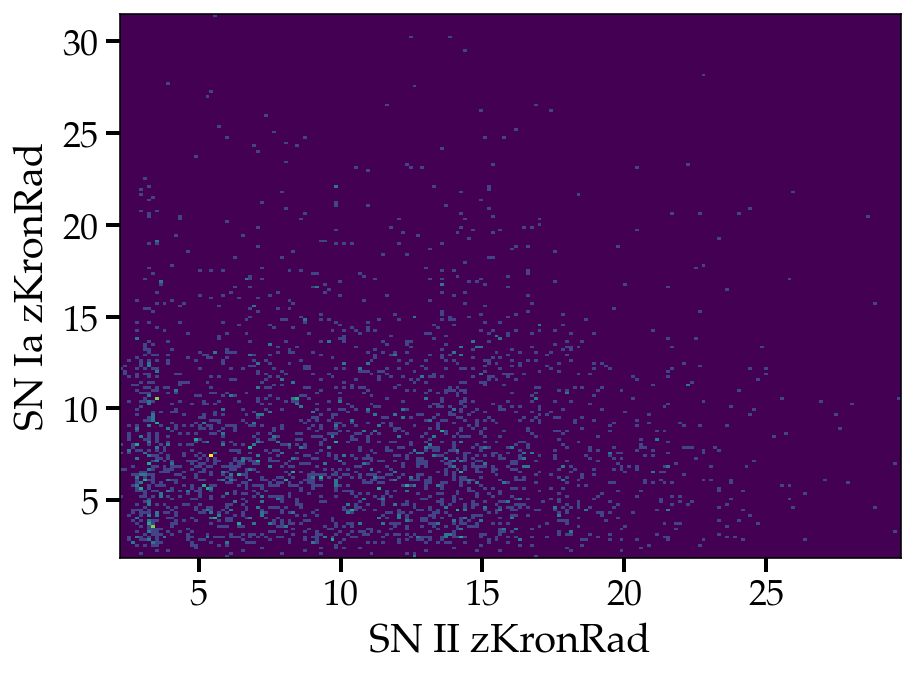

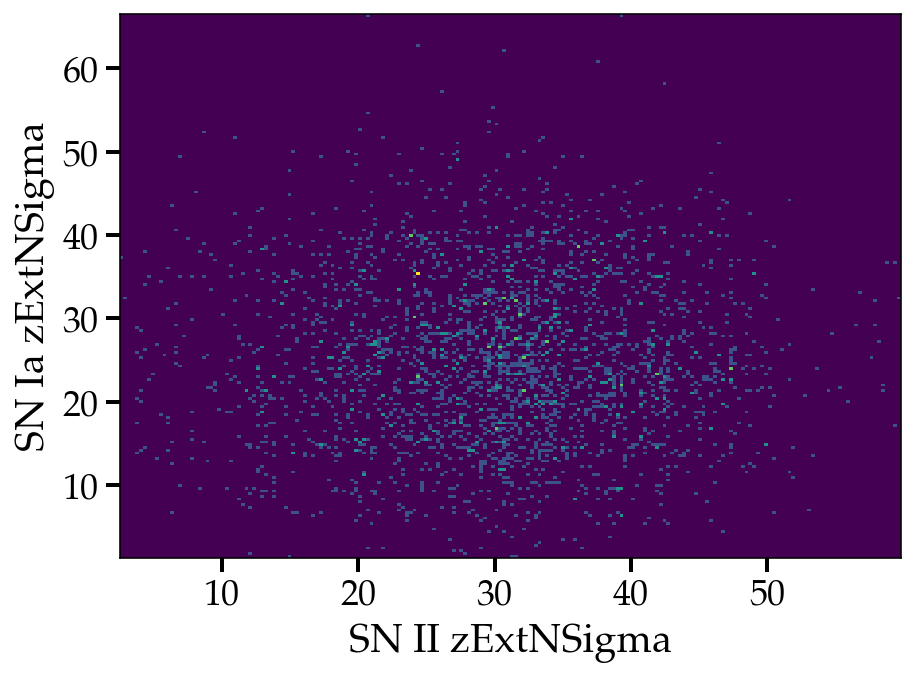

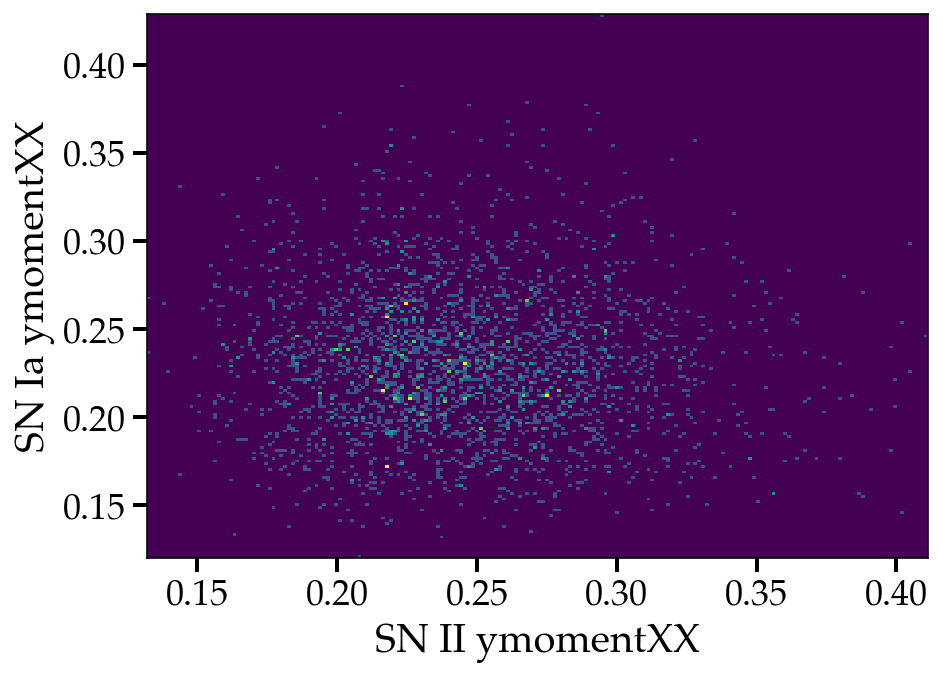

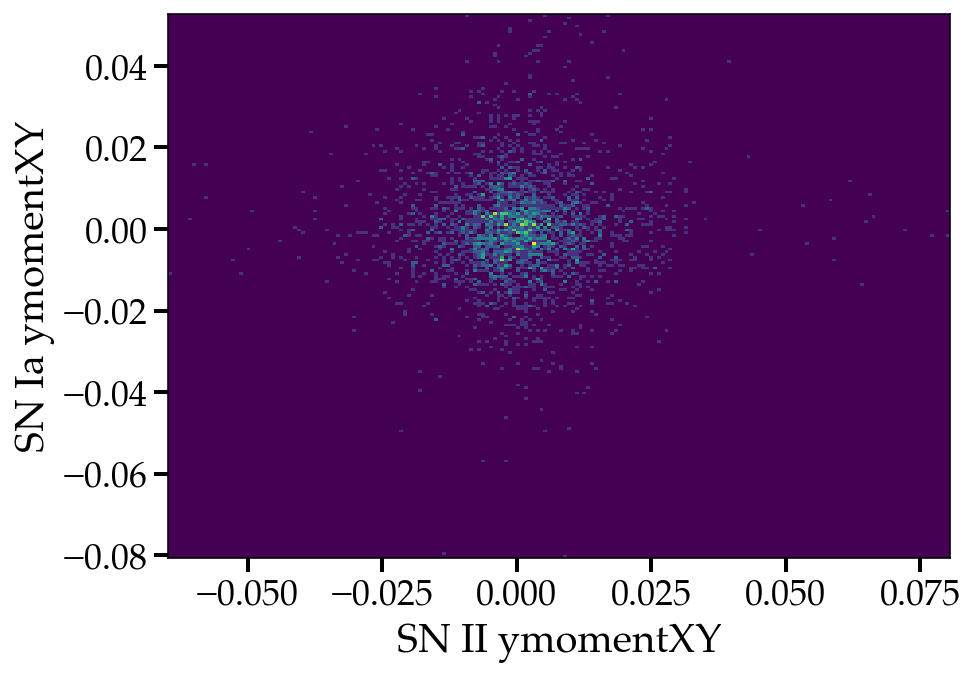

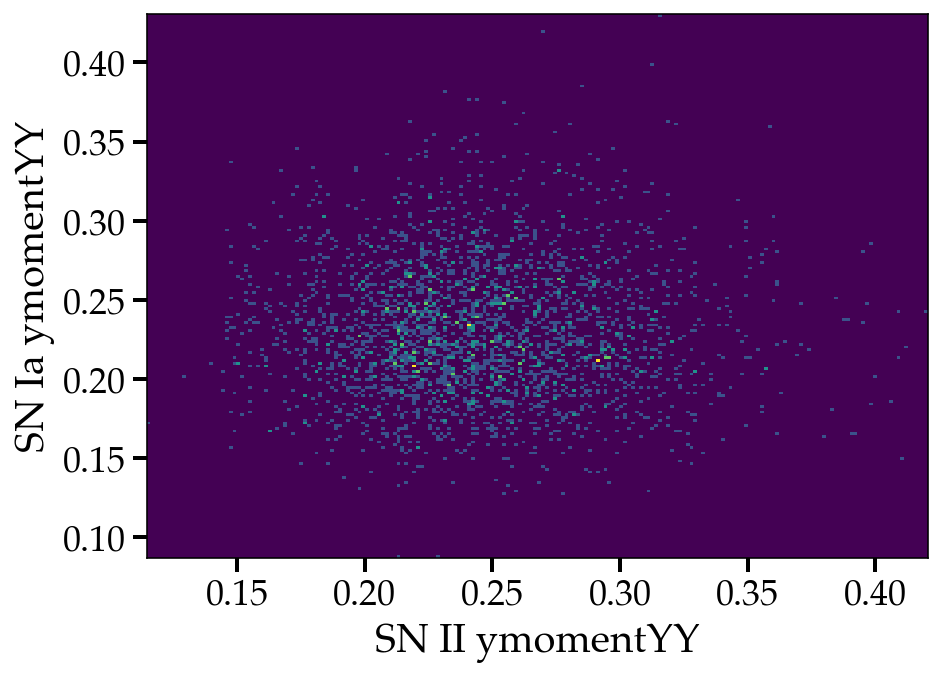

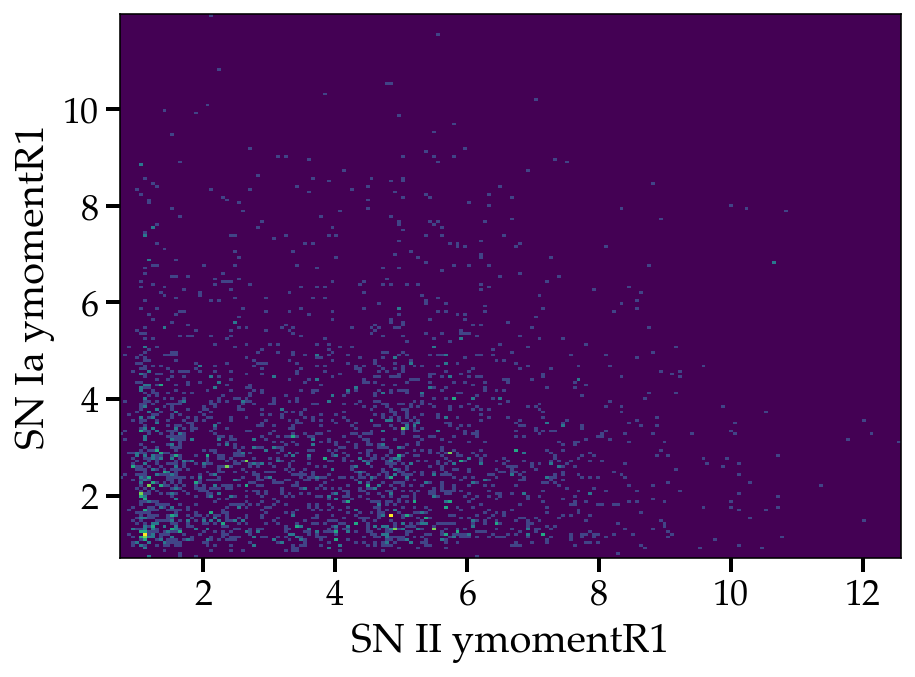

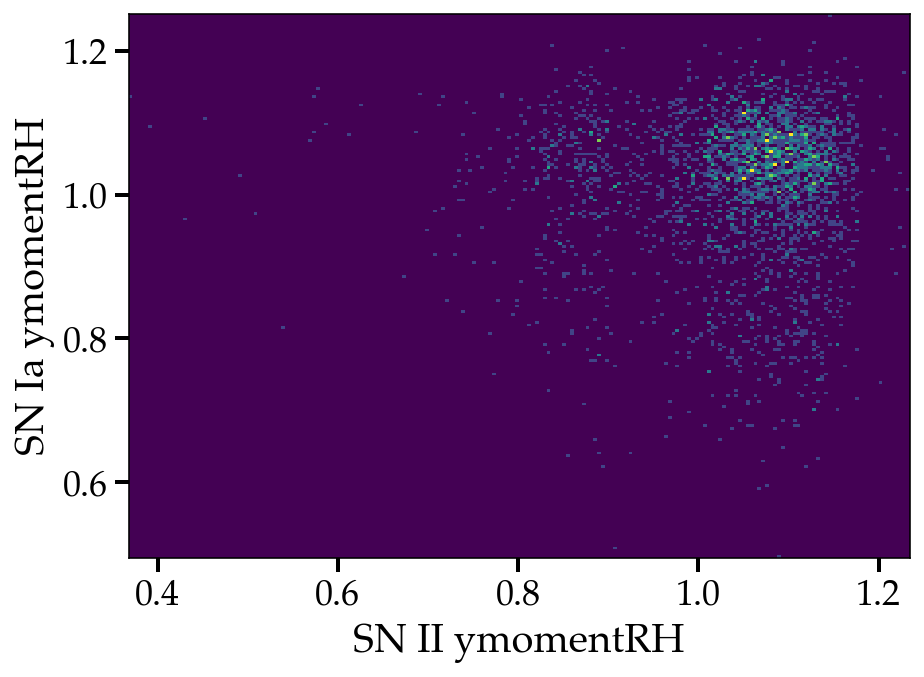

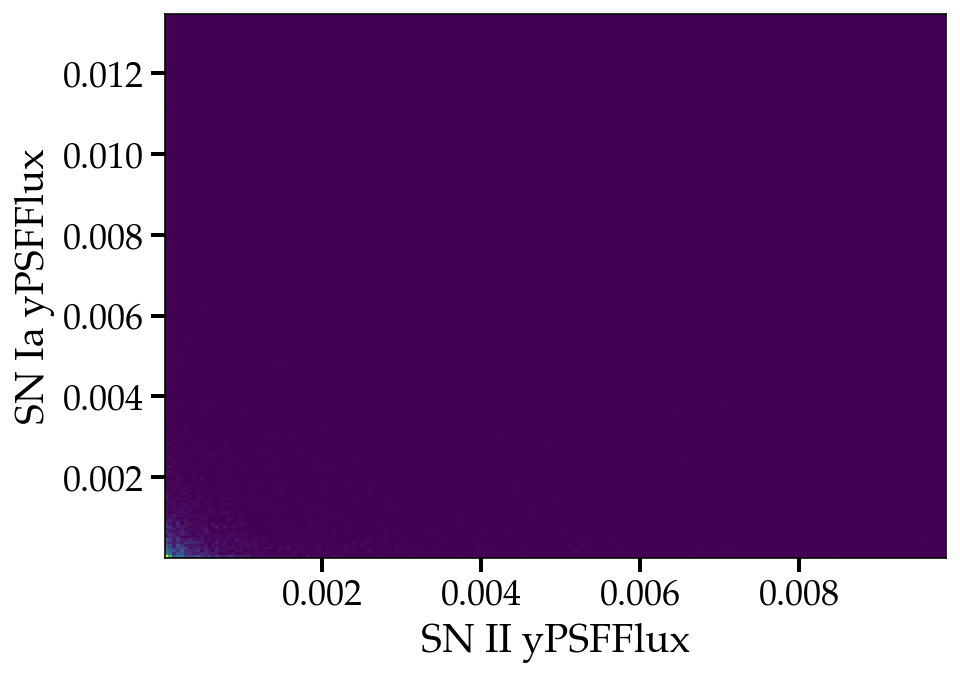

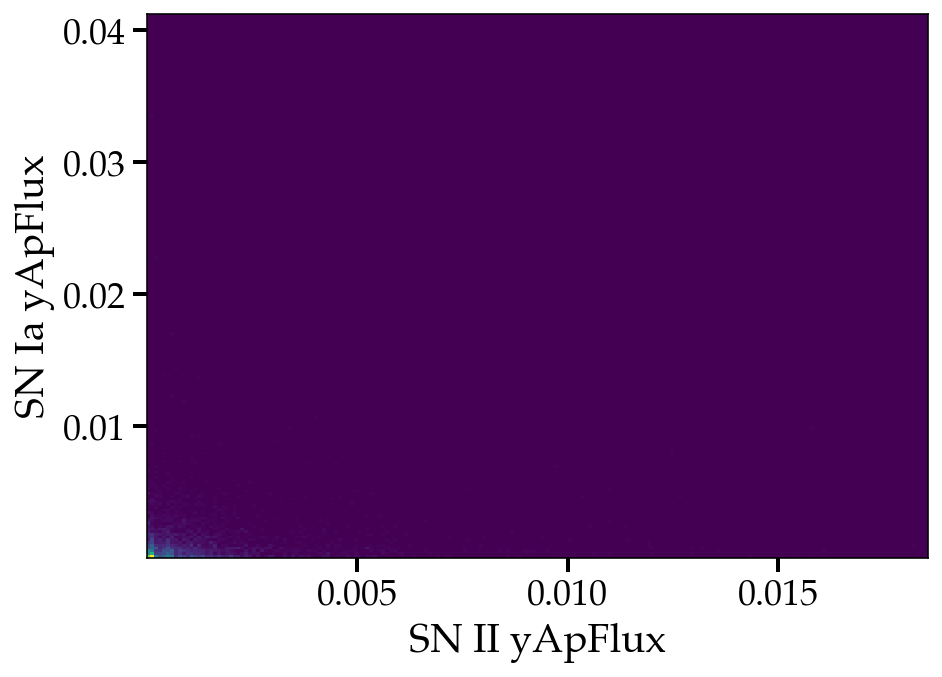

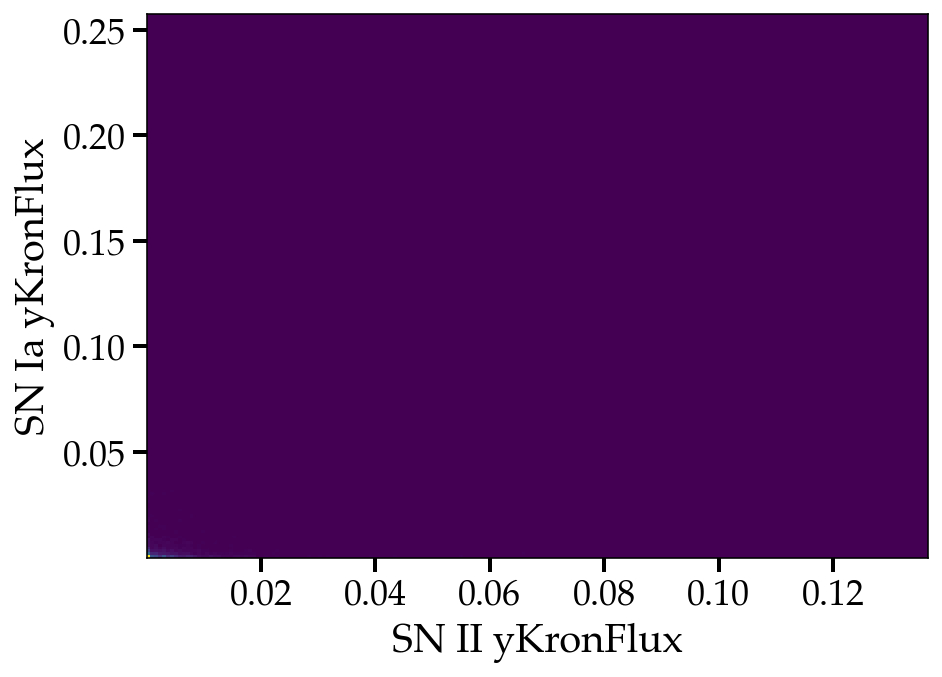

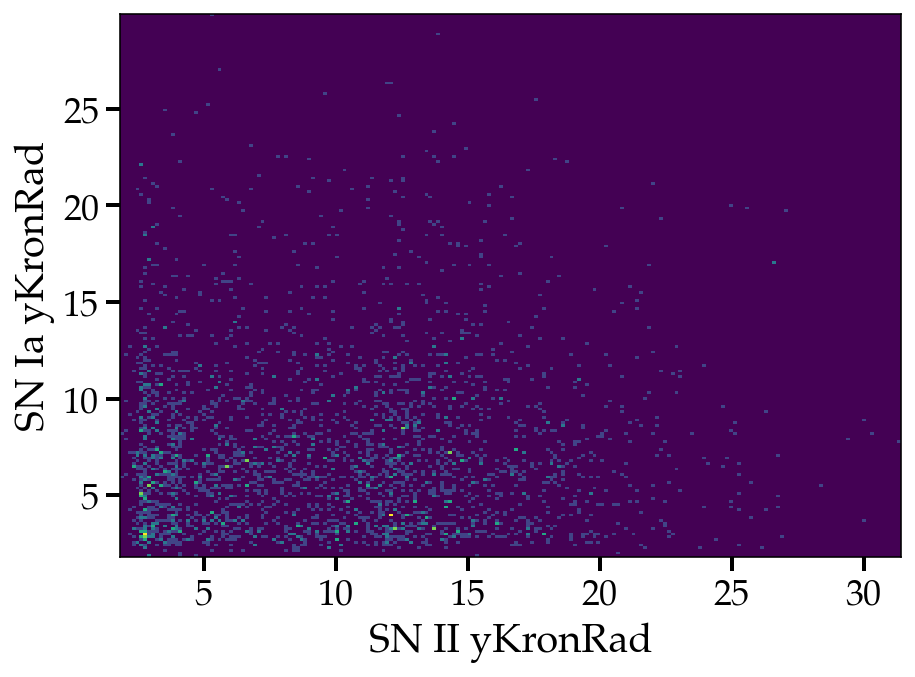

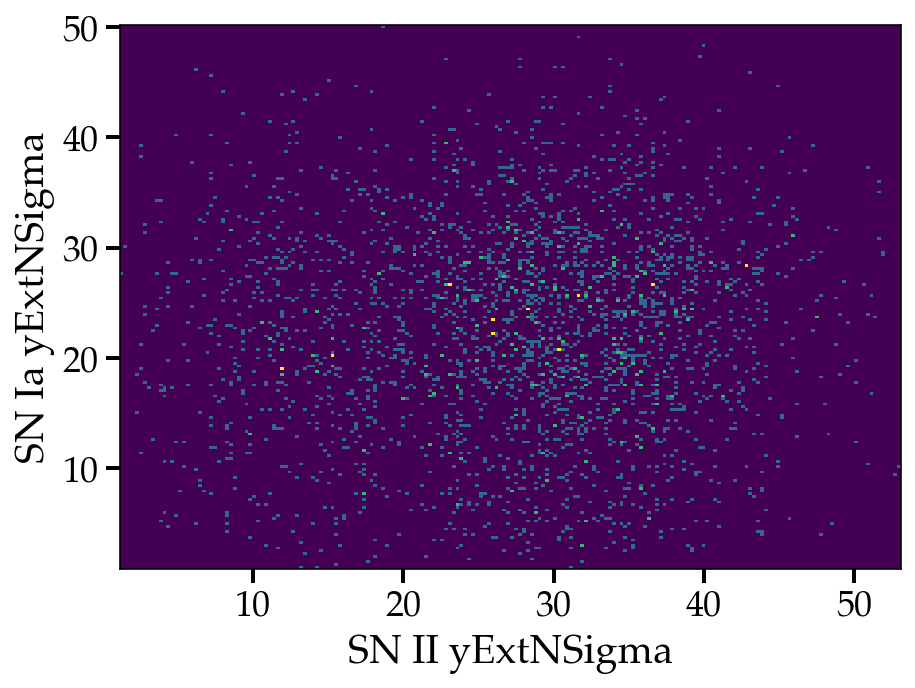

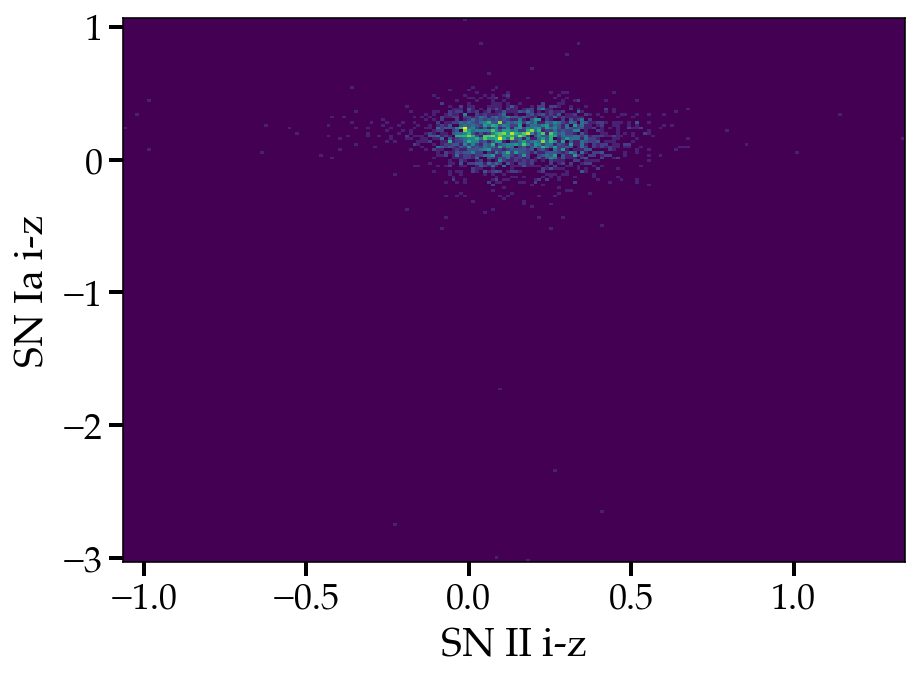

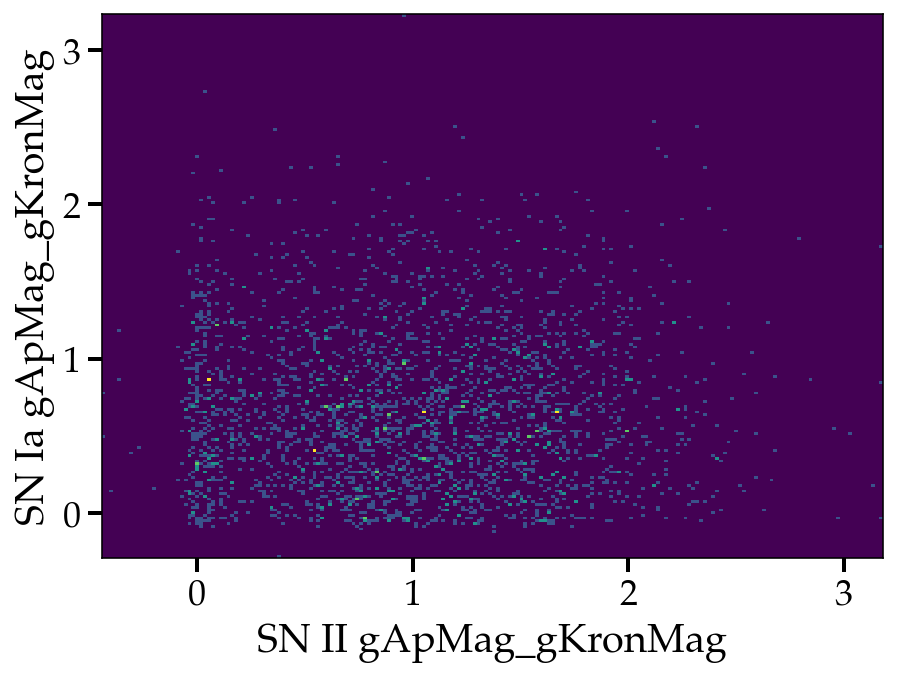

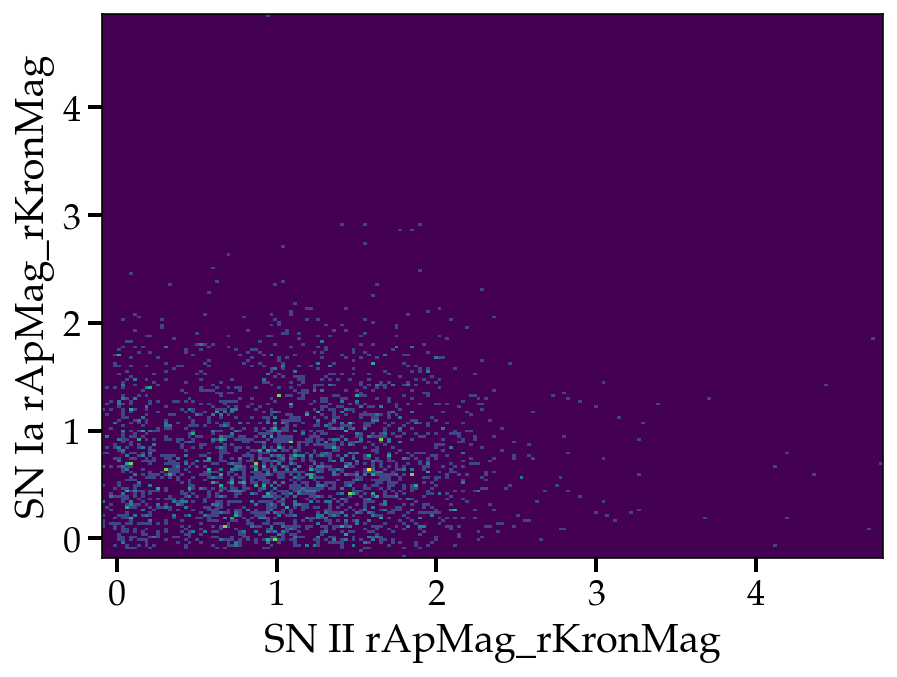

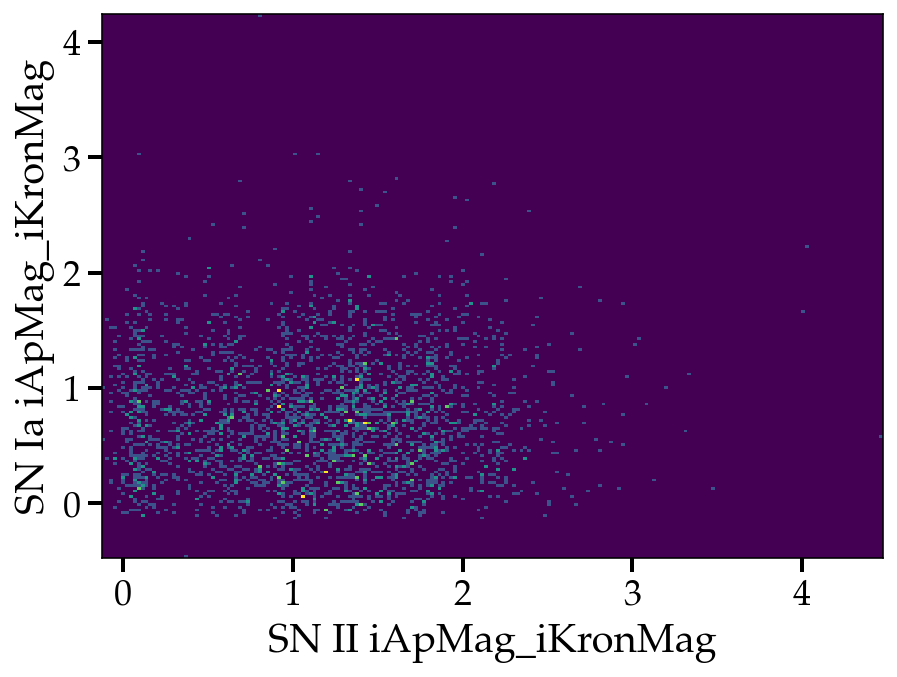

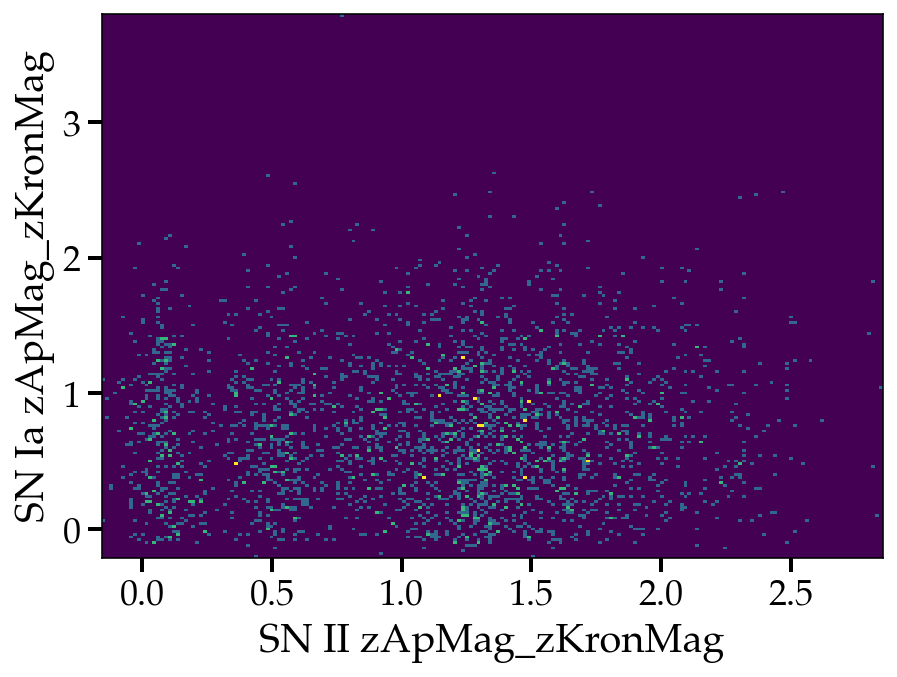

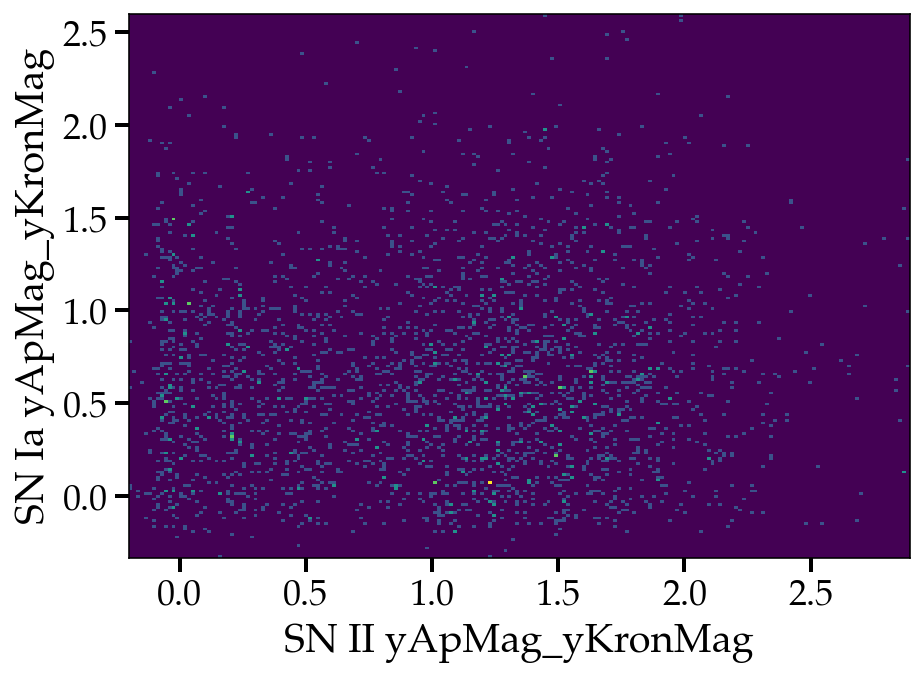

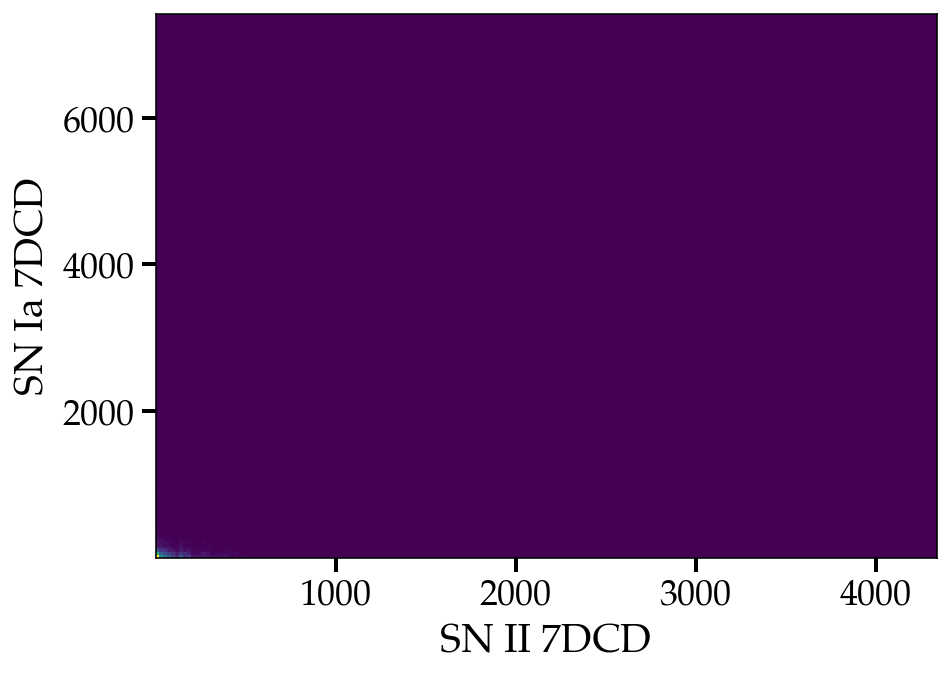

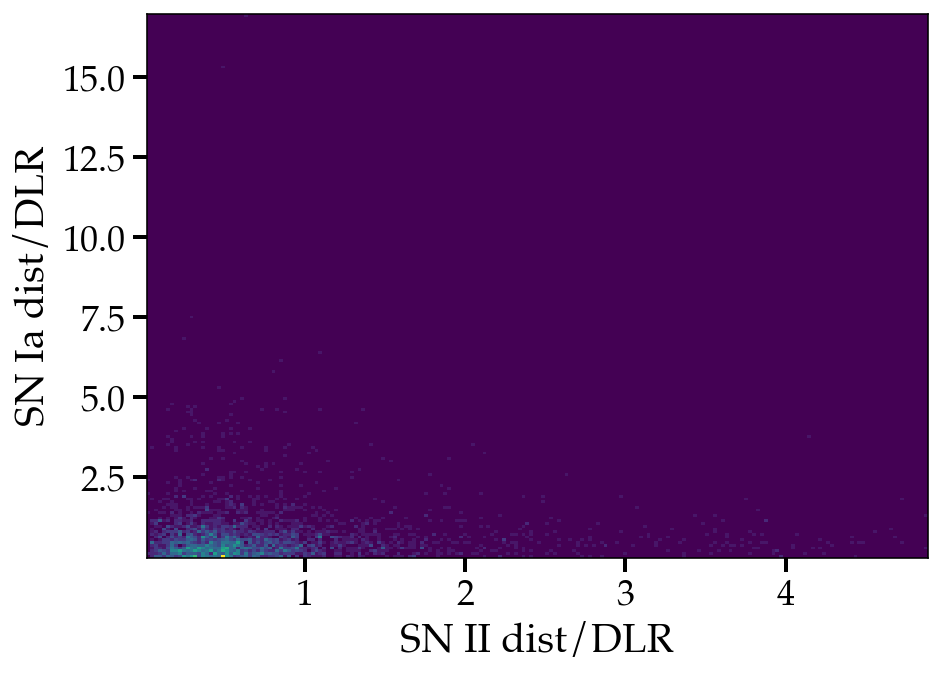

In [37]:
snii_df = dataset_bank_tns_df_resampled_train[dataset_bank_tns_df_resampled_train.tns_cls == "SN II"]
snia_df = dataset_bank_tns_df_resampled_train[dataset_bank_tns_df_resampled_train.tns_cls == "SN Ia"]

for i in range(0, 120, 1):
    feat = lc_and_host_features[0:120][i]
    plt.hist2d(snii_df[feat], snia_df[feat], bins=200)
    plt.xlabel(f"SN II {feat}")
    plt.ylabel(f"SN Ia {feat}")
    plt.show()